In [5]:
# This Jupyter notebook was created by Emily Olafson to predicit cognitive scores from structural and functional connectivity data in stroke subjects.
# Last updated: March 10 2022
# https://github.com/emilyolafson/cognition_nemo

#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend, Parallel, delayed
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.fixes import loguniform
import matplotlib as mpl
from numpy import genfromtxt
import nibabel as nib
import os

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def prepare_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    zeros=X==0
    zeros=np.sum(zeros,0)
    zeros=zeros==X.shape[0]
    X=X[:,~zeros]
    print("Final size of X: " + str(X.shape))
    
    return X

def prepare_image_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    X=np.reshape(X, (101,902629))
    print("Final size of X: " + str(X.shape))
    
    return X

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def naive_pearson_cor(X, Y):
    '''Naive (scipy-based/iterative) pearson correlation. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    result = np.zeros(shape=(X.shape[1], Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            r, _ = pearsonr(X[:,i], Y[:,j])
            result[i,j] = r
    return result[0]


def feature_select_PCA(x_train, x_test, a):
    """Return values for the top a PCs of x based on PCA of x.
         
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of PCs
         
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features 
            var_expl = variance explained by top a components
            components = PCs selected"""
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
    
    # Feature selection: use only the top n features based on top a PCs in training data 
    pca = PCA(n_components=a, copy=True, random_state=42)
    x_train_featselect = pca.fit(x_train).transform(x_train)
    x_test_featselect = pca.transform(x_test)
    components = pca.components_

    
    var_expl = pca.explained_variance_


    return x_train_featselect,x_test_featselect, components

def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x_train = input matrix for training subjects
             x_test = input matrix for test subjects
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
            ind = indices of top a features """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect, ind


def scale_data(x_train, x_test):
    '''Scale the training data and apply transformation to the test/validation data.

        Inputs:
            x_train = training predictors
            x_test = training predictors 
        
        Returns:
            x_train_scaled
            x_test_scaled '''
    
    # Scale x_train 
    scaler = preprocessing.StandardScaler().fit(x_train)
    
    # apply transformation to train & test set.
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled, x_test_scaled

def normalize_data(x_train, x_test):
    '''subtracting the mean and dividing by the l2-norm'''
    x_train_mean=np.mean(x_train)
    x_train_norm=np.linalg.norm(x_train)
    
    x_test_mean=np.mean(x_test)
    x_test_norm=np.linalg.norm(x_test)
    
    x_train=(x_train-x_train_mean)/x_train_norm
    x_test=(x_test-x_test_mean)/x_test_norm

    return x_train, x_test

def gcv_ridge(hyperparam, x, y, k, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        expl_var = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        #x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with all values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)
 
    # note: don't use r2_score for ridge regression bc it does not account for bias error
    r2=np.mean(R2)
    
    cor=np.mean(correl)
    
    # use explained_variance_score instead:
    expl_var=np.mean(explvar)
    
    return expl_var

def gcv_ridge_strat(hyperparam, x, y, k, chronic_bin, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        expl_var = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        chron_train=chronic_bin[train_index] 
        chron_valid=chronic_bin[valid_index]
        
        #x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
        
        # add chronicity variable after features selection
        chron_train=np.reshape(np.double(chron_train), (x_train.shape[0], 1))
        x_train=np.concatenate((x_train, chron_train),axis=1)
        
        chron_valid=np.reshape(np.double(chron_valid), (x_valid.shape[0], 1))
        x_valid=np.concatenate((x_valid, chron_valid),axis=1)
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with total values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)

    # note: don't use r2_score for ridge regression bc it does not account for bias error
    r2=np.mean(R2)
    
    cor=np.mean(correl)
    
    # use explained_variance_score instead:
    expl_var=np.mean(explvar)
    
    
    return expl_var

def parallel_featsearch_strat(alpha, X, Y, k, chronic_bin, featselect, feat):
    ''' Stratified grid search in parallel.

    Returns:
        expl_var - explained variance for given combination of alpha/feat/featselect'''
    
    expl_var=gcv_ridge_strat(alpha, X, Y, k, chronic_bin, featselect, feat)
    
    return expl_var

def parallel_featsearch(alpha, X, Y, k, featselect, feat):
    ''' Grid search in parallel.

    Returns:
        expl_var - explained variance for given combination of alpha/feat/featselect'''
    
    expl_var=gcv_ridge(alpha, X, Y, k, featselect, feat)
    return expl_var

# Inner loop - grid search
def gridsearch_cv_strat(k, x, y, chronic_bin, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. Uses stratified k-fold cross-validation for inner loop.
        
        Input:
            x = N x p input matrix
            y = 1 x p variable to predict
            k = k value in k-fold cross validation 
            featsel = type string, feature selection method, default="None"
                'None' - no feature selection; use all variables for prediction
                'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
                'PCA' - perform PCA on the training variables and use the top 'feats' PCs as input variables, by variance explained, for prediction
            chronic_bin - stratification binary variable
            featselect - type of features selection. can be "correlation" or "PCA"
            alphas - range of alpha parameters to search 
            feats - range of # features to search
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters
            gcv_values - R^2 across all combinations of hyperparametrs.'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch_strat)(alpha,x, y, k, chronic_bin, featselect, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values

# Inner loop - grid search
def gridsearch_cv(k, x, y, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. 
        
        Input:
            x = N x p input matrix
            y = 1 x p variable to predict
            k = k value in k-fold cross validation 
            featsel = type string, feature selection method, default="None"
                'None' - no feature selection; use all variables for prediction
                'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
                'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
            alphas - range of alpha parameters to search 
            feats - range of # features to search
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters
            gcv_values - R^2 across all combinations of hyperparametrs.'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        # run feature selection (# of components) in parallel
        gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha,x, y, k, featselect, feat) for feat in feats)
        gcv=np.array(gcv)
        gcv_values[row]=gcv
            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values

def gridsearch_plsr(k, x, y, components):
    ''' Performs grid search for PLS regression using fixed predefined hyperparameter range and returns the best n components for 
        a given training/validation sample. Calculates PRESS (preedicted residual sum of squares) for each subject.

        Returns:
            presssum - sum of PRESS for all subjects'''
    
    presssum=[]
    # iterate through components
    for comp in components:
        
        row, = np.where(components==comp)
        
        kf = KFold(n_splits=k,shuffle=True,random_state=43)
        
        scores=[]
        press=[]
        
        # calculate PRESS for each held-out subject
        for i in range(0, x.shape[0]):
            trainx = np.delete(x, i, axis=0)
            trainy = np.delete(y, i, axis=0)
            
            pls = PLSRegression(n_components=comp, scale=True, copy=False)
            pls.fit(trainx, trainy)

            ypred = pls.predict(x[i,:].reshape(1, -1) )
            ytrue=y[i].reshape(1, -1)
            press.append(sum((ytrue.T-ypred.T)**2))
            
        presssum.append(np.sum(press))
        
    return presssum

def plot_figure(gcv_values, string, midpoint):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)
    
    Inputs:
        gcv_values - matrix to plot
        string - title
        midpoint - point at which blue turns to red.'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=midpoint, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    plt.savefig(results_dir+string+ '.png')
    plt.show()

not found: 75
not found: 75


<ipython-input-23-a742995cd1c4>:54: RuntimeWarning: divide by zero encountered in log
  lesionvol=np.log(lesionvol) # log-transform lesion data


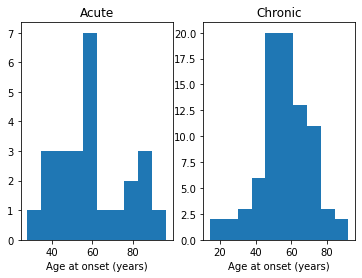

In [23]:
# ------- Load data -----------

# Set paths
data_dir='/home/ubuntu/cognition_iowa/'
results_dir='/home/ubuntu/cognition_iowa/results/' 

#Load input variables (estimated SC and FC) and save all subjects to one .mat file for eFC prediction (Zijin's code)
nROIs=86
df =  pd.read_csv(data_dir + 'enhanced_df2.csv', header=0)
subj_id=df['eIDs2']

sc= np.zeros([len(subj_id),3655])

# Load SC (acute)
for i in range(len(subj_id)):
    if subj_id[i]=='ca124': # no lesion
        print("not found: " + str(i))
        continue
    if subj_id[i]=='ca089': # no lesion
        print("not found: " + str(i))
        continue
    filename = data_dir + "data/sc/%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = np.genfromtxt(filename, delimiter='')

    # pairwise vectorized upper triangular
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]

sc = np.delete(sc,(75), axis=0)
df =  pd.read_csv(data_dir + 'enhanced_df2.csv',header=0)
wais = np.array(df['eWAIS2'])
wais = np.delete(wais,(75), axis=0)

chronicity = np.array(df["eChronicity2"])
chronicity = np.delete(chronicity,(75), axis=0)

acute_id = chronicity=="acute"
chronic_id = chronicity=="chronic"

# Load lesion volume
lesionvol = np.zeros([len(subj_id),1])

for i in range(len(subj_id)):
    if subj_id[i]=='ca124': # no lesion
        print("not found: " + str(i))
        continue
    if subj_id[i]=='ca089': # no lesion
        print("not found: " + str(i))
        continue
    filename = data_dir + "lesionvol/%s.txt" % (subj_id[i])
    tmp= np.genfromtxt(filename, delimiter='')
    lesionvol[i,:] =tmp[0]
    
lesionvol=np.log(lesionvol) # log-transform lesion data
lesionvol = np.delete(lesionvol,(75), axis=0)


# Load lesion PC score
filename = data_dir + "pc_score.csv"
pc_lesion = pd.read_csv(filename, header=None)

# Load all demographic scores
demogs= pd.read_csv(data_dir + 'df_final.csv',header=0)

demogs_acute=demogs[demogs['acute_chronic']=='acute']
demogs_chronic=demogs[demogs['acute_chronic']=='chronic']

plt.subplot(1,2,1)
plt.hist(demogs_acute['Age_at_Onset_Years'])
plt.title("Acute")
plt.xlabel('Age at onset (years)')

plt.subplot(1,2,2)
plt.hist(demogs_chronic['Age_at_Onset_Years'])
plt.title("Chronic")
plt.xlabel('Age at onset (years)')
demogs2= pd.read_csv(data_dir + 'df_final_cardiac_race_smoker_diabetes.csv',header=0)

new =demogs2[['Age_at_Onset_Years','Time_from_onset_years','SEX', 'HANDEDNESS','RACE_3','RACE_5', 'RACE_7','EDUC','Smoker_1','Smoker_2','Smoker_3','Smoker_4', 'Diabetes_type_II_1',  'Diabetes_type_II_2', 'Diabetes_type_II_3','Cardiac_history_1', 'Cardiac_history_2', 'Cardiac_history_3', 'Cardiac_history_4', 'Cardiac_history_5','Cardiac_history_6', ]]
clin_vars=pd.get_dummies(new)
clin_vars['HANDEDNESS']=clin_vars['HANDEDNESS']-1


<ipython-input-24-20b831e273e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demogs_acute['Time_from_onset_months'][105]=0.97 # ca156. stroke 11/10/2012, testing 12/09/2011, listed as acute, assuming testing is 12/09/2012
/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'Time from onset (months)')

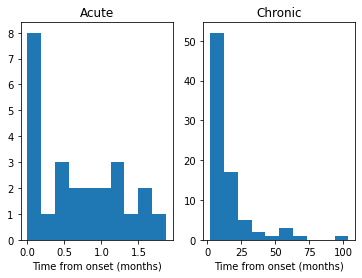

In [24]:
plt.subplot(1,2,1)
demogs_acute['Time_from_onset_months'][105]=0.97 # ca156. stroke 11/10/2012, testing 12/09/2011, listed as acute, assuming testing is 12/09/2012
plt.hist(demogs_acute['Time_from_onset_months'])
plt.title('Acute')
plt.xlabel('Time from onset (months)')

plt.subplot(1,2,2)
plt.hist(demogs_chronic['Time_from_onset_months'])
plt.title('Chronic')
plt.xlabel('Time from onset (months)')


Text(0.5, 0, 'WAIS_IV_DS_TOTAL_RAW')

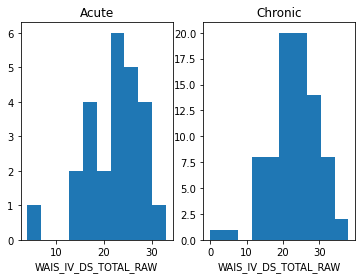

In [12]:
plt.subplot(1,2,1)
plt.hist(demogs_acute['WAIS_IV_DS_TOTAL_RAW'])
plt.title('Acute')
plt.xlabel('WAIS_IV_DS_TOTAL_RAW')

plt.subplot(1,2,2)
plt.hist(demogs_chronic['WAIS_IV_DS_TOTAL_RAW'])
plt.title('Chronic')
plt.xlabel('WAIS_IV_DS_TOTAL_RAW')


In [5]:
female=np.sum(demogs_acute['SEX']=='F')
male=np.sum(demogs_acute['SEX']!='F')

print("--- Acute ---")
print("Number of female subjects: " + str(female))
print("Number of male subjects: " + str(male))

female=np.sum(demogs_chronic['SEX']=='F')
male=np.sum(demogs_chronic['SEX']!='F')

print("--- Chronic ---")
print("Number of female subjects: " + str(female))
print("Number of male subjects: " + str(male))

--- Acute ---
Number of female subjects: 13
Number of male subjects: 12
--- Chronic ---
Number of female subjects: 39
Number of male subjects: 43


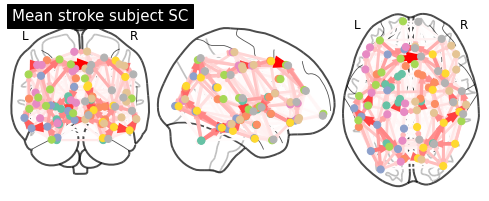

In [40]:
# SC average across stroke subjects
from nilearn import datasets
from nilearn import plotting

fs86 = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86[inds] = np.mean(sc, axis=0)

sub = np.zeros((86, 86))
sub[inds] = sc[2]

fs86[fs86>16000]=1000

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86, coordinates,edge_threshold="90%",
                         title='Mean stroke subject SC')


In [17]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=20
alpha_start=-4
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0
#number of features (# pricipal components or variables to retain)
feat_start=1
feat_end=50

n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)
Y=np.reshape(Y, (107,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))

if featselect=='correlation':
    x_train_featselect,x_test_featureselect,ind = feature_select_correlation(x,x_test, y, bestfeats)

elif featselect=='PCA':
    x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(x,x_test, bestfeats)

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

# fit model 
y_pred = regr.fit(x_train_featselect, y).predict(x_test_featureselect)


Final size of X: (107, 3192)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Best combination: 
 alpha =  0.06951927961775606 
 Features =  1 
 R^2 =  0.247


<ipython-input-14-343597912cef>:524: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


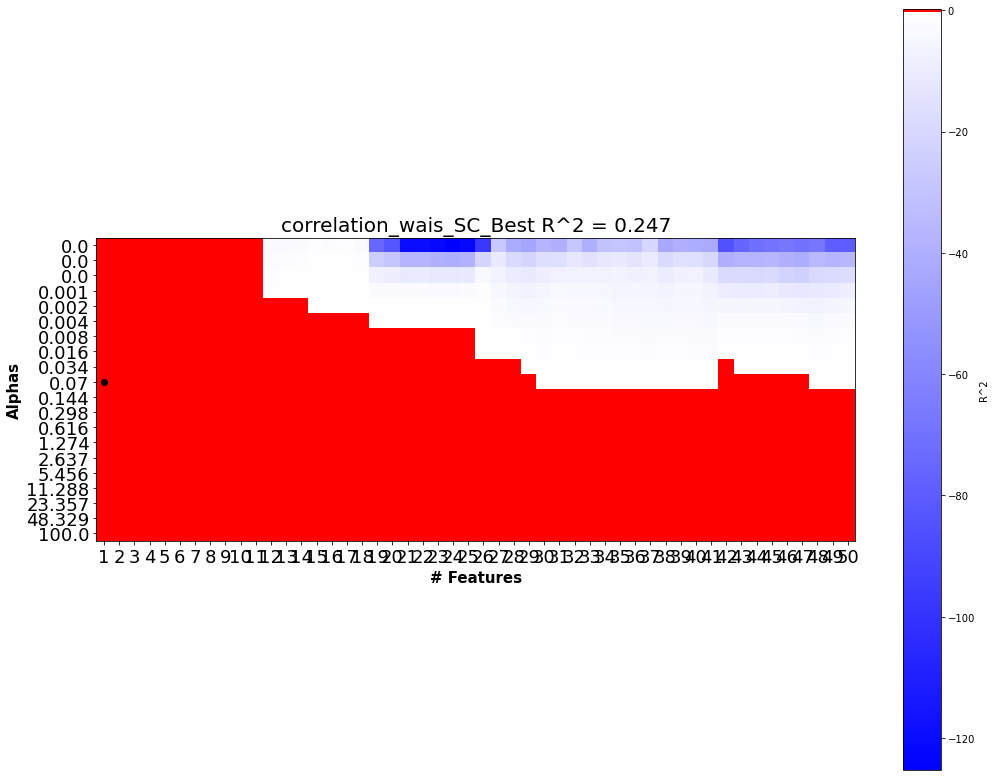

In [20]:
# plot variance explained over hyperparameter search space
plot_figure(gcv_values_r2,'correlation_wais_SC',0.999)

In [25]:
# predictions for SC-  PCA and correlation
results_dir='/home/ubuntu/cognition_iowa/results/correlation_sc_enhanced2/'
import datetime

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(wais)
    Y=np.reshape(Y, (107,1))
    
    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=1
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        cor=[]
        for train, test in outer_cv.split(X, chronic_id):
            begin_time = datetime.datetime.now()
            
            chronic_bin=chronic_id[train]
            chronic_test=chronic_id[test]
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, X[train], Y[train], chronic_bin, featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            
            chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
        
            chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
            chronicsubs_test=chronic_id[test]==True
            chronicsubs_train=chronic_id[train]==True
            chronicsubs_test=chronicsubs_test.flatten()
            chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

            ytrue_chronic = Ytest[chronicsubs_test]
            xtest_chronic=Xtest[chronicsubs_test]
            
            ytestc.append(ytrue_chronic)
            
            ychronic_pred = regr.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            print("Explained variance, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred)))
            ypredc.append(ychronic_pred)

            chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred))
            
 
        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        chronic_allexpl_var.append(chronic_explvar)
        correlations.append(cor)
        print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')

        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(importance, output)
        output.close()   


Final size of X: (107, 3192)
Permutation: 0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.264614
R2 loop: 0.23324933056565922
Explained var: 0.25798883231693115
correlation: [[0.50806784]]
Explained variance, chronic only:  0.2651276874840044
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.359914
R2 loop: 0.15089356946690002
Explained var: 0.15101080919802945
correlation: [[0.45934078]]
Explained variance, chronic only:  0.18187840387803988
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.276036
R2 loop: 0.2166535823223349
Explained var: 0.26376125481969903
correlation: [[0.52089328]]
Explained variance, chronic only:  0.3392309925457041
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects i

time to run loop: 0:00:04.326454
R2 loop: -0.18084811405690826
Explained var: 0.13251700832111402
correlation: [[0.42606932]]
Explained variance, chronic only:  0.15825857868036863
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-14-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:04.324891
R2 loop: 0.4905307050086378
Explained var: 0.49363995634205515
correlation: [[0.74121414]]
Explained variance, chronic only:  0.5146636088651436
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.333896
R2 loop: 0.22315959678653519
Explained var: 0.23678693955306862
correlation: [[0.63858901]]
Explained variance, chronic only:  0.2511706644229851
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.354233
R2 loop: 0.003993315464096647
Explained var: 0.25371796730709506
correlation: [[0.52397748]]
Explained variance, chronic only:  -0.30735012202344314
---- Permutation avg. chronic explained variance: 0.034467999753198184----
---- Permutation avg. explained variance: 0.2113146703481646----
Permutation: 6
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subject

time to run loop: 0:00:04.274735
R2 loop: -0.11303822733581836
Explained var: 0.0968994679606654
correlation: [[0.31849205]]
Explained variance, chronic only:  -0.07158354786552912
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.386841
R2 loop: -0.013536365734983624
Explained var: -0.010032414493690078
correlation: [[0.05763005]]
Explained variance, chronic only:  -0.043338773290398924
---- Permutation avg. chronic explained variance: 0.029443103231213907----
---- Permutation avg. explained variance: 0.09943710139810424----
Permutation: 11
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.166618
R2 loop: 0.013450933174283142
Explained var: 0.1838349711106405
correlation: [[0.77714875]]
Explained variance, chronic only:  0.18793361282274268
5-fold cross-validation results in 68.0 subjects in the training set, and 17

time to run loop: 0:00:04.188349
R2 loop: 0.14741515714446274
Explained var: 0.23426527271864472
correlation: [[0.50151718]]
Explained variance, chronic only:  0.11911853549176432
---- Permutation avg. chronic explained variance: 0.09214077091032932----
---- Permutation avg. explained variance: 0.15474845654511132----
Permutation: 16
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.363434
R2 loop: 0.0717277658080332
Explained var: 0.07277622224971136
correlation: [[0.27831909]]
Explained variance, chronic only:  0.04926314849815683
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.425783
R2 loop: -0.16849140690475295
Explained var: -0.16235142132516467
correlation: [[0.08735606]]
Explained variance, chronic only:  -0.22968353026850186
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 sub

time to run loop: 0:00:04.354180
R2 loop: -0.017833119911931927
Explained var: 0.06711649780762241
correlation: [[0.26861895]]
Explained variance, chronic only:  0.05007786705419193
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.302124
R2 loop: 0.027149237064429954
Explained var: 0.030455027442170657
correlation: [[0.22337773]]
Explained variance, chronic only:  -0.0844501323551079
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.315913
R2 loop: 0.3115224767763761
Explained var: 0.3126044139387396
correlation: [[0.58736578]]
Explained variance, chronic only:  0.3119096376369651
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.390068
R2 loop: 0.38905156247505834
Explained var: 0.468237573285903
correlation: [[0.75045883]]
Explai

time to run loop: 0:00:04.406005
R2 loop: 0.19877957579943561
Explained var: 0.20439043223287934
correlation: [[0.48623673]]
Explained variance, chronic only:  0.09910341790958288
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.281881
R2 loop: 0.394703981786535
Explained var: 0.4386117892507114
correlation: [[0.73322483]]
Explained variance, chronic only:  0.479494328505519
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.383508
R2 loop: 0.062144382377746665
Explained var: 0.06574108449630811
correlation: [[0.2579018]]
Explained variance, chronic only:  0.026891737822111073
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.369575
R2 loop: 0.25422867455249554
Explained var: 0.38402841840435487
correlation: [[0.69369841]]
Explained

time to run loop: 0:00:04.372904
R2 loop: 0.20835510454239747
Explained var: 0.20836016497090648
correlation: [[0.54391139]]
Explained variance, chronic only:  0.22815569144059744
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.315409
R2 loop: -0.038870736764409664
Explained var: 0.002868353646511612
correlation: [[0.26779625]]
Explained variance, chronic only:  -0.0030288710568648902
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-14-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:04.269694
R2 loop: 0.4368626597902885
Explained var: 0.4461214177246897
correlation: [[0.73337432]]
Explained variance, chronic only:  0.4865368929760324
---- Permutation avg. chronic explained variance: 0.12524389384502516----
---- Permutation avg. explained variance: 0.16514369329055667----
Permutation: 32
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.265918
R2 loop: 0.095438679492174
Explained var: 0.11852804597665856
correlation: [[0.35666071]]
Explained variance, chronic only:  0.07739647672077565
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.277312
R2 loop: -0.0020654645084652312
Explained var: 0.03117070167067293
correlation: [[0.30377196]]
Explained variance, chronic only:  -0.2257832521905827
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subject

time to run loop: 0:00:04.406253
R2 loop: 0.09074141328485641
Explained var: 0.11527051279608569
correlation: [[0.34147492]]
Explained variance, chronic only:  0.0737304173629354
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.203962
R2 loop: 0.3073510703312121
Explained var: 0.3080670987052506
correlation: [[0.58025898]]
Explained variance, chronic only:  0.34776734175321977
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.469602
R2 loop: -0.32211582478290923
Explained var: -0.19144787951916076
correlation: [[0.13129916]]
Explained variance, chronic only:  -0.21514470908138805
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.379048
R2 loop: 0.10925090491027833
Explained var: 0.17651145414594294
correlation: [[0.71573874]]
Expla

time to run loop: 0:00:04.264074
R2 loop: -0.03107454100675855
Explained var: -0.030419215943069844
correlation: [[0.08669571]]
Explained variance, chronic only:  0.004285248222913429
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.257785
R2 loop: -0.045386992909951074
Explained var: -0.040628456183707806
correlation: [[0.45617205]]
Explained variance, chronic only:  0.06651603891387303
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.304083
R2 loop: 0.04572262302559993
Explained var: 0.08016005975101625
correlation: [[0.28354295]]
Explained variance, chronic only:  -0.00394679513127838
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.197998
R2 loop: 0.3608301307934453
Explained var: 0.38056404758394125
correlation: [[0.65910497

time to run loop: 0:00:04.368667
R2 loop: 0.028547788756483672
Explained var: 0.18594939812911626
correlation: [[0.76991395]]
Explained variance, chronic only:  0.17921431723810566
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.399810
R2 loop: 0.05360975352322994
Explained var: 0.08485930755560633
correlation: [[0.40626264]]
Explained variance, chronic only:  0.08109598909228588
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.352639
R2 loop: -0.3038126100774976
Explained var: -0.14457845146295623
correlation: [[0.06019142]]
Explained variance, chronic only:  -0.15161602426503085
---- Permutation avg. chronic explained variance: 0.011286108820857899----
---- Permutation avg. explained variance: 0.012347662886158451----
Permutation: 48
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

time to run loop: 0:00:04.363065
R2 loop: -0.14326696096261693
Explained var: -0.12643637717093092
correlation: [[-0.12535548]]
Explained variance, chronic only:  -0.1525810830594896
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.185499
R2 loop: 0.25219082826131634
Explained var: 0.25331736627961543
correlation: [[0.53395832]]
Explained variance, chronic only:  0.01590976962088053
---- Permutation avg. chronic explained variance: 0.017705507040937273----
---- Permutation avg. explained variance: 0.10675553028306159----
Permutation: 53
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.362326
R2 loop: 0.18828130384083086
Explained var: 0.26415811375432663
correlation: [[0.61042312]]
Explained variance, chronic only:  0.33089576115393726
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 s

time to run loop: 0:00:04.372149
R2 loop: 0.10476331060466626
Explained var: 0.10530669950958527
correlation: [[0.35120661]]
Explained variance, chronic only:  0.04359481584604996
---- Permutation avg. chronic explained variance: 0.14812829686027867----
---- Permutation avg. explained variance: 0.18923212091619815----
Permutation: 58
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.197348
R2 loop: 0.14890672492821044
Explained var: 0.19619581567113342
correlation: [[0.44611809]]
Explained variance, chronic only:  0.06451129346754914
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.378889
R2 loop: 0.03440663284024481
Explained var: 0.18592199778059504
correlation: [[0.4419093]]
Explained variance, chronic only:  0.03634087860030555
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjec

time to run loop: 0:00:04.373331
R2 loop: -0.38233668399594856
Explained var: -0.361467741072538
correlation: [[-0.43341432]]
Explained variance, chronic only:  -0.3250847022571228
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.139192
R2 loop: 0.1483242939943985
Explained var: 0.1493295493125677
correlation: [[0.41113891]]
Explained variance, chronic only:  0.1129344194888684
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.371375
R2 loop: 0.5314210624260733
Explained var: 0.5321250442931893
correlation: [[0.77967887]]
Explained variance, chronic only:  0.5276093862591533
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.383965
R2 loop: 0.41313230794229006
Explained var: 0.456039544833892
correlation: [[0.68016393]]
Explained va

time to run loop: 0:00:04.166224
R2 loop: 0.08059834354394735
Explained var: 0.10944923858145539
correlation: [[0.37164968]]
Explained variance, chronic only:  0.08790153873493789
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.323790
R2 loop: 0.423014829821879
Explained var: 0.42404236250426286
correlation: [[0.79202518]]
Explained variance, chronic only:  0.4660750096783618
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.407177
R2 loop: 0.005090118952771117
Explained var: 0.04971085786801166
correlation: [[0.30168898]]
Explained variance, chronic only:  0.04374509116318415
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.298173
R2 loop: 0.16353994067788014
Explained var: 0.23071798639230257
correlation: [[0.52448455]]
Explain

time to run loop: 0:00:04.329902
R2 loop: 0.16621391132886232
Explained var: 0.17753090385863213
correlation: [[0.45198115]]
Explained variance, chronic only:  -0.005504815570675836
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.353756
R2 loop: 0.36469019583474904
Explained var: 0.3647756982251945
correlation: [[0.61805328]]
Explained variance, chronic only:  0.39707908139425263
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.328229
R2 loop: 0.2545670647408168
Explained var: 0.25496784645322246
correlation: [[0.71178067]]
Explained variance, chronic only:  0.3125817332971582
---- Permutation avg. chronic explained variance: 0.20028955539761598----
---- Permutation avg. explained variance: 0.21333070141708044----
Permutation: 74
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjec

time to run loop: 0:00:04.350471
R2 loop: 0.39086372340706743
Explained var: 0.4121323592104744
correlation: [[0.67124661]]
Explained variance, chronic only:  0.4352796044719627
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.188438
R2 loop: 0.0875424289688741
Explained var: 0.10359655351148778
correlation: [[0.33740059]]
Explained variance, chronic only:  0.09092706951612717
---- Permutation avg. chronic explained variance: 0.25341248819411044----
---- Permutation avg. explained variance: 0.26029987102728447----
Permutation: 79
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.342868
R2 loop: 0.1551832722304034
Explained var: 0.2058222697223835
correlation: [[0.48510345]]
Explained variance, chronic only:  0.2073822072874355
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in

time to run loop: 0:00:04.312862
R2 loop: 0.25642942317532613
Explained var: 0.394566360171267
correlation: [[0.6987693]]
Explained variance, chronic only:  0.4247229178092953
---- Permutation avg. chronic explained variance: 0.23549322521894805----
---- Permutation avg. explained variance: 0.22794601675999315----
Permutation: 84
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.270977
R2 loop: -0.06177637806342906
Explained var: -0.006251535317615575
correlation: [[0.14325879]]
Explained variance, chronic only:  -0.1387617010275941
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.125953
R2 loop: 0.4161338030889711
Explained var: 0.431376768003928
correlation: [[0.66232647]]
Explained variance, chronic only:  0.42022695490972806
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects 

time to run loop: 0:00:04.419288
R2 loop: 0.4471753624946403
Explained var: 0.5203714288677291
correlation: [[0.74760438]]
Explained variance, chronic only:  0.5235830479649324
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.300748
R2 loop: 0.17332502992300158
Explained var: 0.358283890615007
correlation: [[0.64414966]]
Explained variance, chronic only:  0.35676821798397673
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.322149
R2 loop: -0.0715237642470461
Explained var: -0.06855297594423715
correlation: [[0.04207499]]
Explained variance, chronic only:  -0.012210262107156478
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.356174
R2 loop: 0.28923208991601457
Explained var: 0.29008632149406566
correlation: [[0.65454732]]
Explain

time to run loop: 0:00:04.132152
R2 loop: -0.06450415486225314
Explained var: 0.18366676055797693
correlation: [[0.43030058]]
Explained variance, chronic only:  -0.023346047458270958
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.298176
R2 loop: -0.21166202144503288
Explained var: -0.20928244827930365
correlation: [[-0.16528737]]
Explained variance, chronic only:  -0.30368477115756143
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.417571
R2 loop: 0.28997717934153655
Explained var: 0.39647554337462076
correlation: [[0.71484052]]
Explained variance, chronic only:  0.43332817034768256
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.399356
R2 loop: -0.053742144962984684
Explained var: 0.0306195597162231
correlation: [[0.27243776

time to run loop: 0:00:04.258699
R2 loop: 0.15787553049120795
Explained var: 0.27104697446461523
correlation: [[0.62090627]]
Explained variance, chronic only:  0.14360645051767185
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.408616
R2 loop: 0.06259157236027102
Explained var: 0.10998448896945034
correlation: [[0.42694277]]
Explained variance, chronic only:  0.18779864899979148
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.312566
R2 loop: -0.947912194224849
Explained var: -0.9339091314238563
correlation: [[-0.37923799]]
Explained variance, chronic only:  -1.0495614761141097
---- Permutation avg. chronic explained variance: -0.07259432840686453----
---- Permutation avg. explained variance: -0.02611447229047854----


0.16967015423035248


Text(0, 0.5, 'True WAIS')

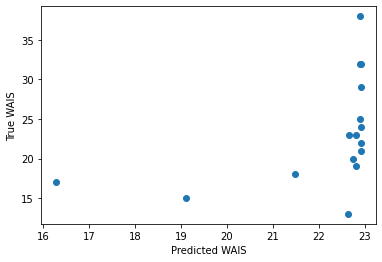

In [10]:
# Plot example test/predicted

len(ypredc)
len(ytestc)

a=ypredc[9]
b=ytestc[9]

print(explained_variance_score(b,a))
plt.scatter(a,b)
plt.xlabel('Predicted WAIS')
plt.ylabel('True WAIS')

In [4]:
# -------- assessing model weights and features selected -----------
results_dir='/home/ubuntu/cognition_iowa/results/enhanced1/'
shape=[]
alldice=[]
alldicestd=[]
allalldice=[]
numfeatures=[]
countweights=np.zeros(shape=(3192, 1), dtype='int')
for p in range(0,100):
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
        
    # calculate the dice coefficient
    dice=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one=feats[x]
            two= feats[y]
            test=np.intersect1d(one,two)
            dice[x,y]=2*(test.shape[0]/(one.shape[0]+two.shape[0]))
    
    for x in range(0,5):
        numfeatures.append(feats[x].shape[0])
        
    dice=dice[np.triu_indices(5,k=1)] # only calcualting mean/std across 10 unique comparisons
    allalldice.append(dice)
    alldice.append(np.mean(dice))
    alldicestd.append(np.std(dice))
    
    # count how many times a feature shows up? max 5 per thing.
    for k in range(0, 3192):
        for x in range(0,5):
            if np.isin(k, feats[x]):
                countweights[k] = countweights[k] +1
                


Text(0, 0.5, 'Count')

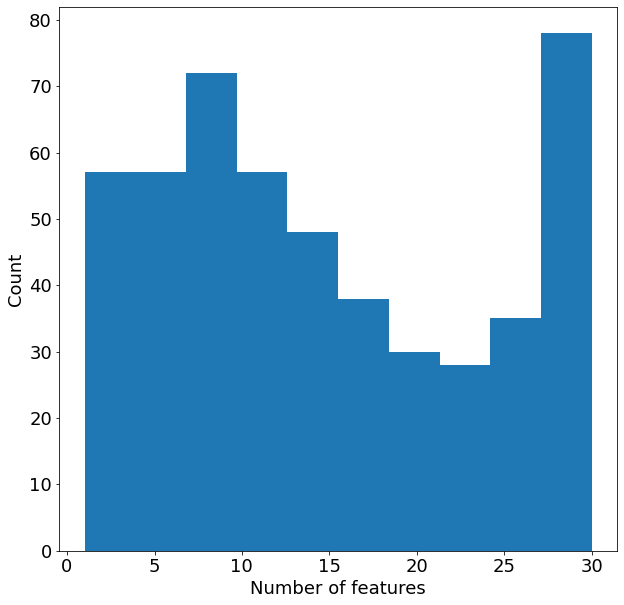

In [6]:
plt.figure(figsize=(10,10))
plt.hist(numfeatures)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of features', fontsize=18)
plt.ylabel('Count',fontsize=18)

In [7]:
alldice_null=[]
alldice_nullstd=[]
allalldice_null=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3193, size=(1,30))
            two =  np.random.randint(0,3193, size=(1,30))
            test=np.intersect1d(one,two)
            dice_null[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null.append(np.mean(dice_null))
    alldice_nullstd.append(np.std(dice_null))
    allalldice_null.append(dice_null)

alldice_null2=[]
alldice_nullstd2=[]
allalldice_null2=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null2=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3193, size=(1,15))
            two =  np.random.randint(0,3193, size=(1,15))
            test=np.intersect1d(one,two)
            dice_null2[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null2.append(np.mean(dice_null2))
    alldice_nullstd2.append(np.std(dice_null2))
    allalldice_null2.append(dice_null2)


Text(0.5, 1.0, 'Proportion of outer folds including weight (x-axis)')

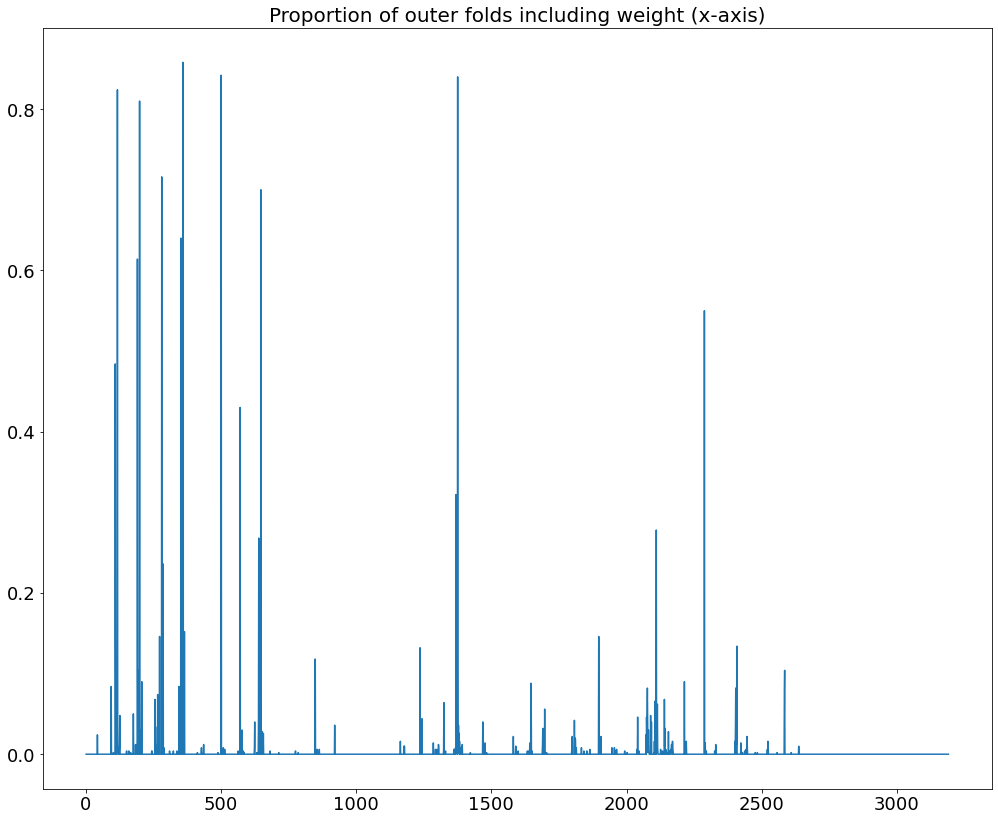

In [7]:
plt.figure(figsize=(17,14))

plt.plot(countweights/500)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of outer folds including weight (x-axis)', fontsize =20)


Text(0.5, 1.0, 'Number of times each SC edge was used in outer loop of cross-validation (max = 500)')

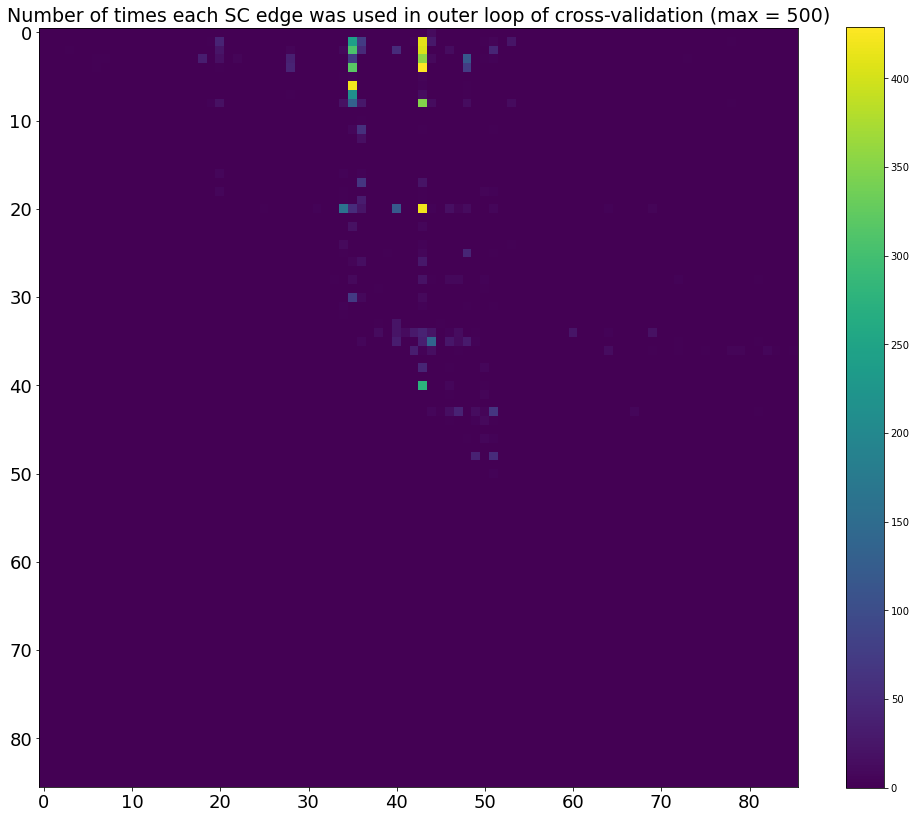

In [8]:
# convert vectorized Triu to matrix
highweights = countweights > 250

# get weights back to matrix form 86x86
# remove inputs that are 0 for all subjects
X=sc
zeros=X==0
zeros=np.sum(zeros,0) # number of zeros across subjects
zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
tmp=np.ones(shape=(3192, 1))

zeroidx=np.arange(0, 3655)
zeroidx=zeroidx[zeros]

# fill spots with 0's
k=0
cnt = countweights
while k < zeroidx.shape[0]:
    cnt=np.insert(cnt, zeroidx[k],0)
    tmp=np.insert(tmp, zeroidx[k],0)

    k=k+1
    
plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = cnt

plt.imshow(fs86_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


<Figure size 1224x1008 with 0 Axes>

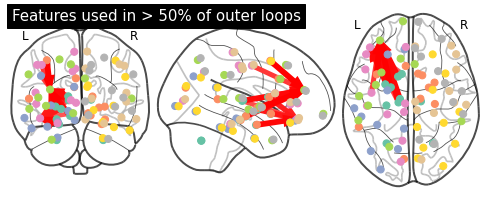

In [254]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(17,14))

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86_counts, coordinates,
                         edge_threshold=250,
                         title='Features used in > 50% of outer loops')

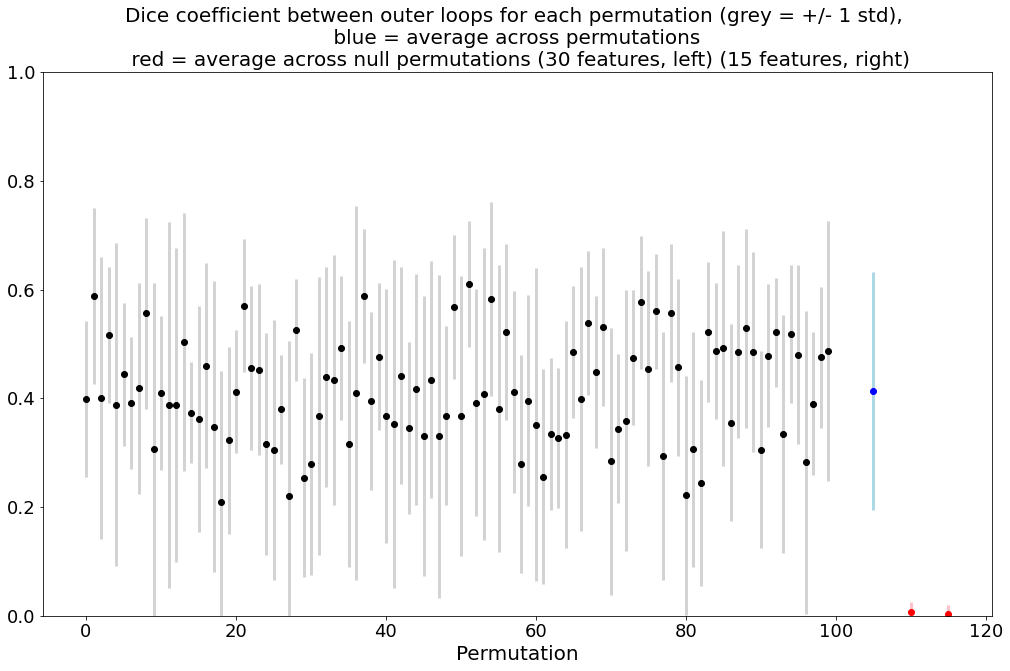

In [11]:
plt.figure(figsize=(17,10))
plt.errorbar(range(0,100), alldice, yerr=alldicestd, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

plt.ylim([0, 1])
plt.title('Dice coefficient between outer loops for each permutation (grey = +/- 1 std), \n blue = average across permutations \n red = average across null permutations (30 features, left) (15 features, right)' , fontsize=20)
plt.xlabel('Permutation', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.errorbar(105, np.mean(allalldice), yerr=np.std(allalldice), fmt='o', color='blue',
             ecolor='lightblue', elinewidth=3, capsize=0);

plt.errorbar(110, np.mean(allalldice_null), yerr=np.std(allalldice_null), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

plt.errorbar(115, np.mean(allalldice_null2), yerr=np.std(allalldice_null2), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

In [5]:
# Haufe transformation of feature weights
k=5
results_dir='/home/ubuntu/cognition_iowa/results/enhanced1/'
Y = np.array(wais)

# load activation weights
with open(results_dir + 'correlation' + 'p99_SC_varimpt.pkl', 'rb') as f:
    activ = pickle.load(f)

perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    k=5
    outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    activations=[]
    X=sc
    X=prepare_data(X)
    fullactivation=[]
    activationweight=[]
    for train, test in outer_cv.split(X, chronic_id):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        print(feats[c].shape[0])
        
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
    
        cov_y=np.cov(np.transpose(Y[train]))
    
        activationweight=activ[p][c]

        activationweight=activationweight[:,0:-1]# remove binary chronicity variable
        #print(activationweight.shape)
        weight=np.transpose(activationweight)

        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(3192,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 3192, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 3655)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 3655: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

Final size of X: (107, 3192)
22
28
29
14
5
Final size of X: (107, 3192)
11
30
7
13
30
Final size of X: (107, 3192)
21
30
19
16
2
Final size of X: (107, 3192)
9
17
6
29
29
Final size of X: (107, 3192)
1
8
10
30
8
Final size of X: (107, 3192)
8
16
22
13
3
Final size of X: (107, 3192)
18
25
26
3
9
Final size of X: (107, 3192)
29
19
10
2
22
Final size of X: (107, 3192)
11
8
8
29
6
Final size of X: (107, 3192)
6
13
1
13
11
Final size of X: (107, 3192)
28
30
5
13
27
Final size of X: (107, 3192)
30
8
24
6
8
Final size of X: (107, 3192)
15
1
10
25
12
Final size of X: (107, 3192)
8
15
9
21
13
Final size of X: (107, 3192)
26
7
4
27
28
Final size of X: (107, 3192)
3
3
11
23
7
Final size of X: (107, 3192)
17
20
3
24
18
Final size of X: (107, 3192)
1
30
30
10
21
Final size of X: (107, 3192)
23
10
1
1
14
Final size of X: (107, 3192)
9
5
17
2
3
Final size of X: (107, 3192)
27
8
4
9
26
Final size of X: (107, 3192)
14
19
6
9
9
Final size of X: (107, 3192)
11
16
4
24
6
Final size of X: (107, 3192)
16
5


In [7]:
countweights=np.zeros(shape=(3655, ), dtype='int')

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        #print(act[x].shape)
        countweights=countweights+act[x]

Text(0.5, 1.0, 'Sum of activations per feature across all folds')

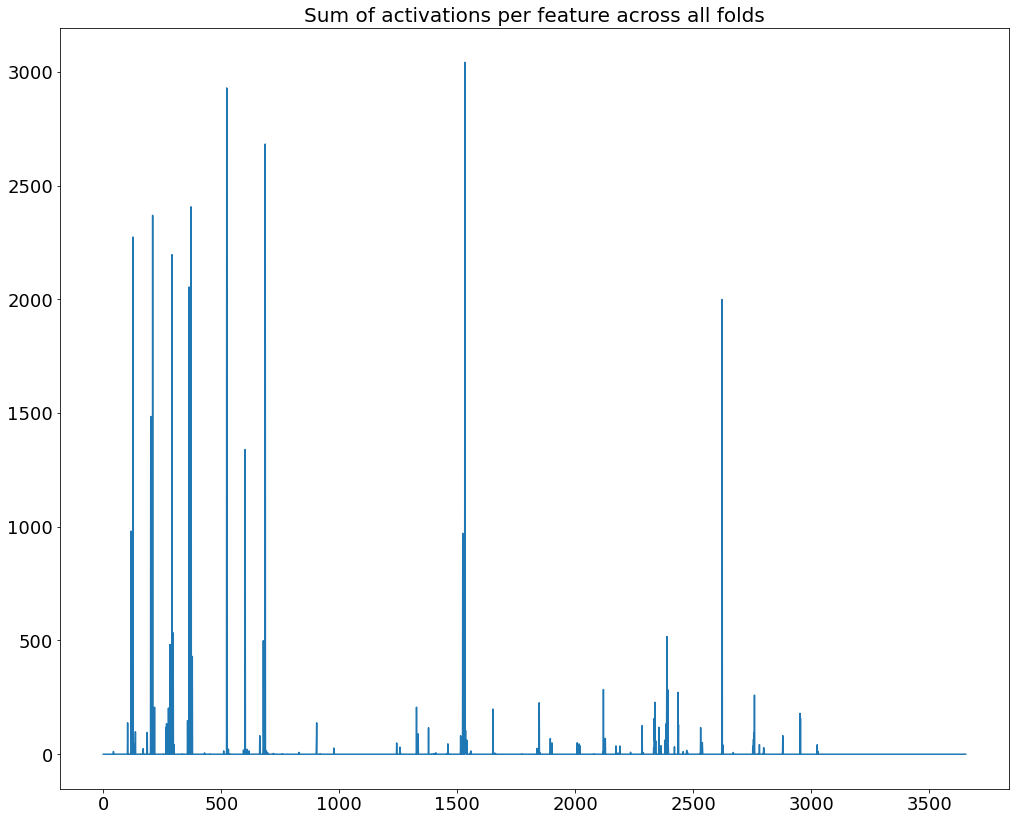

In [56]:
plt.figure(figsize=(17,14))

plt.plot(countweights)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Sum of activations per feature across all folds', fontsize =20)


Text(0.5, 1.0, 'Number of times each SC edge was used in outer loop of cross-validation (max = 500)')

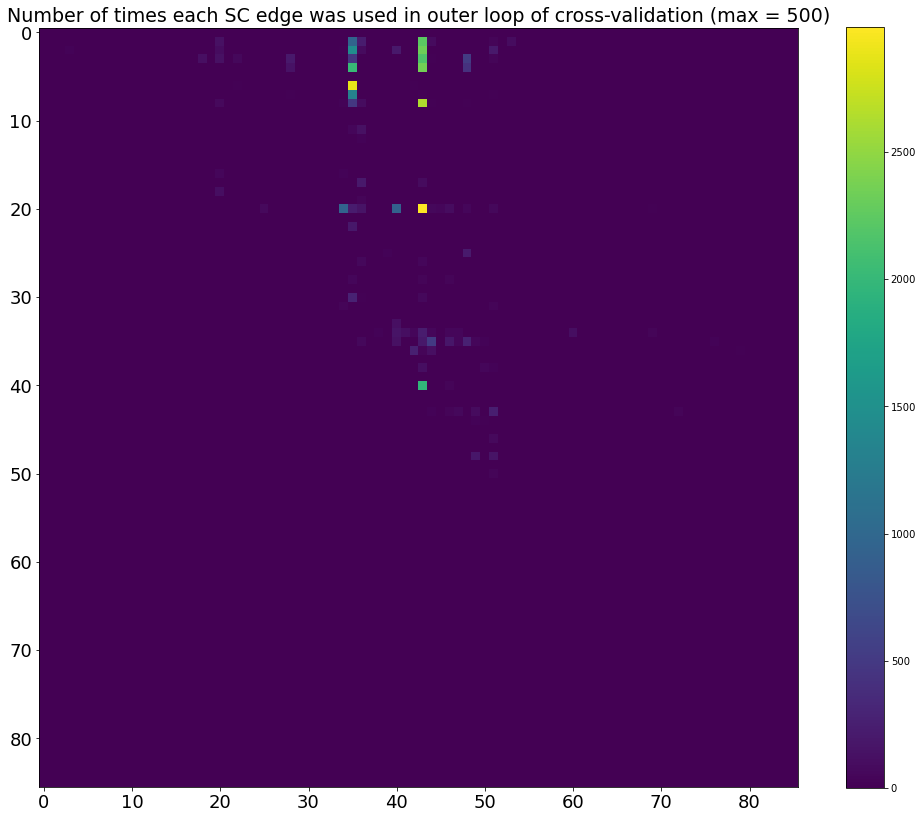

In [9]:
# convert vectorized Triu to matrix
highweights = countweights

plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = highweights

plt.imshow(fs86_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


<Figure size 1224x1008 with 0 Axes>

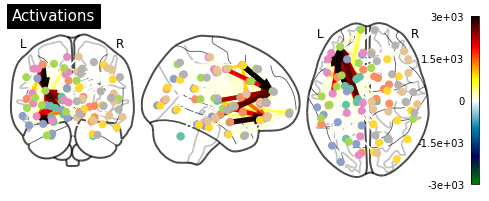

In [10]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(17,14))

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86_counts, coordinates,
                         title='Activations',edge_cmap='ocean_hot',colorbar=True)

In [12]:
results_dir

'/home/ubuntu/cognition_iowa/results/enhanced1/'

In [11]:
np.savetxt(results_dir +'fs86_activ_weights.txt', fs86_counts, delimiter=',')

In [26]:
Y_og=np.array(wais)
Y_og=np.reshape(Y_og, (107,1))

In [43]:
# Null models - shuffle cognitive scores
# permute the cognitive scores before splitting into train-test

# predictions for SC-  PCA and correlation

import datetime

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y_og=np.array(wais)
    Y_og=np.reshape(Y_og, (107,1))
    

    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=1
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        Y_og_chronic=Y_og[chronic_id]
        Y_og_acute=Y_og[acute_id]

        # permute chronic and acute separately
        Y_og_chronic_perm=np.random.permutation(Y_og_chronic)
        Y_og_acute_perm=np.random.permutation(Y_og_acute)

        Y_perm=np.zeros(shape=(107,1))
        # put chronic and acute back where they. belond
        Y_perm[chronic_id]=Y_og_chronic_perm
        Y_perm[acute_id]=Y_og_acute_perm
        
        Y=np.concatenate((Y_og_acute_perm, Y_og_chronic_perm))

        outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        cor=[]
        for train, test in outer_cv.split(X, chronic_id):
            begin_time = datetime.datetime.now()
            
            chronic_bin=chronic_id[train]
            chronic_test=chronic_id[test]
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, X[train], Y[train], chronic_bin, featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            
            chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
        
            chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
            chronicsubs_test=chronic_id[test]==True
            chronicsubs_train=chronic_id[train]==True
            chronicsubs_test=chronicsubs_test.flatten()
            chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

            ytrue_chronic = Ytest[chronicsubs_test]
            xtest_chronic=Xtest[chronicsubs_test]
     
            ychronic_pred = regr.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            print("Explained variance, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred)))
            chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred))
            
        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        chronic_allexpl_var.append(chronic_explvar)
        correlations.append(cor)
        print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar_null.txt', chronic_allexpl_var, delimiter=',')

        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar_null.txt', expl_var, delimiter=',')



Final size of X: (107, 3192)
Permutation: 0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:05.963470
R2 loop: -0.08342188195479916
Explained var: 0.0010654022476006553
correlation: [[0.19299453]]
Explained variance, chronic only:  0.0010798232322749568
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.763921
R2 loop: -0.0450739728476135
Explained var: -0.016262645932574094
correlation: [[-0.15114692]]
Explained variance, chronic only:  -0.011397071127254854
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.954408
R2 loop: -0.026267985407570693
Explained var: -0.02325364516363626
correlation: [[0.1266387]]
Explained variance, chronic only:  -0.027465353986188212
5-fold cross-validation results in 68.8 subjects in the training set, an

time to run loop: 0:00:04.873497
R2 loop: 0.04323584893942445
Explained var: 0.05201370108890824
correlation: [[0.34954609]]
Explained variance, chronic only:  0.004067693460518607
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.898427
R2 loop: 0.006472546104166144
Explained var: 0.10244966791256493
correlation: [[0.56820484]]
Explained variance, chronic only:  0.11372498872683878
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-7803d83fc20e>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:04.849235
R2 loop: -6.616736890693463
Explained var: -5.992304713360763
correlation: [[0.12829079]]
Explained variance, chronic only:  -7.536745567972595
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.984208
R2 loop: -0.08426192168351365
Explained var: -0.010252447229227135
correlation: [[-0.10559418]]
Explained variance, chronic only:  -0.010560100961813701
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.857032
R2 loop: -0.01133712372363549
Explained var: -0.009881287903630298
correlation: [[0.08547321]]
Explained variance, chronic only:  -0.028908072149277375
---- Permutation avg. chronic explained variance: -1.491684211779266----
---- Permutation avg. explained variance: -1.1715950158984296----
Permutation: 6
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0

time to run loop: 0:00:04.679114
R2 loop: -0.045457913880442735
Explained var: -0.01503087669518366
correlation: [[-0.21322631]]
Explained variance, chronic only:  -0.029667231819738404
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.692687
R2 loop: -0.019744093073861935
Explained var: 0.0856975285746231
correlation: [[0.3756601]]
Explained variance, chronic only:  0.07775581689874822
---- Permutation avg. chronic explained variance: 0.0050327065877323164----
---- Permutation avg. explained variance: 0.0185494034522236----
Permutation: 11
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.771764
R2 loop: -0.03448470618550581
Explained var: -0.028630352054019204
correlation: [[-0.06186325]]
Explained variance, chronic only:  0.017210610501565582
5-fold cross-validation results in 68.0 subjects in the training set, an

time to run loop: 0:00:04.767338
R2 loop: -0.1015979611264568
Explained var: -0.04282118934743129
correlation: [[-0.28403245]]
Explained variance, chronic only:  -0.038888929913007964
---- Permutation avg. chronic explained variance: -0.00309995776005727----
---- Permutation avg. explained variance: 0.00417210328180988----
Permutation: 16
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.939638
R2 loop: -0.0562617598562436
Explained var: -0.013175181821299509
correlation: [[-0.06459375]]
Explained variance, chronic only:  0.002012057353110386
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.894535
R2 loop: -0.019499085620690915
Explained var: -0.01557268474641793
correlation: [[0.02169628]]
Explained variance, chronic only:  -0.02528223350014902
5-fold cross-validation results in 68.8 subjects in the training set, a

time to run loop: 0:00:04.952296
R2 loop: -0.011485294271078361
Explained var: -0.00045690665201414404
correlation: [[-0.09269005]]
Explained variance, chronic only:  -0.0009193518517394139
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.929454
R2 loop: 0.005957357083748227
Explained var: 0.006099576486112146
correlation: [[0.07831618]]
Explained variance, chronic only:  0.0024605339664534043
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.775494
R2 loop: -0.013464621272688104
Explained var: 0.0003264798747494302
correlation: [[0.09161235]]
Explained variance, chronic only:  0.0003235257228910715
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.662372
R2 loop: -22.09509120877138
Explained var: -20.27148117682415
correlation: [[

time to run loop: 0:00:04.767307
R2 loop: -0.007778049829539002
Explained var: -0.006960894022485897
correlation: [[-0.24609322]]
Explained variance, chronic only:  0.00031414132175155984
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.984743
R2 loop: -0.4194425388583001
Explained var: -0.24556718483608764
correlation: [[0.36330863]]
Explained variance, chronic only:  -0.24623912767657208
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.857442
R2 loop: -0.016217778297153762
Explained var: -0.015605103691271882
correlation: [[-0.2487173]]
Explained variance, chronic only:  -0.02543761849877013
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.942250
R2 loop: -0.1276048144997295
Explained var: -0.011243262220092198
correlation: [[-

time to run loop: 0:00:04.729617
R2 loop: -0.13155920207896976
Explained var: -0.0867498089392198
correlation: [[-0.15616799]]
Explained variance, chronic only:  -0.08002837544305685
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.536519
R2 loop: -0.46843979501062116
Explained var: -0.456281262817144
correlation: [[0.11071401]]
Explained variance, chronic only:  -0.6214499314093003
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-7803d83fc20e>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:04.564075
R2 loop: -0.0012778225534042509
Explained var: 0.00018992743377088672
correlation: [[0.06245588]]
Explained variance, chronic only:  0.0
---- Permutation avg. chronic explained variance: -0.13991739034269376----
---- Permutation avg. explained variance: -0.10846763637258731----
Permutation: 32
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.730430
R2 loop: -0.010481850947057225
Explained var: -0.007273150575113352
correlation: [[-0.60112116]]
Explained variance, chronic only:  -0.009382680201146743
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.645433
R2 loop: -0.025980719589242085
Explained var: -0.0003026455514258952
correlation: [[-0.19900215]]
Explained variance, chronic only:  3.852716152330515e-06
5-fold cross-validation results in 68.8 subjects in the training set, and 17.

time to run loop: 0:00:04.644550
R2 loop: -0.08924628848944538
Explained var: -0.003469184073901843
correlation: [[-0.09237611]]
Explained variance, chronic only:  -0.00436239183453857
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.707677
R2 loop: -0.002821061345576803
Explained var: -0.0028075524980073485
correlation: [[-0.38856347]]
Explained variance, chronic only:  -0.0030694368322552457
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.725473
R2 loop: -0.04920271353364414
Explained var: -0.00010761133385139843
correlation: [[-0.02945354]]
Explained variance, chronic only:  2.153605369825673e-05
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.634217
R2 loop: -0.4599694153852196
Explained var: -0.004155681176039705
correlati

time to run loop: 0:00:04.554932
R2 loop: -0.01231924256550676
Explained var: -0.0011713926485255044
correlation: [[-0.13369502]]
Explained variance, chronic only:  -0.0014159994101810014
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.704187
R2 loop: -0.7621708083192007
Explained var: -0.622773546215684
correlation: [[-0.21100365]]
Explained variance, chronic only:  -0.9795899131793557
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.681470
R2 loop: 0.0013723994165788511
Explained var: 0.0013725152587427125
correlation: [[0.42835537]]
Explained variance, chronic only:  -3.188500354922574e-05
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.820866
R2 loop: -0.7075699755144207
Explained var: -0.7071944452803134
correlation: [[-0.

time to run loop: 0:00:04.839871
R2 loop: -0.008060811323208128
Explained var: 0.00042289660424210673
correlation: [[0.03781875]]
Explained variance, chronic only:  -0.0006218360553891245
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.872210
R2 loop: -0.019180245199866164
Explained var: -0.018419368256063384
correlation: [[-0.35653353]]
Explained variance, chronic only:  -0.03897761536773614
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.937710
R2 loop: -0.43650985928076436
Explained var: -0.024097377164171485
correlation: [[-0.02159026]]
Explained variance, chronic only:  -0.05349041315243985
---- Permutation avg. chronic explained variance: -0.03216925573224758----
---- Permutation avg. explained variance: -0.025304745245359174----
Permutation: 48
5-fold cross-validation results in 68.0 subjects in the traini

time to run loop: 0:00:04.939315
R2 loop: -0.17889923303102617
Explained var: 0.00046567628142979434
correlation: [[0.10238385]]
Explained variance, chronic only:  -1.1038537124585801e-05
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.820377
R2 loop: -0.028253344597294117
Explained var: -0.004757811831063163
correlation: [[-0.1885727]]
Explained variance, chronic only:  1.3654355611736335e-06
---- Permutation avg. chronic explained variance: 0.003260173513735043----
---- Permutation avg. explained variance: -0.0013042350371693435----
Permutation: 53
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.877211
R2 loop: -0.8374970851892516
Explained var: -0.8362442172509936
correlation: [[-0.2644785]]
Explained variance, chronic only:  -1.0511909282963217
5-fold cross-validation results in 68.0 subjects in the training 

time to run loop: 0:00:05.011965
R2 loop: -0.16776048425476175
Explained var: 0.0014790672241583591
correlation: [[0.05746661]]
Explained variance, chronic only:  -0.00069300893520019
---- Permutation avg. chronic explained variance: -0.06501837443298886----
---- Permutation avg. explained variance: -0.05835266582028873----
Permutation: 58
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.963533
R2 loop: -0.013387515475439704
Explained var: -0.0007355835327023108
correlation: [[-0.14198663]]
Explained variance, chronic only:  -0.0009123992822765992
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.966485
R2 loop: -0.25032401525419057
Explained var: -0.2230584298833045
correlation: [[-0.331336]]
Explained variance, chronic only:  -0.2029207017618917
5-fold cross-validation results in 68.8 subjects in the training set,

time to run loop: 0:00:05.076536
R2 loop: -0.04793779342349613
Explained var: -0.0005878852668872447
correlation: [[-0.10890091]]
Explained variance, chronic only:  0.0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:05.014518
R2 loop: -0.00754724728426992
Explained var: -0.00010866495326689041
correlation: [[-0.07312192]]
Explained variance, chronic only:  -2.220446049250313e-16
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:05.060955
R2 loop: -0.24210382119571694
Explained var: -0.004059674120141521
correlation: [[-0.2421052]]
Explained variance, chronic only:  -0.0051231142958561016
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:05.109061
R2 loop: -0.011275044239420495
Explained var: -0.0007962548727518115
correlation: [[-0.097758

time to run loop: 0:00:05.123504
R2 loop: -0.2119928626305665
Explained var: -0.0004674132687536581
correlation: [[-0.00624006]]
Explained variance, chronic only:  -0.005021028724247811
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:05.184081
R2 loop: -0.29269630531001
Explained var: -0.003787710158650981
correlation: [[-0.05976302]]
Explained variance, chronic only:  -0.00802199420966132
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:05.208095
R2 loop: -0.0011824195614598132
Explained var: 0.0013966354495775768
correlation: [[0.17402397]]
Explained variance, chronic only:  0.0014863667834426053
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:05.149190
R2 loop: -0.5681308527704956
Explained var: -0.29693356415724126
correlation: [[0.

time to run loop: 0:00:04.978936
R2 loop: -0.791748420099984
Explained var: -0.5598767464015297
correlation: [[0.01736701]]
Explained variance, chronic only:  -0.45988218007079085
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.919212
R2 loop: -0.01598288112830204
Explained var: 0.0017427817618981267
correlation: [[0.32357327]]
Explained variance, chronic only:  0.00215817867740542
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.751964
R2 loop: -0.00580582238802263
Explained var: -0.005803371588035011
correlation: [[-0.15385374]]
Explained variance, chronic only:  -2.7009520381593433e-05
---- Permutation avg. chronic explained variance: -0.08950853975905984----
---- Permutation avg. explained variance: -0.11172245182103187----
Permutation: 74
5-fold cross-validation results in 68.0 subjects in the training set, a

time to run loop: 0:00:04.846748
R2 loop: -0.13102076079423974
Explained var: 0.0026773020621718713
correlation: [[0.25404798]]
Explained variance, chronic only:  0.0019892024924217377
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.745183
R2 loop: -0.011430138182609406
Explained var: -0.00011645147814953738
correlation: [[-0.03861626]]
Explained variance, chronic only:  -4.635749728576499e-05
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.941964
R2 loop: -0.08312143995032173
Explained var: -0.0014329318242798372
correlation: [[-0.03180912]]
Explained variance, chronic only:  -0.001846127012299803
---- Permutation avg. chronic explained variance: -0.006553596270021833----
---- Permutation avg. explained variance: 0.0008875936610753587----
Permutation: 79
5-fold cross-validation results in 68.0 subjects in the tr

time to run loop: 0:00:04.659720
R2 loop: -0.24313348740802398
Explained var: -0.1574582568308056
correlation: [[-0.21264572]]
Explained variance, chronic only:  -0.19182244802683845
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.679216
R2 loop: -0.11987566946091666
Explained var: 0.019512524705194156
correlation: [[0.16807575]]
Explained variance, chronic only:  0.03182885665973756
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.614964
R2 loop: -0.045850356226990296
Explained var: -0.04328519044049317
correlation: [[-0.20500387]]
Explained variance, chronic only:  -0.04852779464951196
---- Permutation avg. chronic explained variance: -0.04256754264254157----
---- Permutation avg. explained variance: -0.03736684298145652----
Permutation: 84
5-fold cross-validation results in 68.0 subjects in the training set, an

time to run loop: 0:00:04.850462
R2 loop: -0.02041831541007566
Explained var: -0.001019149858386914
correlation: [[-0.23947721]]
Explained variance, chronic only:  -8.085207183428089e-05
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.973300
R2 loop: -0.010357944295104726
Explained var: -0.0031108758048568053
correlation: [[-0.28849432]]
Explained variance, chronic only:  -0.0019294273632430858
---- Permutation avg. chronic explained variance: -0.0042834887908052895----
---- Permutation avg. explained variance: -0.012227680279439346----
Permutation: 89
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.939514
R2 loop: -0.03271215859117449
Explained var: 6.025383056107447e-05
correlation: [[0.23072927]]
Explained variance, chronic only:  5.4290864978878695e-05
5-fold cross-validation results in 68.0 subjects in the t

time to run loop: 0:00:04.654130
R2 loop: -0.03693014296198793
Explained var: -0.005178348167271807
correlation: [[-0.3406956]]
Explained variance, chronic only:  -0.005839085517649112
---- Permutation avg. chronic explained variance: -0.008589892785376984----
---- Permutation avg. explained variance: -0.009532236363282886----
Permutation: 94
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.678482
R2 loop: -0.03641489992287417
Explained var: 0.0017025109718514786
correlation: [[0.536429]]
Explained variance, chronic only:  0.0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.894801
R2 loop: -0.22454471290052336
Explained var: -0.0007704396971910388
correlation: [[-0.00419391]]
Explained variance, chronic only:  0.0024201711557637617
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

time to run loop: 0:00:04.671342
R2 loop: -0.07440419069152182
Explained var: -0.0014425289482447035
correlation: [[-0.16279095]]
Explained variance, chronic only:  -0.0019920590056887733
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:04.749224
R2 loop: -0.008021185181718016
Explained var: 0.0037468259113337954
correlation: [[0.15652029]]
Explained variance, chronic only:  -0.00028914572545146733
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.603347
R2 loop: -0.011243684629591133
Explained var: -0.0017644784496089194
correlation: [[-0.20358898]]
Explained variance, chronic only:  -0.0006677429248793665
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:04.700449
R2 loop: -0.09359366455453855
Explained var: 0.0003676701462260734
corre

Final size of X: (107, 1)


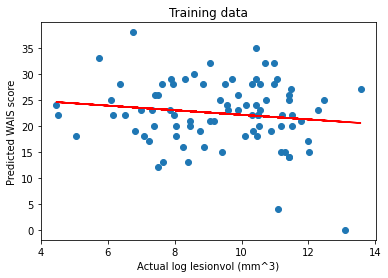

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


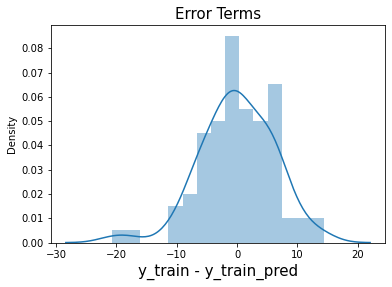

Verify that mean of residuals is zero. 
 Mean of error terms: -6.771054305478601e-15
Permutation-avg 


In [5]:
import statsmodels.api as sm

# Simple linear model - using lesion volume to predict cognitive scores

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=lesionvol
X=prepare_data(X)
train_size=0.8

#set y to be the measure you want to predict
Y = np.array(wais)

# split data into train/test
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=41)

x_sm = sm.add_constant(x)
lr = sm.OLS(y, x_sm).fit()

lr.summary()
plt.scatter(x, y)
pms=lr.params

plt.plot(x, pms[0] + pms[1]*x, 'r')
plt.xlabel('Actual log lesionvol (mm^3)')
plt.ylabel('Predicted WAIS score')
plt.title('Training data')
plt.show()

# Predicting y_value using training data of X
y_train_pred = lr.predict(x_sm)

# Creating residuals from the y_train data and predicted y_data
res = (y - y_train_pred)

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

print('Verify that mean of residuals is zero. \n Mean of error terms: ' + str(np.mean(res)))
k=5
rsqs=[]
for p in range(0,100):
    # split data into train/test
    outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
    
    for train, test in outer_cv.split(X, chronic_id):

        chronic_bin=chronic_id[train]
        chronic_test=chronic_id[test]
        
        x_train=X[train]
        x_test=X[test]
        y_train=Y[train]
        y_test=Y[test]

        # add constant to data
        x_sm = sm.add_constant(x_train)

        # fit on training data
        lr = sm.OLS(y_train, x_sm).fit()

        # Adding a constant to X_test
        X_test_sm = sm.add_constant(x_test)

        # Predicting the y values corresponding to X_test_sm 
        y_test_pred = lr.predict(X_test_sm)

        # Checking the R-squared value for chronic only
        y_test_pred_chronic=y_test_pred[chronic_test]
        y_test_chronic=y_test[chronic_test]
        r_squared = explained_variance_score(y_test, y_test_pred)
        #print('R-squared: ' + str(r_squared))
        rsqs.append(r_squared)

print("Permutation-avg ")
results_dir='/home/ubuntu/cognition_iowa/results/lesionvol/'

np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')


-0.0185703161264231

In [55]:
# Using PCA of the lesion in MNi space to predict cognitive scores.
results_dir='/home/ubuntu/cognition_iowa/results/lesionpc/'
import datetime
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(pc_lesion)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)
Y=np.reshape(Y, (107,1))

# feature selection type
featselect='correlation'

# range of alphas
n_alphas=20
alpha_start=-3
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

#number of features (# pricipal components or variables to retain)
feat_start=1
feat_end=50
n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]
allexpl_var=[]
correlations=[]
chronic_allexpl_var=[]
#joblib-based parallelism to increase speed,
ytestc=[]
ypredc=[]
for p in range(0, 100):
    outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    featur=[]
    best_alphas=[]
    impt=[] 
    expl_var=[]
    chronic_explvar=[]
    cor=[]
    for train, test in outer_cv.split(X, chronic_id):

        chronic_bin=chronic_id[train]
        chronic_test=chronic_id[test]

        print(X[train].shape)
        print(Y[train].shape)
        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, X[train], Y[train], chronic_bin, featselect, alphas, feats)

        # using optimal num. of features, select final features using entire training data.

        if featselect=='correlation':
            x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
            featur.append(ind)

        elif featselect=='PCA':
            x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
            featur.append(ind)


        chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
        x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)

        chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
        x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        expl_var.append(explained_variance_score(Y[test], y_pred))

        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
        print("R2 loop: " + str(r2_score(Y[test], y_pred)))
        print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
        print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        chronicsubs_test=chronic_id[test]==True
        chronicsubs_train=chronic_id[train]==True
        chronicsubs_test=chronicsubs_test.flatten()
        chronicsubs_train=chronicsubs_train.flatten()
        cor.append(np_pearson_cor(Y[test], y_pred))
        Xtest=x_test_featureselect
        Xtrain=X[train]
        Ytest=Y[test]

        ytrue_chronic = Ytest[chronicsubs_test]
        xtest_chronic=Xtest[chronicsubs_test]

        ytestc.append(ytrue_chronic)

        ychronic_pred = regr.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
        print("Explained variance, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred)))
        ypredc.append(ychronic_pred)

        chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred))
     
    # store results for each permutation p
    features.append(featur)
    allexpl_var.append(expl_var)
    bestalphas.append(best_alphas)
    importance.append(impt)
    chronic_allexpl_var.append(chronic_explvar)
    correlations.append(cor)
    print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
    np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')

    print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
    np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

    output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
    pickle.dump(featur, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
    pickle.dump(correlations, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
    pickle.dump(best_alphas, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
    pickle.dump(importance, output)
    output.close()   


Final size of X: (107, 106)
Permutation: 0
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:16:27.805231
R2 loop: 0.08578359810366287
Explained var: 0.09430030410292856
correlation: [[0.54254654]]
Explained variance, chronic only:  0.0810073208368366
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:16:30.154603
R2 loop: -0.04109013895669045
Explained var: -0.039415485489696866
correlation: [[0.05648275]]
Explained variance, chronic only:  -0.030364759776249084
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:16:32.597793
R2 loop: 0.2561056363741715
Explained var: 0.2670349280646057
correlation: [[0.70979413]]
Explained variance, chronic only:  0.2920348412444914
(86, 106)
(86, 1)
5-fold cross-v

time to run loop: 0:17:23.892466
R2 loop: -0.05016918957976646
Explained var: -0.04577701849272908
correlation: [[-0.34212202]]
Explained variance, chronic only:  -0.01618508610185332
---- Permutation avg. chronic explained variance: 0.040130614709135724----
---- Permutation avg. explained variance: 0.03463666953798965----
Permutation: 5
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:17:26.390160
R2 loop: 0.06909124619691032
Explained var: 0.07059239770229198
correlation: [[0.27866509]]
Explained variance, chronic only:  -0.03646622629024665
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:17:28.829581
R2 loop: -0.3916955665956052
Explained var: 0.00986704247723258
correlation: [[0.10928063]]
Explained variance, chronic only:  -0.004552262631129844
(86, 106)
(86, 1)
5-fold cross-validation

time to run loop: 0:18:18.021145
R2 loop: -0.17957300584742542
Explained var: -0.16893777959657275
correlation: [[-0.38633615]]
Explained variance, chronic only:  -0.16456773506324973
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:18:20.150005
R2 loop: -0.11933082619972835
Explained var: -0.02056574462504379
correlation: [[0.02715952]]
Explained variance, chronic only:  0.018036855114198058
---- Permutation avg. chronic explained variance: -0.1103133909841938----
---- Permutation avg. explained variance: -0.1579948410788709----
Permutation: 10
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:18:22.244189
R2 loop: -0.15713988225222275
Explained var: -0.12045584113037178
correlation: [[0.04706838]]
Explained variance, chronic only:  -0.021710563976002017
(85, 106)
(85, 1)
5-fold cross-valida

time to run loop: 0:19:14.341129
R2 loop: -0.12614090400589117
Explained var: -0.0996898205075114
correlation: [[-0.04643952]]
Explained variance, chronic only:  -0.09944568419848454
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:19:16.837605
R2 loop: 0.06746420783736551
Explained var: 0.08331584655785529
correlation: [[0.37247574]]
Explained variance, chronic only:  0.11033752722829493
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:19:19.282509
R2 loop: 0.2812711620734928
Explained var: 0.2880252733586517
correlation: [[0.71701228]]
Explained variance, chronic only:  0.3120875921053362
---- Permutation avg. chronic explained variance: -0.03235129262017191----
---- Permutation avg. explained variance: -0.0011168349646610621----
Permutation: 15
(85, 106)
(85, 1)
5-fold cross-validation re

time to run loop: 0:20:10.774519
R2 loop: -0.0037656660734872727
Explained var: 0.0026353657040600886
correlation: [[0.05882349]]
Explained variance, chronic only:  -0.03061009809056925
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:20:13.062006
R2 loop: -0.559567891387913
Explained var: -0.5586392549000334
correlation: [[-0.4582253]]
Explained variance, chronic only:  -0.5071596094412909
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:20:15.499634
R2 loop: 0.05370145510156721
Explained var: 0.10088220387085545
correlation: [[0.33187094]]
Explained variance, chronic only:  0.14363324966719737
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:20:17.654164
R2 loop: -0.0951736258049598
Explained

time to run loop: 0:21:03.845148
R2 loop: 0.2689674794157534
Explained var: 0.2696639324448623
correlation: [[0.60644599]]
Explained variance, chronic only:  0.27774101791387007
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:21:05.963360
R2 loop: -0.9437310959210259
Explained var: -0.0005923735042363543
correlation: [[0.01548891]]
Explained variance, chronic only:  0.03379951027535255
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:21:08.295086
R2 loop: -0.22825316874668355
Explained var: -0.0049329214348246
correlation: [[0.02948429]]
Explained variance, chronic only:  -0.034841671180888545
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:21:10.383014
R2 loop: 0.029762778298971337
Explained

time to run loop: 0:22:01.877153
R2 loop: 0.04054489887267165
Explained var: 0.09737944761005735
correlation: [[0.34016767]]
Explained variance, chronic only:  0.11384746305168936
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:22:04.350737
R2 loop: -0.26867279893543294
Explained var: -0.19121087103123435
correlation: [[-0.02549133]]
Explained variance, chronic only:  -0.38215064255803144
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:22:06.672588
R2 loop: -0.017377465109463364
Explained var: -0.015506873321735615
correlation: [[0.05362445]]
Explained variance, chronic only:  0.07270098315488505
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:22:08.934270
R2 loop: 0.0748480238339263
Explain

time to run loop: 0:23:00.604863
R2 loop: -0.026646386917970277
Explained var: -0.02505078720673537
correlation: [[-0.02954621]]
Explained variance, chronic only:  -0.012828941360540469
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:23:02.865855
R2 loop: 0.17198502440156893
Explained var: 0.17311674825464674
correlation: [[0.59404694]]
Explained variance, chronic only:  0.15852848724239021
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:23:05.244698
R2 loop: -0.3700649082545646
Explained var: -0.32546059846292175
correlation: [[-0.16630283]]
Explained variance, chronic only:  -0.3436088704235838
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:23:07.346637
R2 loop: 0.05429772795497234
Explai

time to run loop: 0:23:57.687359
R2 loop: 0.16176928127547585
Explained var: 0.16248514645771872
correlation: [[0.66851768]]
Explained variance, chronic only:  0.16109566399233277
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:24:00.086640
R2 loop: 0.17824143769159062
Explained var: 0.2177102694116132
correlation: [[0.70109299]]
Explained variance, chronic only:  0.24282248199215162
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:24:02.434278
R2 loop: -0.20103950908150425
Explained var: -0.19735057791912758
correlation: [[-0.16997517]]
Explained variance, chronic only:  -0.20207175883844353
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:24:04.899259
R2 loop: -0.26444371295712465
Explained 

time to run loop: 0:24:56.337655
R2 loop: -0.28013449644334054
Explained var: -0.27646755516586285
correlation: [[-0.17610409]]
Explained variance, chronic only:  -0.1295887633334294
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:24:58.444918
R2 loop: 0.01609269434947569
Explained var: 0.01614223552268257
correlation: [[0.12707936]]
Explained variance, chronic only:  0.02123565531748295
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:25:00.774207
R2 loop: -0.2128671282337462
Explained var: 0.04712959475171563
correlation: [[0.24456931]]
Explained variance, chronic only:  0.03265774162281587
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:25:03.103587
R2 loop: -0.0369990812523362
Explained v

time to run loop: 0:25:53.384430
R2 loop: 0.05104524619216644
Explained var: 0.14579524272121314
correlation: [[0.54520187]]
Explained variance, chronic only:  0.225988394791374
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:25:55.570655
R2 loop: -0.9164144637972473
Explained var: -0.8816803134964706
correlation: [[-0.39825063]]
Explained variance, chronic only:  -0.30560530691510013
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:25:57.937482
R2 loop: 0.024570508126786406
Explained var: 0.11668262717363886
correlation: [[0.58300449]]
Explained variance, chronic only:  0.1430118910254049
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:26:00.648886
R2 loop: -0.0612236052311923
Explained var:

time to run loop: 0:26:52.192899
R2 loop: 0.03631049260142338
Explained var: 0.03663084242280523
correlation: [[0.23162165]]
Explained variance, chronic only:  0.06000657611696447
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:26:54.308500
R2 loop: -0.0011392997084069822
Explained var: 0.006644933968055877
correlation: [[0.12989642]]
Explained variance, chronic only:  0.007747465061057723
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:26:56.419412
R2 loop: 0.01982333565398775
Explained var: 0.06297568595589653
correlation: [[0.30235591]]
Explained variance, chronic only:  0.015004013775704816
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:26:58.525765
R2 loop: 0.12797071973952867
Explaine

time to run loop: 0:27:50.090509
R2 loop: -0.12303871999472848
Explained var: -0.006478430181063866
correlation: [[0.0723043]]
Explained variance, chronic only:  -0.051933019322731644
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:27:52.197829
R2 loop: -0.030980999223666705
Explained var: 0.007433178773319171
correlation: [[0.09538558]]
Explained variance, chronic only:  0.014779115921294439
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:27:54.300677
R2 loop: -0.07843011320800808
Explained var: -0.021943803590288136
correlation: [[0.12093562]]
Explained variance, chronic only:  0.1702688678833939
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:27:56.690345
R2 loop: -0.16874043080632184
Exp

time to run loop: 0:28:46.700548
R2 loop: -0.04340791970895497
Explained var: -0.006314121222589897
correlation: [[0.10116759]]
Explained variance, chronic only:  -0.08024863468355514
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:28:49.047839
R2 loop: -0.24352674978666244
Explained var: -0.13594030862105866
correlation: [[-0.15558557]]
Explained variance, chronic only:  -0.1553893236494175
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:28:51.409614
R2 loop: -0.0003093737723334211
Explained var: 0.0007288481164299254
correlation: [[0.04792651]]
Explained variance, chronic only:  -0.013578114132700714
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:28:53.762740
R2 loop: -0.10905927244662994

time to run loop: 0:29:43.829045
R2 loop: 0.009891958624563157
Explained var: 0.027932747552097292
correlation: [[0.23482759]]
Explained variance, chronic only:  0.019283237359776995
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:29:45.929892
R2 loop: 0.02428597753472772
Explained var: 0.04178824296801242
correlation: [[0.21026575]]
Explained variance, chronic only:  0.05559271343192773
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:29:48.028073
R2 loop: -0.03460603072094903
Explained var: 0.016169209547134966
correlation: [[0.1271729]]
Explained variance, chronic only:  -0.04175406744032606
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:29:50.129647
R2 loop: -0.08055871832528516
Explaine

time to run loop: 0:30:41.776748
R2 loop: 0.13033824068097577
Explained var: 0.13180496510662987
correlation: [[0.44765496]]
Explained variance, chronic only:  0.13033374387838115
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:30:44.167985
R2 loop: 0.00012670278940196678
Explained var: 0.04248911762402097
correlation: [[0.615577]]
Explained variance, chronic only:  0.03326955730348635
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:30:46.643467
R2 loop: -0.12486975537659939
Explained var: -0.12034784895723094
correlation: [[-0.19695484]]
Explained variance, chronic only:  -0.1429439598249147
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:30:48.836865
R2 loop: 0.07826149333046062
Explained 

time to run loop: 0:31:37.820925
R2 loop: -0.9766794543904647
Explained var: -0.8424810447385216
correlation: [[-0.31095651]]
Explained variance, chronic only:  -1.000641161011143
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:31:40.216211
R2 loop: 0.16087018891385196
Explained var: 0.16350367174762448
correlation: [[0.6250996]]
Explained variance, chronic only:  0.13883728748164537
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:31:42.593999
R2 loop: -0.2727413171000237
Explained var: -0.25482360258535897
correlation: [[-0.12656383]]
Explained variance, chronic only:  0.05849465594637704
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:31:44.963701
R2 loop: 0.04003416815661731
Explained var

time to run loop: 0:32:37.421739
R2 loop: -0.08975869302990014
Explained var: -0.0859017577504595
correlation: [[0.00130547]]
Explained variance, chronic only:  -0.1945522048750632
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:32:39.860330
R2 loop: 0.02321491837998546
Explained var: 0.09595303605791994
correlation: [[0.42742337]]
Explained variance, chronic only:  0.10424799839076015
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:32:42.026629
R2 loop: 0.017803574464636873
Explained var: 0.020423512238219033
correlation: [[0.1941339]]
Explained variance, chronic only:  -0.0041821970944475595
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:32:44.448132
R2 loop: -0.04789653893083878
Explaine

time to run loop: 0:33:33.837785
R2 loop: 0.19073918719534066
Explained var: 0.2086139358895387
correlation: [[0.71305242]]
Explained variance, chronic only:  0.21005266631316455
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:33:35.943874
R2 loop: -0.23078994920484308
Explained var: 0.023797390743287128
correlation: [[0.21146987]]
Explained variance, chronic only:  0.04660547441569418
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:33:38.048659
R2 loop: -0.07008462318427533
Explained var: -0.06027581541412963
correlation: [[-0.24897044]]
Explained variance, chronic only:  0.03043804684987339
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:33:40.159466
R2 loop: -0.0035611851019801133
Explain

time to run loop: 0:34:30.118894
R2 loop: -0.1381891434337903
Explained var: 0.056708012232869254
correlation: [[0.29815339]]
Explained variance, chronic only:  0.05665791123569841
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:34:32.535391
R2 loop: -0.18225193113626248
Explained var: 0.09003251403653578
correlation: [[0.30163703]]
Explained variance, chronic only:  0.3297232237184059
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:34:34.908180
R2 loop: 0.05278013653104896
Explained var: 0.06775125043931862
correlation: [[0.32249141]]
Explained variance, chronic only:  0.10276024589773547
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:34:37.445368
R2 loop: -0.31253804699876864
Explained va

time to run loop: 0:35:27.444036
R2 loop: -0.23258846085510432
Explained var: -0.19598404854388396
correlation: [[-0.33897452]]
Explained variance, chronic only:  -0.20931304427949216
(85, 106)
(85, 1)
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:35:29.723295
R2 loop: -0.06132321514368866
Explained var: 0.02057889791149814
correlation: [[0.14704245]]
Explained variance, chronic only:  0.0012825428180769372
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:35:32.004292
R2 loop: -0.03808799966382437
Explained var: 0.030191923035315926
correlation: [[0.29149539]]
Explained variance, chronic only:  0.04642541053962068
(86, 106)
(86, 1)
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:35:34.497267
R2 loop: 0.017170990017889798
Expl

<AxesSubplot:xlabel='Cardiac_history', ylabel='Count'>

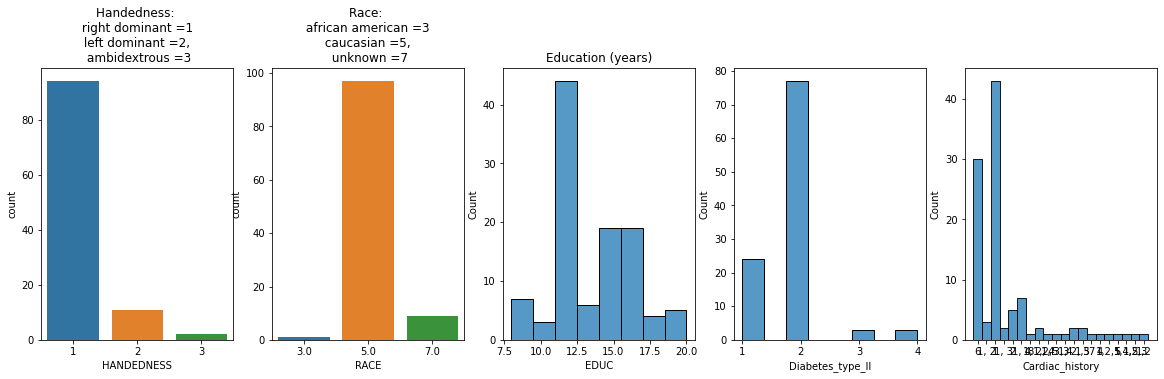

In [55]:
# 
fig, axes = plt.subplots(1, 5, sharex=False, figsize=(20,5))

axes[0].set_title('Handedness: \n right dominant =1 \n left dominant =2, \n ambidextrous =3')
axes[1].set_title('Race: \n african american =3 \n caucasian =5, \n unknown =7')
axes[2].set_title('Education (years)')

sns.countplot(x="HANDEDNESS", data=clin_vars, ax=axes[0])
#1. american indian, 2. asian, 3. african american, 5. caucasian, 6. other, 7. unknown, 8. native pacific islander
sns.countplot(x='RACE', data=clin_vars, ax=axes[1])
#level of education (years)
sns.histplot(x='EDUC', data=clin_vars,ax=axes[2])
#Yes =1, No =2, borderline =3, unknown=4
sns.histplot(x='Diabetes_type_II', data=clin_vars,ax=axes[3])

sns.histplot(x='Cardiac_history', data=new,ax=axes[4])


In [5]:
results_dir='/home/ubuntu/cognition_iowa/results/clin_vars/'

# predictions with clinical variables only

import datetime

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=np.array(clin_vars)
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(wais)
    Y=np.reshape(Y, (107,1))
    
    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=1
    feat_end=20
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        cor=[]
        for train, test in outer_cv.split(X, chronic_id):
            begin_time = datetime.datetime.now()
            
            chronic_bin=chronic_id[train]
            chronic_test=chronic_id[test]
            
            xtrain, xtest=scale_data(X[train,0:2], X[test,0:2])
            xtrain=np.hstack((xtrain, X[train,2:21]))
            xtest=np.hstack((xtest, X[test,2:21]))

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, xtrain, Y[train], chronic_bin, featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(xtrain,xtest, Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(xtrain,xtest, bestfeats)
                featur.append(ind)
                
            chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
        
            chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
            chronicsubs_test=chronic_id[test]==True
            chronicsubs_train=chronic_id[train]==True
            chronicsubs_test=chronicsubs_test.flatten()
            chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

            ytrue_chronic = Ytest[chronicsubs_test]
            xtest_chronic=Xtest[chronicsubs_test]
            
            ytestc.append(ytrue_chronic)
            
            ychronic_pred = regr.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            print("Explained variance, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred)))
            ypredc.append(ychronic_pred)

            chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred))
            
 
        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        chronic_allexpl_var.append(chronic_explvar)
        correlations.append(cor)
        print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')

        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(importance, output)
        output.close()   


Final size of X: (107, 21)
Permutation: 0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:02.007113
R2 loop: -0.20743356674430435
Explained var: -0.14230168370059926
correlation: [[-0.10895414]]
Explained variance, chronic only:  -0.0967515222054316
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.939912
R2 loop: 0.16651799063359773
Explained var: 0.1763260881519123
correlation: [[0.56715521]]
Explained variance, chronic only:  0.2903957449033935
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.887099
R2 loop: 0.11788844971614587
Explained var: 0.13068329474326135
correlation: [[0.48181386]]
Explained variance, chronic only:  0.14868205587708727
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.932265
R2 loop: -0.028943257502255015
Explained var: 0.07749339242426634
correlation: [[0.27840531]]
Explained variance, chronic only:  -0.04169585108078788
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.892083
R2 loop: 0.09811170590487284
Explained var: 0.1893307072173166
correlation: [[0.4486017]]
Explained variance, chronic only:  0.19173784793439141
---- Permutation avg. chronic explained variance: 0.09847365508573054----
---- Permutation avg. explained variance: 0.08630635976723147----
Permutation: 1
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.924731
R2 loop: 0.06032187151373847
Explained var: 0.06033998047444944
correlation: [[0.28309874]]
Explained variance, chronic only:  0.2690264222785411
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjec

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.123612
R2 loop: -0.017079352805611903
Explained var: -0.004100142944969853
correlation: [[0.23560437]]
Explained variance, chronic only:  0.007787787062605189
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.058221
R2 loop: 0.06026241312335201
Explained var: 0.1158382222549329
correlation: [[0.35414475]]
Explained variance, chronic only:  0.07257551423112474
---- Permutation avg. chronic explained variance: 0.07377965231298474----
---- Permutation avg. explained variance: 0.037951028489348324----
Permutation: 2
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.985661
R2 loop: -0.024714760614116482
Explained var: -0.013446823717519374
correlation: [[0.1437914]]
Explained variance, chronic only:  0.01410386484081605
5-fold cross-validation results in 68.0 subjects in the training set, and 17.

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.031077
R2 loop: 0.12878913304850537
Explained var: 0.1288988629176967
correlation: [[0.403626]]
Explained variance, chronic only:  0.07916873030727312
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.014804
R2 loop: -0.10756755839603449
Explained var: -0.10727600098764656
correlation: [[0.00778016]]
Explained variance, chronic only:  0.054062515170207326
---- Permutation avg. chronic explained variance: 0.0516128011459527----
---- Permutation avg. explained variance: 0.010426771137996971----
Permutation: 3
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.022645
R2 loop: -0.0029215503982622515
Explained var: 0.0067906853537185174
correlation: [[0.14781486]]
Explained variance, chronic only:  0.09843316617522713
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 s

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.017950
R2 loop: 0.08135388158809298
Explained var: 0.09617701859788363
correlation: [[0.3267378]]
Explained variance, chronic only:  0.08205964493315909
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.979448
R2 loop: 0.048123267827019145
Explained var: 0.10324476489655421
correlation: [[0.32522949]]
Explained variance, chronic only:  0.11314031787966516
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.968035
R2 loop: -0.048172968801395655
Explained var: 0.12230750868998275
correlation: [[0.35254884]]
Explained variance, chronic only:  0.04294337388201008
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.987297
R2 loop: 0.07707157452467028
Explained var: 0.08240191005022379
correlation: [[0.37395884]]
Exp

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.011186
R2 loop: -0.0316823971118918
Explained var: 0.01928136730805996
correlation: [[0.15477101]]
Explained variance, chronic only:  0.013821854321481197
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.983450
R2 loop: 0.09359708201400208
Explained var: 0.1102101112729501
correlation: [[0.35810605]]
Explained variance, chronic only:  0.09161426086764635
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.978602
R2 loop: -0.008124078464189388
Explained var: 0.027643619243661544
correlation: [[0.29515435]]
Explained variance, chronic only:  -0.055094007006213364
---- Permutation avg. chronic explained variance: 0.04461522272324969----
---- Permutation avg. explained variance: 0.06746979446467793----
Permutation: 5
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 s

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.028417
R2 loop: 0.1192079853553838
Explained var: 0.1315014930292716
correlation: [[0.36502185]]
Explained variance, chronic only:  0.08640944518409255
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.995343
R2 loop: -0.2662221895834962
Explained var: 0.11093245343340308
correlation: [[0.35327809]]
Explained variance, chronic only:  0.09335068761131404
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.916486
R2 loop: 0.09143964712448316
Explained var: 0.10973157978515968
correlation: [[0.5418485]]
Explained variance, chronic only:  0.1069129418840632
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.952415
R2 loop: -0.2624506602493044
Explained var: -0.24088846717280354
correlation: [[-0.20491333]]
Explain

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.027411
R2 loop: 0.05984081538873676
Explained var: 0.061921648149404485
correlation: [[0.35850461]]
Explained variance, chronic only:  0.04716559148902688
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.107682
R2 loop: 0.03097045881489635
Explained var: 0.04746707105506642
correlation: [[0.21956673]]
Explained variance, chronic only:  0.08262002666639678
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.061991
R2 loop: 0.10527506510646889
Explained var: 0.10545672779709514
correlation: [[0.3377863]]
Explained variance, chronic only:  0.07990179812864528
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.981113
R2 loop: 0.02749750556101982
Explained var: 0.030463529787595034
correlation: [[0.22244196]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.929229
R2 loop: -0.23274597950678988
Explained var: -0.21238039880862658
correlation: [[-0.21559824]]
Explained variance, chronic only:  -0.25140034485443885
---- Permutation avg. chronic explained variance: -0.03746979686408809----
---- Permutation avg. explained variance: -0.018526334314687955----
Permutation: 8
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.874015
R2 loop: -0.13822627652286323
Explained var: -0.10476439856843656
correlation: [[0.02211226]]
Explained variance, chronic only:  -0.11271696345970672
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.936447
R2 loop: -0.0193694098107009
Explained var: -0.012762753550121131
correlation: [[0.21909751]]
Explained variance, chronic only:  -0.012178106590294613
5-fold cross-validation results in 68.8 subjects in the training set, a

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.985027
R2 loop: -0.008644289095182778
Explained var: 0.004290781000881316
correlation: [[0.10133156]]
Explained variance, chronic only:  0.06893080452806732
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.996896
R2 loop: 0.004630792911107906
Explained var: 0.07460219923850797
correlation: [[0.28780302]]
Explained variance, chronic only:  0.07700702959779226
---- Permutation avg. chronic explained variance: 0.032070066900830405----
---- Permutation avg. explained variance: 0.019209119766539183----
Permutation: 9
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.983538
R2 loop: -0.009674547948856027
Explained var: 0.030915665129537917
correlation: [[0.26552997]]
Explained variance, chronic only:  0.04570445794180966
5-fold cross-validation results in 68.0 subjects in the training set, and 17

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.033617
R2 loop: -0.12682376010960383
Explained var: -0.06801132745518501
correlation: [[0.04103074]]
Explained variance, chronic only:  -0.049665783904602856
---- Permutation avg. chronic explained variance: 0.014306841065091969----
---- Permutation avg. explained variance: -0.028980877662442152----
Permutation: 10
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.896868
R2 loop: 0.15970854357322384
Explained var: 0.1619347691750893
correlation: [[0.41338428]]
Explained variance, chronic only:  0.13482266627666517
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.958502
R2 loop: -0.25797351404668944
Explained var: -0.08855088574951075
correlation: [[-0.065392]]
Explained variance, chronic only:  -0.07076833733221521
5-fold cross-validation results in 68.8 subjects in the training set, and 17

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.970813
R2 loop: -0.009779754913743055
Explained var: 0.022557591928628495
correlation: [[0.16038037]]
Explained variance, chronic only:  -0.00038032426776557493
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.976676
R2 loop: -0.1322351642146049
Explained var: 0.04067697081228416
correlation: [[0.20194004]]
Explained variance, chronic only:  0.026846359029842226
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.985015
R2 loop: -0.0033797209564649933
Explained var: 0.10244671528369098
correlation: [[0.32399985]]
Explained variance, chronic only:  0.07882625092548468
---- Permutation avg. chronic explained variance: 0.033869322926402254----
---- Permutation avg. explained variance: 0.04781303229003644----
Permutation: 11
5-fold cross-validation results in 68.0 subjects in the training set, an

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.971192
R2 loop: 0.13377559004331385
Explained var: 0.14247574963823517
correlation: [[0.4178115]]
Explained variance, chronic only:  0.2092820705460544
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.995593
R2 loop: 0.26585784921905675
Explained var: 0.29149322781485165
correlation: [[0.56345653]]
Explained variance, chronic only:  0.2573161653118511
---- Permutation avg. chronic explained variance: 0.10251890965684096----
---- Permutation avg. explained variance: 0.0767528485516629----
Permutation: 12
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.990719
R2 loop: -0.2723306735257931
Explained var: -0.22890253082206358
correlation: [[0.14589357]]
Explained variance, chronic only:  -0.22764874756352893
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subject

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.898360
R2 loop: 0.006872492711785472
Explained var: 0.03204519610286516
correlation: [[0.18547724]]
Explained variance, chronic only:  0.006134696129404205
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.879738
R2 loop: 0.047826366880002635
Explained var: 0.11301818245065964
correlation: [[0.33634236]]
Explained variance, chronic only:  0.051726064952130724
---- Permutation avg. chronic explained variance: 0.03501519873637171----
---- Permutation avg. explained variance: 0.03466981152913271----
Permutation: 13
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.914220
R2 loop: 0.039600882201611176
Explained var: 0.04202322130363567
correlation: [[0.20546019]]
Explained variance, chronic only:  -0.012818516699524496
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.014438
R2 loop: 0.18718933258745807
Explained var: 0.18852478559538477
correlation: [[0.49140623]]
Explained variance, chronic only:  0.2263502760652345
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.975446
R2 loop: 0.13184795672403804
Explained var: 0.1318855405377325
correlation: [[0.41140943]]
Explained variance, chronic only:  0.053773873459648125
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.014591
R2 loop: 0.0299053718964436
Explained var: 0.10238509961599052
correlation: [[0.32074691]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.966506
R2 loop: -0.06337631212497019
Explained var: 0.00734790148617781
correlation: [[0.2700602]]
Explained variance, chronic only:  -0.13989765322806913
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.071231
R2 loop: -0.09234135278516509
Explained var: -0.024138520818322906
correlation: [[0.08500456]]
Explained variance, chronic only:  0.032483551193741134
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.959929
R2 loop: -0.10429115522612986
Explained var: -0.018947252133707737
correlation: [[0.14401103]]
Explained variance, chronic only:  -0.15063709366528188
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.950798
R2 loop: 0.0852630317992783
Explained var: 0.10447709910920366
correlation: [[0.34250329

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.015947
R2 loop: -0.09693990900868732
Explained var: -0.08975361060624776
correlation: [[-0.13797999]]
Explained variance, chronic only:  -0.1354276166293229
---- Permutation avg. chronic explained variance: -0.026314644811570264----
---- Permutation avg. explained variance: -0.07078579419078686----
Permutation: 16
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.003235
R2 loop: -0.043426088982042144
Explained var: -0.02693632794076728
correlation: [[0.16398462]]
Explained variance, chronic only:  0.07476362501924727
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.992994
R2 loop: 0.0664008909802809
Explained var: 0.0771774405299468
correlation: [[0.47043184]]
Explained variance, chronic only:  0.05852320365502328
5-fold cross-validation results in 68.8 subjects in the training set, and 17.

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.994289
R2 loop: 0.003947321375742385
Explained var: 0.07733415934767907
correlation: [[0.33619577]]
Explained variance, chronic only:  0.06977821465513079
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.884786
R2 loop: 0.18929241083849868
Explained var: 0.19198578457845117
correlation: [[0.43817582]]
Explained variance, chronic only:  0.14393329594662752
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.885904
R2 loop: -0.20169495170005303
Explained var: -0.1862511520312644
correlation: [[-0.11598808]]
Explained variance, chronic only:  -0.2212889140665555
---- Permutation avg. chronic explained variance: 0.025141885041894674----
---- Permutation avg. explained variance: 0.026661980896809066----
Permutation: 17
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.005420
R2 loop: 0.019879321222111335
Explained var: 0.026538097874390876
correlation: [[0.17784008]]
Explained variance, chronic only:  0.12325492085536804
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.022539
R2 loop: 0.06402273050344609
Explained var: 0.14505657060823918
correlation: [[0.49711371]]
Explained variance, chronic only:  0.19137545702792114
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.986430
R2 loop: 0.03832178536464825
Explained var: 0.05190079795639835
correlation: [[0.23141858]]
Explained variance, chronic only:  -0.00943181059022069
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.053560
R2 loop: -0.1978385575380155
Explained var: 0.01031971858325953
correlation: [[0.17986091]]
Ex

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.951157
R2 loop: 0.07588623250588122
Explained var: 0.1006398409252186
correlation: [[0.32557195]]
Explained variance, chronic only:  0.12096440849199308
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.994363
R2 loop: -0.057322540535484245
Explained var: -0.03032268977026975
correlation: [[0.04808223]]
Explained variance, chronic only:  -0.051190643536241254
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.036759
R2 loop: 0.1292079691073713
Explained var: 0.21072537129318092
correlation: [[0.46376623]]
Explained variance, chronic only:  0.28926759566416704
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.963900
R2 loop: 0.1294284871494582
Explained var: 0.16184232133710408
correlation: [[0.4192501]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.084839
R2 loop: 0.11787348572624734
Explained var: 0.11827987095390202
correlation: [[0.35601232]]
Explained variance, chronic only:  0.12425954544198115
---- Permutation avg. chronic explained variance: -0.012190336996708639----
---- Permutation avg. explained variance: 0.024711474994914308----
Permutation: 20
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.983905
R2 loop: -0.18339493053423417
Explained var: -0.0547087128488819
correlation: [[0.00464428]]
Explained variance, chronic only:  -0.0641505389754482
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.035191
R2 loop: -0.011102749497473363
Explained var: 0.032105253566548586
correlation: [[0.19952212]]
Explained variance, chronic only:  -0.03153343527837249
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.887926
R2 loop: -0.435085995189161
Explained var: -0.2504248753839382
correlation: [[0.03593079]]
Explained variance, chronic only:  0.01082049387377193
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.881560
R2 loop: 0.2910049513652504
Explained var: 0.30351628843943346
correlation: [[0.63208091]]
Ex

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.995207
R2 loop: 0.15971593050802846
Explained var: 0.1621691811179099
correlation: [[0.51493324]]
Explained variance, chronic only:  0.1549116958427561
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.989352
R2 loop: -0.1730930119628682
Explained var: -0.17308684418698017
correlation: [[0.00072567]]
Explained variance, chronic only:  -0.11436901799530608
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.069382
R2 loop: -0.019953775240295846
Explained var: 0.06972399013108366
correlation: [[0.26578444]]
Explained variance, chronic only:  0.05740934275189624
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.097268
R2 loop: 0.03766532425658331
Explained var: 0.037739274080965224
correlation: [[0.21825478]]
Ex

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.018336
R2 loop: -0.03825136866717749
Explained var: -0.02633633389238743
correlation: [[0.19540534]]
Explained variance, chronic only:  -0.12039192833809476
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.008769
R2 loop: 0.10045276291204741
Explained var: 0.14631966191171397
correlation: [[0.61712247]]
Explained variance, chronic only:  0.12047749435503974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.876632
R2 loop: -0.042208589354186365
Explained var: 0.009289253764235839
correlation: [[0.19910118]]
Explained variance, chronic only:  -0.02319974866759078
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.969480
R2 loop: 0.12962891272782906
Explained var: 0.13360377380191235
correlation: [[0.37090441]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.928982
R2 loop: 0.020569421437618085
Explained var: 0.02405582372174986
correlation: [[0.15578844]]
Explained variance, chronic only:  0.049964629874093114
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.922421
R2 loop: 0.04286046590314574
Explained var: 0.16541959865316913
correlation: [[0.58532794]]
Explained variance, chronic only:  0.18264586034975505
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.973323
R2 loop: 0.014605735895433125
Explained var: 0.02700478248996674
correlation: [[0.17193091]]
Explained variance, chronic only:  -0.00017423694591078842
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.921017
R2 loop: -0.3680445084310482
Explained var: -0.2413268486106881
correlation: [[-0.1526877]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.942028
R2 loop: -1.1785693030672064
Explained var: -0.039081365950274005
correlation: [[0.13032144]]
Explained variance, chronic only:  -0.11028160365175688
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.071356
R2 loop: -0.10350174304919646
Explained var: 0.06330945054237058
correlation: [[0.26078676]]
Explained variance, chronic only:  0.11642152132718664
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.016187
R2 loop: 0.03814504460471302
Explained var: 0.07615784701409833
correlation: [[0.32322173]]
Explained variance, chronic only:  0.06496277401457096
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.960307
R2 loop: -0.23513270537157593
Explained var: 0.029092321216995898
correlation: [[0.31263308]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.985157
R2 loop: 0.07567149373621918
Explained var: 0.08230279673187524
correlation: [[0.29786224]]
Explained variance, chronic only:  0.07213170235210653
---- Permutation avg. chronic explained variance: 0.0469808891602427----
---- Permutation avg. explained variance: 0.03948214955398097----
Permutation: 26
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.082619
R2 loop: 0.05279956735864655
Explained var: 0.08485584806167223
correlation: [[0.29622244]]
Explained variance, chronic only:  0.0400657931257733
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.007946
R2 loop: 0.058728138807846664
Explained var: 0.05881793964463211
correlation: [[0.27130275]]
Explained variance, chronic only:  0.05780982714354288
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjec

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.014946
R2 loop: -0.11335238696737004
Explained var: 0.07302451649777608
correlation: [[0.28058705]]
Explained variance, chronic only:  0.16183333242382658
---- Permutation avg. chronic explained variance: 0.016246614577148755----
---- Permutation avg. explained variance: -0.0023204696837674454----
Permutation: 27
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.026662
R2 loop: -0.13659640778358462
Explained var: -0.08882141770064522
correlation: [[-0.01399428]]
Explained variance, chronic only:  -0.08158308194066088
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.006341
R2 loop: 0.13638559750904766
Explained var: 0.1556394412599218
correlation: [[0.4314069]]
Explained variance, chronic only:  0.17665162548616808
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.026280
R2 loop: 0.08460394257835357
Explained var: 0.09297189066388367
correlation: [[0.3240965]]
Explained variance, chronic only:  0.061305613921519786
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.991979
R2 loop: -0.09713994046933272
Explained var: -0.08104049566187843
correlation: [[0.0691095]]
Explained variance, chronic only:  -0.08257228973575348
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.011014
R2 loop: -0.24310406539494656
Explained var: -0.13186679618067165
correlation: [[0.06704197]]
Exp

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.063391
R2 loop: 0.09245058861302957
Explained var: 0.13056559233451392
correlation: [[0.36149576]]
Explained variance, chronic only:  0.06975338995479152
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.924281
R2 loop: -0.002352177306035985
Explained var: -0.002297935102809623
correlation: [[0.10388059]]
Explained variance, chronic only:  -0.10895236355025273
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.995073
R2 loop: 0.03435007524313527
Explained var: 0.047781059421518335
correlation: [[0.24635661]]
Explained variance, chronic only:  0.20454200871646866
---- Permutation avg. chronic explained variance: 0.06609439903811509----
---- Permutation avg. explained variance: 0.04644581409956487----
Permutation: 29
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.013629
R2 loop: -0.19975575634981535
Explained var: -0.19369415491214514
correlation: [[-0.0023133]]
Explained variance, chronic only:  -0.2025881244401888
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.977901
R2 loop: -0.0541933130412533
Explained var: 0.12257627906962176
correlation: [[0.4198948]]
Explained variance, chronic only:  0.1594020325545007
---- Permutation avg. chronic explained variance: 0.05286945562286076----
---- Permutation avg. explained variance: 0.06808395854652054----
Permutation: 30
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.108048
R2 loop: -0.0743066068078484
Explained var: -0.07348772875162757
correlation: [[0.10506034]]
Explained variance, chronic only:  -0.10267742675894764
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.008271
R2 loop: 0.054215913412468564
Explained var: 0.059403880240231355
correlation: [[0.49504801]]
Explained variance, chronic only:  0.038707002930199574
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.955108
R2 loop: 0.14529728703144618
Explained var: 0.15356768349809868
correlation: [[0.39199065]]
Explained variance, chronic only:  0.20681496258682164
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.894022
R2 loop: -0.0778227945072858
Explained var: -0.07720008047250837
correlation: [[-0.02377562]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.921251
R2 loop: 0.1612294605845741
Explained var: 0.18052459232463935
correlation: [[0.52224669]]
Explained variance, chronic only:  0.13703016041072502
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.011093
R2 loop: -0.107681379737111
Explained var: -0.03273401530199127
correlation: [[0.10593357]]
Explained variance, chronic only:  0.039831701113768214
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.980232
R2 loop: -0.15025223143539357
Explained var: -0.15025209145379503
correlation: [[0.01638837]]
Explained variance, chronic only:  -0.35171051160629574
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.951458
R2 loop: 0.190199951141228
Explained var: 0.19037743068587454
correlation: [[0.4959153]]
Expla

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.010939
R2 loop: 0.09209926347918729
Explained var: 0.10324440097400833
correlation: [[0.36298542]]
Explained variance, chronic only:  0.06869035479960306
---- Permutation avg. chronic explained variance: 0.07288637892803287----
---- Permutation avg. explained variance: -0.032374273988695766----
Permutation: 33
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.104510
R2 loop: 0.12110101856270106
Explained var: 0.13095541615937245
correlation: [[0.55400525]]
Explained variance, chronic only:  0.1094232426856061
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.914847
R2 loop: 0.00588053191486837
Explained var: 0.027443656897521485
correlation: [[0.19840941]]
Explained variance, chronic only:  0.10970295912491579
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.918061
R2 loop: -0.15242507100475433
Explained var: 0.07362423948184338
correlation: [[0.27135064]]
Explained variance, chronic only:  -0.03470230705940214
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.000788
R2 loop: -0.367967626109303
Explained var: 0.09887972361027941
correlation: [[0.32644808]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.896236
R2 loop: -0.011514061280823551
Explained var: 0.07183840193989688
correlation: [[0.26929609]]
Explained variance, chronic only:  0.05608043871708934
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.998300
R2 loop: -0.018497284910511613
Explained var: 0.028191006043800204
correlation: [[0.19961968]]
Explained variance, chronic only:  -0.053114933387105934
---- Permutation avg. chronic explained variance: 0.08585973063617847----
---- Permutation avg. explained variance: 0.08133539675054535----
Permutation: 35
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.049300
R2 loop: 0.11044248809792645
Explained var: 0.1496507617881322
correlation: [[0.40952756]]
Explained variance, chronic only:  0.07232778733567202
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.995064
R2 loop: -0.0010700433620418615
Explained var: 0.028080631725628136
correlation: [[0.17637003]]
Explained variance, chronic only:  0.016051829315550492
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.914150
R2 loop: 0.014099562485283657
Explained var: 0.03568815609749387
correlation: [[0.29300953]]
Explained variance, chronic only:  0.1850829223311824
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.958442
R2 loop: 0.129370800263788
Explained var: 0.2002802462864126
correlation: [[0.46283915]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.949900
R2 loop: -0.0006213416285598683
Explained var: 0.12617968508148014
correlation: [[0.35533944]]
Explained variance, chronic only:  0.15214736364569093
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.026202
R2 loop: -0.011611005115153006
Explained var: 0.04499816945555135
correlation: [[0.21378666]]
Explained variance, chronic only:  -0.018618534591476
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.018854
R2 loop: -0.10665170393723566
Explained var: -0.018213064588802563
correlation: [[0.21610844]]
Explained variance, chronic only:  -0.0181147518994218
---- Permutation avg. chronic explained variance: 0.08888343857866514----
---- Permutation avg. explained variance: 0.07677123679441382----
Permutation: 37
5-fold cross-validation results in 68.0 subjects in the training set, and 17.

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.964830
R2 loop: -0.42744763600162083
Explained var: -0.28162516028776796
correlation: [[-0.25374097]]
Explained variance, chronic only:  -0.10481505340253472
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.903802
R2 loop: -0.16610055366785748
Explained var: -0.14835225667698415
correlation: [[-0.05201799]]
Explained variance, chronic only:  0.020711038664277148
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.964781
R2 loop: -0.061306866782918856
Explained var: -0.016603395184480174
correlation: [[0.21429458]]
Explained variance, chronic only:  0.13164889652716139
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.999203
R2 loop: 0.007915699510215535
Explained var: 0.058367485847014566
correlation: [[0.24

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.982145
R2 loop: 0.02555560498697662
Explained var: 0.052885344708031634
correlation: [[0.26417937]]
Explained variance, chronic only:  0.05253326225776289
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.933698
R2 loop: -0.31900473881556657
Explained var: -0.02870922745113913
correlation: [[0.22441343]]
Explained variance, chronic only:  -0.10751823804890437
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.004542
R2 loop: 0.0071460211397911255
Explained var: 0.011215273442083729
correlation: [[0.16714868]]
Explained variance, chronic only:  0.059356641532936516
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.996322
R2 loop: 0.06846078828320079
Explained var: 0.07536922783330047
correlation: [[0.2964881]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.099036
R2 loop: 0.0927733033652971
Explained var: 0.09463911958436366
correlation: [[0.30764085]]
Explained variance, chronic only:  0.19191258363293762
---- Permutation avg. chronic explained variance: 0.06378826022793793----
---- Permutation avg. explained variance: 0.045878142076895445----
Permutation: 40
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.987758
R2 loop: 0.01215396141711933
Explained var: 0.013319060567056229
correlation: [[0.14234714]]
Explained variance, chronic only:  0.1809568024344841
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.993679
R2 loop: -0.08799118775200299
Explained var: 0.1771313730699836
correlation: [[0.60845062]]
Explained variance, chronic only:  0.17075672855682067
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.013527
R2 loop: -0.028615630638113343
Explained var: 0.07384468650565978
correlation: [[0.27486832]]
Explained variance, chronic only:  -0.00414695898311801
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.991974
R2 loop: -0.3807105627640135
Explained var: -0.23553743867809307
correlation: [[-0.03012197]]
Explained variance, chronic only:  -0.27129927079558347
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.081154
R2 loop: -0.2261687775624568
Explained var: -0.07924319969430771
correlation: [[0.00189908]]
Explained variance, chronic only:  -0.023247087119962595
---- Permutation avg. chronic explained variance: 0.010604042818528137----
---- Permutation avg. explained variance: -0.010097103645940231----
Permutation: 41
5-fold cross-validation results in 68.0 subjects in the training set, an

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.026573
R2 loop: 0.06713492383203001
Explained var: 0.1850233998657531
correlation: [[0.48923395]]
Explained variance, chronic only:  0.0773833992650198
---- Permutation avg. chronic explained variance: -0.02045723438788174----
---- Permutation avg. explained variance: 0.0113172477932858----
Permutation: 42
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.970070
R2 loop: 0.07983359879480012
Explained var: 0.07993783423359702
correlation: [[0.31382554]]
Explained variance, chronic only:  0.07832514431480853
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.925858
R2 loop: -0.09849117445097266
Explained var: -0.09569955090244964
correlation: [[0.13536996]]
Explained variance, chronic only:  0.027628642942861714
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.083114
R2 loop: 0.09729831794941024
Explained var: 0.10235011546568928
correlation: [[0.32112379]]
Explained variance, chronic only:  0.1403558279906727
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.964978
R2 loop: -0.13237600713104913
Explained var: 0.09333990035822426
correlation: [[0.30665651]]
Explained variance, chronic only:  0.16255919817613196
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.999712
R2 loop: -0.06387747865624016
Explained var: -0.014944989410727638
correlation: [[0.09378011]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.039077
R2 loop: -0.13264141953981556
Explained var: -0.07099983359388573
correlation: [[0.01157649]]
Explained variance, chronic only:  -0.014322163177773684
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.077002
R2 loop: -0.0021280974871180636
Explained var: 0.11344163242320593
correlation: [[0.35407324]]
Explained variance, chronic only:  0.0613579171733456
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.027221
R2 loop: -0.2368734156599468
Explained var: -0.22649998931096227
correlation: [[0.07008431]]
Explained variance, chronic only:  -0.3633155214522925
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.046528
R2 loop: 0.0789475548793892
Explained var: 0.07923190521028733
correlation: [[0.32407493]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.016583
R2 loop: 0.08927126081069547
Explained var: 0.09822209555990513
correlation: [[0.33106125]]
Explained variance, chronic only:  0.12836141277150148
---- Permutation avg. chronic explained variance: 0.046018836934734964----
---- Permutation avg. explained variance: 0.04957763998927298----
Permutation: 45
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.103309
R2 loop: 0.009327740885034075
Explained var: 0.009387493643390976
correlation: [[0.14602355]]
Explained variance, chronic only:  -0.042281360395527656
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.960518
R2 loop: 0.17391861255289232
Explained var: 0.23027016465847683
correlation: [[0.54361293]]
Explained variance, chronic only:  0.22917558125784898
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.916430
R2 loop: -0.011947858615915408
Explained var: 0.07406974600334049
correlation: [[0.27325281]]
Explained variance, chronic only:  0.05996698995579497
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.009228
R2 loop: 0.0046555295899957105
Explained var: 0.08378570415910502
correlation: [[0.32166248

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.040869
R2 loop: -0.20487556844018173
Explained var: -0.08200903675483984
correlation: [[-0.05191868]]
Explained variance, chronic only:  -0.16815182201507062
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.967025
R2 loop: -0.028661137870499953
Explained var: 0.10633684934167098
correlation: [[0.33350853]]
Explained variance, chronic only:  0.041788598245859454
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.050417
R2 loop: -0.1272227498170897
Explained var: 0.009666934544103278
correlation: [[0.26608217]]
Explained variance, chronic only:  -0.048121326761965566
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.015149
R2 loop: -0.01792888145768856
Explained var: 0.03161487387759199
correlation: [[0.18597

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.977312
R2 loop: -0.14811846882533675
Explained var: 0.0648580242328004
correlation: [[0.26831423]]
Explained variance, chronic only:  -0.003005984109976989
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.900099
R2 loop: -0.1846648338806196
Explained var: 0.10438067847506294
correlation: [[0.32583185]]
Explained variance, chronic only:  0.05774283092933796
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.940111
R2 loop: -0.20020265983769914
Explained var: -0.011373848055451052
correlation: [[0.08484791]]
Explained variance, chronic only:  -0.03322307046912987
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.988464
R2 loop: -0.06066881294528037
Explained var: 0.057142699984914946
correlation: [[0.23933986

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.949586
R2 loop: 0.29223273511664705
Explained var: 0.293144794348833
correlation: [[0.56270042]]
Explained variance, chronic only:  0.32412426692184804
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.067412
R2 loop: -0.010304868803968859
Explained var: 0.036105260716573384
correlation: [[0.19415135]]
Explained variance, chronic only:  0.05656519340038535
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.996771
R2 loop: 0.06586678782658195
Explained var: 0.0822748758168611
correlation: [[0.32087539]]
Explained variance, chronic only:  0.072991106381177
---- Permutation avg. chronic explained variance: 0.06398573815045953----
---- Permutation avg. explained variance: 0.035561835280913945----
Permutation: 49
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjec

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.992872
R2 loop: 0.09441017601180157
Explained var: 0.09697816977254203
correlation: [[0.31149426]]
Explained variance, chronic only:  0.061561960523206394
---- Permutation avg. chronic explained variance: 0.01841525424613093----
---- Permutation avg. explained variance: -0.0491091480140059----
Permutation: 50
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.903601
R2 loop: 0.04258007075806158
Explained var: 0.07498816014405585
correlation: [[0.28959693]]
Explained variance, chronic only:  0.13425595456990103
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.071634
R2 loop: -0.3650451402142727
Explained var: -0.36372988448792554
correlation: [[-0.24949972]]
Explained variance, chronic only:  -0.33106595472071887
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.928971
R2 loop: -0.14089487334364725
Explained var: -0.10442667814315199
correlation: [[0.17187888]]
Explained variance, chronic only:  -0.13904147712258297
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.008782
R2 loop: 0.06423061721629197
Explained var: 0.12240701634576223
correlation: [[0.35897977]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.018525
R2 loop: -0.498712640407299
Explained var: -0.33892516768920444
correlation: [[0.0072988]]
Explained variance, chronic only:  -0.2889015035730311
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.961912
R2 loop: 0.00784325806775732
Explained var: 0.05663197964047184
correlation: [[0.28358053]]
Explained variance, chronic only:  0.022538683530652914
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.983331
R2 loop: 0.07881487585013336
Explained var: 0.12676174833618692
correlation: [[0.57673146]]
Explained variance, chronic only:  0.17434808797033607
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.972275
R2 loop: 0.018721801418169814
Explained var: 0.032670491353814946
correlation: [[0.26090202]]
Exp

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.988426
R2 loop: 0.016234411294727025
Explained var: 0.06324267791732308
correlation: [[0.25477802]]
Explained variance, chronic only:  0.12389363853469282
---- Permutation avg. chronic explained variance: 0.08178579367232124----
---- Permutation avg. explained variance: 0.0659843793544153----
Permutation: 53
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.049937
R2 loop: -0.1253771068609486
Explained var: 0.002331645292600437
correlation: [[0.10146879]]
Explained variance, chronic only:  -0.08813682724849392
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.054886
R2 loop: -0.06179758414173153
Explained var: 0.07741204552403713
correlation: [[0.28286065]]
Explained variance, chronic only:  0.026227574026611467
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 s

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.003330
R2 loop: 0.15751770739243753
Explained var: 0.16792220906729782
correlation: [[0.40978612]]
Explained variance, chronic only:  0.20455595918714442
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.012342
R2 loop: 0.07224376477640904
Explained var: 0.07477579423490555
correlation: [[0.27502121]]
Explained variance, chronic only:  0.09467852565244073
---- Permutation avg. chronic explained variance: 0.08653464172453451----
---- Permutation avg. explained variance: 0.09406363580929544----
Permutation: 54
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.925132
R2 loop: -0.25473998977056445
Explained var: -0.2533879432371864
correlation: [[-0.23988025]]
Explained variance, chronic only:  -0.18211932806446685
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 su

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.005839
R2 loop: 0.09938243334007846
Explained var: 0.12735534309652685
correlation: [[0.39892643]]
Explained variance, chronic only:  0.20804664618708124
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.001163
R2 loop: 0.07201005170846031
Explained var: 0.08497044001213105
correlation: [[0.29233554]]
Explained variance, chronic only:  0.12733874896079933
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.017658
R2 loop: 0.024690466183393545
Explained var: 0.03178284004383991
correlation: [[0.17887242]]
Explained variance, chronic only:  0.02862869746526464
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.048008
R2 loop: 0.15359880085588273
Explained var: 0.15816669940292227
correlation: [[0.40323278]]
Expl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.932496
R2 loop: -0.050998785210312425
Explained var: 0.007440900181733046
correlation: [[0.16978531]]
Explained variance, chronic only:  -0.04046601912639236
---- Permutation avg. chronic explained variance: 0.001272006770236267----
---- Permutation avg. explained variance: 0.01630358604992399----
Permutation: 56
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.008144
R2 loop: -0.31061962408046506
Explained var: -0.30982689636520777
correlation: [[0.22142868]]
Explained variance, chronic only:  0.17635410549816977
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.999068
R2 loop: 0.10852013409238515
Explained var: 0.1101264193430227
correlation: [[0.55072446]]
Explained variance, chronic only:  0.12752611446169326
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.048344
R2 loop: -0.11317728182279763
Explained var: -0.0030237306733584823
correlation: [[0.2373939]]
Explained variance, chronic only:  -0.08842256376133584
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.953128
R2 loop: 0.08170995304299145
Explained var: 0.09842800661299056
correlation: [[0.33868035]]
Explained variance, chronic only:  0.09756223452845558
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.871347
R2 loop: -0.16041245496365053
Explained var: -0.13218879323600397
correlation: [[-0.16648613]]
Explained variance, chronic only:  -0.17625139420311453
---- Permutation avg. chronic explained variance: 0.02735369930477365----
---- Permutation avg. explained variance: -0.047296998863711394----
Permutation: 57
5-fold cross-validation results in 68.0 subjects in the training set, and 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.914446
R2 loop: 0.02325763703099315
Explained var: 0.02615368183263067
correlation: [[0.22201852]]
Explained variance, chronic only:  -0.044445083215713055
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.965147
R2 loop: 0.07724467915445044
Explained var: 0.07795775347601974
correlation: [[0.36000018]]
Explained variance, chronic only:  0.12748972725351337
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.920168
R2 loop: -0.023460735808543465
Explained var: 0.012488250793988964
correlation: [[0.11908223]]
Explained variance, chronic only:  -0.017473887041212555
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.913855
R2 loop: 0.053431893879504755
Explained var: 0.1571437691369144
correlation: [[0.41399448]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.011454
R2 loop: -0.4656592227875356
Explained var: 0.03800048143469992
correlation: [[0.19858919]]
Explained variance, chronic only:  -0.04384702085644432
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.033422
R2 loop: -0.33057343386704785
Explained var: -0.17528938185053677
correlation: [[-0.0989931]]
Explained variance, chronic only:  -0.044807774679948675
---- Permutation avg. chronic explained variance: 0.024801457534585136----
---- Permutation avg. explained variance: 0.0067544264271305774----
Permutation: 59
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.057561
R2 loop: 0.012705505585480226
Explained var: 0.09039608364610396
correlation: [[0.36000189]]
Explained variance, chronic only:  0.05345630886997932
5-fold cross-validation results in 68.0 subjects in the training set, and 1

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.002504
R2 loop: -0.10071239695368428
Explained var: -0.07432241747229651
correlation: [[0.04296245]]
Explained variance, chronic only:  -0.08728611257720198
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.991807
R2 loop: -0.1180229475803658
Explained var: -0.013358498055597856
correlation: [[0.16829171]]
Explained variance, chronic only:  0.08923302688975077
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.904081
R2 loop: -0.28838692007823297
Explained var: -0.09846152602412728
correlation: [[0.06824998]]
Explained variance, chronic only:  -0.1815835498871008
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.000164
R2 loop: 0.0861506591798692
Explained var: 0.16670517697090426
correlation: [[0.41499849]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.034459
R2 loop: -0.012706645090926783
Explained var: 0.03851809958055663
correlation: [[0.21107363]]
Explained variance, chronic only:  -0.10178091537245026
---- Permutation avg. chronic explained variance: 0.041682833849099675----
---- Permutation avg. explained variance: 0.033282632204781004----
Permutation: 61
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.042038
R2 loop: -0.21365391722625104
Explained var: -0.1583818335875684
correlation: [[-0.13348835]]
Explained variance, chronic only:  -0.23219686593758326
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.036507
R2 loop: -0.11703617874315908
Explained var: -0.11219297944545437
correlation: [[0.00247915]]
Explained variance, chronic only:  -0.0837291629298198
5-fold cross-validation results in 68.8 subjects in the training set, and 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.994577
R2 loop: -0.05289074783096903
Explained var: -0.04994943589991396
correlation: [[0.2533415]]
Explained variance, chronic only:  -0.08525865842830838
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.034110
R2 loop: -0.012089384883006815
Explained var: 0.11445793702627438
correlation: [[0.42660853]]
Explained variance, chronic only:  0.056455158172935005
---- Permutation avg. chronic explained variance: -0.04960057065168999----
---- Permutation avg. explained variance: -0.021170494928831763----
Permutation: 62
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.069709
R2 loop: -0.0036848644286766596
Explained var: -0.003677171597651796
correlation: [[0.1233261]]
Explained variance, chronic only:  -0.04972494786451476
5-fold cross-validation results in 68.0 subjects in the training set, a

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.038319
R2 loop: 0.11363134808907771
Explained var: 0.11542710946945334
correlation: [[0.39877899]]
Explained variance, chronic only:  0.04306282050147714
---- Permutation avg. chronic explained variance: 0.012035479310388907----
---- Permutation avg. explained variance: -0.000954632160736324----
Permutation: 63
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.037683
R2 loop: 0.08875928740941375
Explained var: 0.09126896511651716
correlation: [[0.38940084]]
Explained variance, chronic only:  0.13232337531119298
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.112590
R2 loop: 0.06268654577866539
Explained var: 0.06317531904463114
correlation: [[0.27901999]]
Explained variance, chronic only:  0.028552195869688046
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 s

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.995102
R2 loop: -0.1195218199401431
Explained var: -0.11785064622490693
correlation: [[-0.04589159]]
Explained variance, chronic only:  -0.08960874378327821
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.029120
R2 loop: 0.14440905705042373
Explained var: 0.1480829701530344
correlation: [[0.39553505]]
Explained variance, chronic only:  0.007753317945997651
---- Permutation avg. chronic explained variance: 0.029079135249747347----
---- Permutation avg. explained variance: 0.04812039069863905----
Permutation: 64
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.048585
R2 loop: -0.03230654513801401
Explained var: -0.01063817344836604
correlation: [[0.20078521]]
Explained variance, chronic only:  -0.018264211041918887
5-fold cross-validation results in 68.0 subjects in the training set, and 17

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.969105
R2 loop: -0.015530363963362603
Explained var: 0.045787083404596585
correlation: [[0.21413679]]
Explained variance, chronic only:  0.023246102425009685
---- Permutation avg. chronic explained variance: 0.048101495443889086----
---- Permutation avg. explained variance: 0.05469190561336672----
Permutation: 65
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.018927
R2 loop: -0.1336677226551386
Explained var: 0.02050776593576087
correlation: [[0.19867529]]
Explained variance, chronic only:  0.06607722496421797
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.950419
R2 loop: -0.01789486935784268
Explained var: 0.04109083949011272
correlation: [[0.20622758]]
Explained variance, chronic only:  0.04193690492024427
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.033733
R2 loop: 0.161095682826209
Explained var: 0.16620950175517324
correlation: [[0.4106292]]
Explained variance, chronic only:  0.2352317687293921
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.040468
R2 loop: 0.09715857604835454
Explained var: 0.09716998491244622
correlation: [[0.31332688]]
Explained variance, chronic only:  0.11223381411227917
---- Permutation avg. chronic explained variance: 0.08960427213412465----
---- Permutation avg. explained variance: 0.06275774418831759----
Permutation: 66
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.119058
R2 loop: -0.09693015102911806
Explained var: 0.02333990907534722
correlation: [[0.17733259]]
Explained variance, chronic only:  -0.08521172323579629
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subject

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.073135
R2 loop: -0.07219970595844472
Explained var: -0.07206191524169192
correlation: [[0.06938467]]
Explained variance, chronic only:  0.03247249086807602
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.984912
R2 loop: 0.045718712568297515
Explained var: 0.12953540567840638
correlation: [[0.36800195]]
Explained variance, chronic only:  0.10284555505380022
---- Permutation avg. chronic explained variance: 0.008877582747771595----
---- Permutation avg. explained variance: -0.005496251777568828----
Permutation: 67
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.998157
R2 loop: -0.18269417377170827
Explained var: -0.1338766623619736
correlation: [[0.00048745]]
Explained variance, chronic only:  -0.10954889979703597
5-fold cross-validation results in 68.0 subjects in the training set, and 17

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.991346
R2 loop: -0.004074363939080561
Explained var: -0.00248630781852599
correlation: [[0.09313492]]
Explained variance, chronic only:  0.0023092139340917806
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.906807
R2 loop: -0.22474734957441211
Explained var: -0.09000411937435704
correlation: [[-0.05271117]]
Explained variance, chronic only:  -0.09769800349131774
---- Permutation avg. chronic explained variance: 0.010185911086279443----
---- Permutation avg. explained variance: -0.0008750317782020289----
Permutation: 68
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.006527
R2 loop: -0.2680404769065612
Explained var: -0.14903715713585997
correlation: [[-0.00636703]]
Explained variance, chronic only:  -0.2979040659657075
5-fold cross-validation results in 68.0 subjects in the training set,

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.069899
R2 loop: 0.04560520013590308
Explained var: 0.05248699013968772
correlation: [[0.2353482]]
Explained variance, chronic only:  0.039158893136313044
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.010337
R2 loop: 0.11020746978284834
Explained var: 0.1348655938742429
correlation: [[0.42375629]]
Explained variance, chronic only:  0.06795494928797918
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.042171
R2 loop: -0.3807065132406151
Explained var: -0.2402303339639129
correlation: [[-0.09280499]]
Explained variance, chronic only:  -0.20601319875936341
---- Permutation avg. chronic explained variance: -0.020586777455504614----
---- Permutation avg. explained variance: 0.0005291613955714647----
Permutation: 69
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.068014
R2 loop: 0.04910439789153964
Explained var: 0.04920065262998807
correlation: [[0.22182995]]
Explained variance, chronic only:  0.034185717991123354
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.026262
R2 loop: 0.0258530424446769
Explained var: 0.051852131191295614
correlation: [[0.22955325]]
Explained variance, chronic only:  0.14117717665558838
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.024180
R2 loop: 0.10420956201775122
Explained var: 0.13983280782920537
correlation: [[0.40173464]]
Explained variance, chronic only:  0.23767163562551785
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.942370
R2 loop: -0.046158560010540306
Explained var: -0.009360114221542037
correlation: [[0.07768179]]


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.027823
R2 loop: -0.18432468045569506
Explained var: -0.1639015372606134
correlation: [[0.04239751]]
Explained variance, chronic only:  0.0511715335556584
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.990476
R2 loop: 0.06616616510930207
Explained var: 0.09228777021729939
correlation: [[0.30401474]]
Explained variance, chronic only:  0.04194894632460777
---- Permutation avg. chronic explained variance: 0.033998243367527416----
---- Permutation avg. explained variance: 0.009709703182566365----
Permutation: 71
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.022318
R2 loop: 0.047292906002443846
Explained var: 0.05071891589319044
correlation: [[0.23194058]]
Explained variance, chronic only:  -0.014749813621049768
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.047952
R2 loop: -0.3051908333120237
Explained var: 0.07794929480588075
correlation: [[0.27930453]]
Explained variance, chronic only:  0.07438473686223424
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.973591
R2 loop: 0.1794283851149716
Explained var: 0.18052514355565552
correlation: [[0.49112122]]
Explained variance, chronic only:  0.14276805770754308
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.016426
R2 loop: 0.09556100093411823
Explained var: 0.09885242710886488
correlation: [[0.31526161]]
Exp

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.028238
R2 loop: -0.08607796456231642
Explained var: 0.04623659856312923
correlation: [[0.21520831]]
Explained variance, chronic only:  0.08089591678633956
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.055743
R2 loop: -0.24276890053900324
Explained var: 0.07863282222456569
correlation: [[0.28468326]]
Explained variance, chronic only:  0.048411744000023016
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.041524
R2 loop: -0.05262609266766938
Explained var: 0.028716727926394015
correlation: [[0.24550409]]
Explained variance, chronic only:  -0.0654569911475138
---- Permutation avg. chronic explained variance: 0.014759227251008089----
---- Permutation avg. explained variance: 0.027536836372949437----
Permutation: 73
5-fold cross-validation results in 68.0 subjects in the training set, and 17.

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.035483
R2 loop: -0.07876445066418825
Explained var: -0.024184310886808058
correlation: [[0.20879772]]
Explained variance, chronic only:  0.2066327591901902
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.005278
R2 loop: -0.10624282251727468
Explained var: -0.07578325422523213
correlation: [[0.15197218]]
Explained variance, chronic only:  -0.028417862606409106
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.890011
R2 loop: 0.03508379017796015
Explained var: 0.10384094577897462
correlation: [[0.37884051]]
Explained variance, chronic only:  0.14185053116479074
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.916021
R2 loop: 0.0058356508912438265
Explained var: 0.006555231282669327
correlation: [[0.1551218

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.027575
R2 loop: 0.05433135046327664
Explained var: 0.06040597708901452
correlation: [[0.24596523]]
Explained variance, chronic only:  -0.018119623931865947
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.042957
R2 loop: -0.1455509020731276
Explained var: -0.02851666029623079
correlation: [[0.09329633]]
Explained variance, chronic only:  0.02039241538600156
---- Permutation avg. chronic explained variance: 0.02816199755902269----
---- Permutation avg. explained variance: 0.0304592955689001----
Permutation: 75
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.069254
R2 loop: -0.07441718373918582
Explained var: -0.0010467429637386338
correlation: [[0.22998262]]
Explained variance, chronic only:  -0.24054061043979869
5-fold cross-validation results in 68.0 subjects in the training set, and 17.

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.037739
R2 loop: -0.0777038002537922
Explained var: -0.07427318876952405
correlation: [[0.04784027]]
Explained variance, chronic only:  -0.14068574210912588
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.158103
R2 loop: 0.08428306358927873
Explained var: 0.08428993500679127
correlation: [[0.30781032]]
Explained variance, chronic only:  0.06158914456266096
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.048601
R2 loop: 0.09582356226245037
Explained var: 0.10993079764815128
correlation: [[0.3943623]]
Explained variance, chronic only:  0.10158875180502835
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.934788
R2 loop: -0.1644072759638291
Explained var: -0.158750589760557
correlation: [[0.02107558]]
Expla

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.961084
R2 loop: -0.06079235202774025
Explained var: -0.01630160959241489
correlation: [[0.07973165]]
Explained variance, chronic only:  -0.005687638662029704
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.968761
R2 loop: 0.1659980061805334
Explained var: 0.16656372752961768
correlation: [[0.40847269]]
Explained variance, chronic only:  0.10766330041205319
---- Permutation avg. chronic explained variance: 0.09237004583720845----
---- Permutation avg. explained variance: 0.11019013800433877----
Permutation: 77
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.021463
R2 loop: -0.10944736830684376
Explained var: -0.10042260497570643
correlation: [[-0.01993815]]
Explained variance, chronic only:  -0.246504698640293
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.970756
R2 loop: 0.20573000791432905
Explained var: 0.22823021721865056
correlation: [[0.48095441]]
Explained variance, chronic only:  0.21629405135497248
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.990445
R2 loop: 0.01879830275940042
Explained var: 0.09109406059255609
correlation: [[0.30411626]]
Explained variance, chronic only:  0.12276172050914014
---- Permutation avg. chronic explained variance: 0.0036892308178308798----
---- Permutation avg. explained variance: 0.03158325558895823----
Permutation: 78
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.992283
R2 loop: -0.20620117929059423
Explained var: -0.20373113493085238
correlation: [[-0.16757617]]
Explained variance, chronic only:  -0.23143803253405348
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.978624
R2 loop: -0.023601959146243745
Explained var: 0.00945231826973103
correlation: [[0.158887]]
Explained variance, chronic only:  0.08710721126421583
---- Permutation avg. chronic explained variance: 0.04902215427122083----
---- Permutation avg. explained variance: 0.035908630448696036----
Permutation: 79
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.018051
R2 loop: -0.08939434924431655
Explained var: 0.07292431465608307
correlation: [[0.27009632]]
Explained variance, chronic only:  0.16384824337388282
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.996014
R2 loop: 0.04814341788886489
Explained var: 0.05398747403549109
correlation: [[0.2345257]]
Explained variance, chronic only:  0.015987741062837735
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.939243
R2 loop: 0.23615047698426628
Explained var: 0.23899316021053296
correlation: [[0.6997483]]
Explained variance, chronic only:  0.2682708967238444
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.024630
R2 loop: -0.058648386246212825
Explained var: -0.054800743813503416
correlation: [[-0.0551183]]
Explained variance, chronic only:  -0.04465653235379974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.004096
R2 loop: -0.06701660563932887
Explained var: 0.049404718218341026
correlation: [[0.23798842]]


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.953681
R2 loop: -0.08987350807377847
Explained var: -0.02486048197233104
correlation: [[0.15147352]]
Explained variance, chronic only:  -0.0977226822966244
---- Permutation avg. chronic explained variance: 0.009143937317833362----
---- Permutation avg. explained variance: 0.012053988655090797----
Permutation: 81
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.888794
R2 loop: 0.09591566165701237
Explained var: 0.15443665837677167
correlation: [[0.41349552]]
Explained variance, chronic only:  0.2432470101716837
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.914937
R2 loop: -0.11083996297887144
Explained var: -0.052349752924578
correlation: [[0.01410947]]
Explained variance, chronic only:  -0.10304342004733336
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.946847
R2 loop: -0.1830779257879629
Explained var: -0.09533164581395348
correlation: [[0.04024196]]
Explained variance, chronic only:  -0.14786910512462903
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.006512
R2 loop: -0.04842634884646779
Explained var: 0.0554116822982863
correlation: [[0.23546489]]
Explained variance, chronic only:  0.06288187000216239
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.029987
R2 loop: -0.040010033587824845
Explained var: 0.12861045185148023
correlation: [[0.45387106]]


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.897443
R2 loop: -0.12937772857475238
Explained var: -0.1265755608886876
correlation: [[0.03757796]]
Explained variance, chronic only:  0.005154946238958846
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.019008
R2 loop: -0.4551777325184425
Explained var: -0.09385924371614118
correlation: [[0.1462895]]
Explained variance, chronic only:  -0.027994108566683495
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.053847
R2 loop: -0.043184747925039124
Explained var: -0.021654479488502965
correlation: [[0.06521464]]
Explained variance, chronic only:  0.06681327575582974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.111622
R2 loop: -0.1991556632810858
Explained var: 0.03781935061125341
correlation: [[0.23720412

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.038353
R2 loop: -0.12453222587160062
Explained var: -0.1242184921694991
correlation: [[0.04702214]]
Explained variance, chronic only:  -0.11157758487889158
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.045656
R2 loop: 0.04703176185391622
Explained var: 0.09096399682627387
correlation: [[0.30293305]]
Explained variance, chronic only:  0.04723080780688105
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.957480
R2 loop: -0.05297127093494991
Explained var: 0.09967331675006108
correlation: [[0.49670961]]
Explained variance, chronic only:  0.09011131044408871
---- Permutation avg. chronic explained variance: 0.013066469273841318----
---- Permutation avg. explained variance: 0.013895160423053587----
Permutation: 84
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.931294
R2 loop: -0.03787229822553173
Explained var: 0.009728841572514302
correlation: [[0.13126308]]
Explained variance, chronic only:  -0.035283555612240836
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.996309
R2 loop: 0.06315005712980004
Explained var: 0.06559726089163509
correlation: [[0.26252359]]
Explained variance, chronic only:  0.04374508001373345
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.986706
R2 loop: 0.056850588454743556
Explained var: 0.07113279591945887
correlation: [[0.29382339]]
Explained variance, chronic only:  0.012037004360960557
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.008790
R2 loop: 0.02387936948894709
Explained var: 0.06509863329582177
correlation: [[0.31021458]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.986527
R2 loop: 0.23089187764878083
Explained var: 0.23089716582799447
correlation: [[0.48077447]]
Explained variance, chronic only:  -0.008479217343686507
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.016378
R2 loop: -0.10814194934608712
Explained var: 0.038169438141495426
correlation: [[0.20856378]]
Explained variance, chronic only:  0.06382447915999223
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.030737
R2 loop: -0.29681828324372295
Explained var: -0.2863496902566134
correlation: [[0.02684999]]
Explained variance, chronic only:  -0.30348884098745277
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.936848
R2 loop: 0.03943872342645394
Explained var: 0.05342332554332552
correlation: [[0.23324106]]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.095801
R2 loop: -0.6091199906919493
Explained var: 0.26298020571517466
correlation: [[0.51472338]]
Explained variance, chronic only:  0.16703909797589567
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.973932
R2 loop: 0.010640792404191357
Explained var: 0.022368916005122252
correlation: [[0.15513369]]
Explained variance, chronic only:  0.02016367357197979
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.995351
R2 loop: -0.008772216226600849
Explained var: 0.062120423621012666
correlation: [[0.25163534]]
Explained variance, chronic only:  0.024665647421787562
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.008411
R2 loop: -0.3574389842876018
Explained var: -0.06405302952457315
correlation: [[0.11701525]

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.050082
R2 loop: -0.08121642532538398
Explained var: 0.17237143790765386
correlation: [[0.42218489]]
Explained variance, chronic only:  0.204444716859422
---- Permutation avg. chronic explained variance: 0.08014734027257153----
---- Permutation avg. explained variance: 0.0827334810947448----
Permutation: 88
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.885936
R2 loop: -0.05907488850798859
Explained var: -0.041287582088105124
correlation: [[0.08260654]]
Explained variance, chronic only:  -0.0019979043662710083
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.942428
R2 loop: -0.07491586637182612
Explained var: -0.07104309872751013
correlation: [[-0.06004975]]
Explained variance, chronic only:  -0.01548716671701289
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.990203
R2 loop: 0.10943177086899736
Explained var: 0.19101897638896537
correlation: [[0.64871385]]
Explained variance, chronic only:  0.19936992713596857
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.983443
R2 loop: 0.1291390192347064
Explained var: 0.15569293221326164
correlation: [[0.41606194]]
Explained variance, chronic only:  0.05352878265211547
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.902538
R2 loop: 0.11253773322548744
Explained var: 0.12128806542376658
correlation: [[0.4075237]]
Exp

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.968069
R2 loop: -0.030245597690446102
Explained var: -0.00819186113817194
correlation: [[0.15717707]]
Explained variance, chronic only:  0.03324115418552254
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.890513
R2 loop: -0.08643737197135559
Explained var: -0.00938307439761421
correlation: [[0.12691618]]
Explained variance, chronic only:  -0.038257580160399485
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.881439
R2 loop: 0.1544556659380122
Explained var: 0.15610107886622326
correlation: [[0.43800071]]
Explained variance, chronic only:  0.0860476911074527
---- Permutation avg. chronic explained variance: 0.04462226487236036----
---- Permutation avg. explained variance: 0.055680501319341255----
Permutation: 90
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.968730
R2 loop: 0.05746733700107509
Explained var: 0.06999266989878772
correlation: [[0.34871513]]
Explained variance, chronic only:  0.04773414979563495
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.922990
R2 loop: -0.00457368688893256
Explained var: 0.006181013836918381
correlation: [[0.08655492]]
Explained variance, chronic only:  0.004308617604258824
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.911435
R2 loop: -0.19184901898279727
Explained var: 0.21894375213433193
correlation: [[0.49202309]]
Explained variance, chronic only:  0.4148836535551722
---- Permutation avg. chronic explained variance: 0.061525332429217115----
---- Permutation avg. explained variance: 0.020321678302513947----
Permutation: 91
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.026272
R2 loop: -0.17779226757982025
Explained var: -0.15754126028426718
correlation: [[0.07254005]]
Explained variance, chronic only:  -0.16741378807216445
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.096413
R2 loop: 0.06764708090673277
Explained var: 0.06961582778036601
correlation: [[0.28356158]]
Explained variance, chronic only:  0.0007025903099607822
---- Permutation avg. chronic explained variance: 0.020293983919012493----
---- Permutation avg. explained variance: 0.003108427905858058----
Permutation: 92
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.009657
R2 loop: -0.08438885144288322
Explained var: -0.07729377871018261
correlation: [[0.03949453]]
Explained variance, chronic only:  0.1635938437719645
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.991222
R2 loop: 0.06236872908408919
Explained var: 0.06267938281962582
correlation: [[0.2506064]]
Explained variance, chronic only:  0.09160805547284401
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.919906
R2 loop: 0.047559230396948315
Explained var: 0.07881360971590134
correlation: [[0.30531538]]
Explained variance, chronic only:  0.05365659786573662
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.019961
R2 loop: -0.10173019649322512
Explained var: 0.015257648223152231
correlation: [[0.15842251]]
Ex

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.061437
R2 loop: 0.1867278009260357
Explained var: 0.18705198867590078
correlation: [[0.51907571]]
Explained variance, chronic only:  0.09911617837563202
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.012945
R2 loop: 0.05628244507416402
Explained var: 0.0705636997540755
correlation: [[0.27475788]]
Explained variance, chronic only:  0.06954736260887195
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.984395
R2 loop: -0.18056903026147242
Explained var: -0.08315836394080178
correlation: [[-0.01252435]]
Explained variance, chronic only:  -0.13340955623218775
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.005654
R2 loop: 0.012304716573928176
Explained var: 0.03336186270495012
correlation: [[0.18661641]]
Ex

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.972246
R2 loop: -0.11983499364075345
Explained var: 0.12735910261008443
correlation: [[0.3720951]]
Explained variance, chronic only:  0.10434232969826984
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.971059
R2 loop: -0.16887139218950553
Explained var: 0.05070875507892758
correlation: [[0.22740031]]
Explained variance, chronic only:  0.049764264765987276
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.000962
R2 loop: -0.0930769800979856
Explained var: 0.022002585597976965
correlation: [[0.18541548]]
Explained variance, chronic only:  0.05148304553117744
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.946736
R2 loop: -0.07036543457012101
Explained var: 0.08121474851700605
correlation: [[0.29755482]]
E

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.880851
R2 loop: 0.10326038436677087
Explained var: 0.11080282662332908
correlation: [[0.35107186]]
Explained variance, chronic only:  0.07572129040141529
---- Permutation avg. chronic explained variance: 0.08529749930301753----
---- Permutation avg. explained variance: 0.08153482543284676----
Permutation: 96
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:01.062364
R2 loop: 0.02025370230739376
Explained var: 0.0657750673320684
correlation: [[0.27525257]]
Explained variance, chronic only:  0.07995655293666515
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.993156
R2 loop: -0.17207659133139308
Explained var: -0.053624254344728284
correlation: [[0.08859422]]
Explained variance, chronic only:  -0.21889129403072305
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 su

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.985367
R2 loop: 0.08852653599134241
Explained var: 0.08952520838798328
correlation: [[0.38778334]]
Explained variance, chronic only:  0.056350621295659264
---- Permutation avg. chronic explained variance: 0.0033862432090399296----
---- Permutation avg. explained variance: 0.03776478248704198----
Permutation: 97
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.971854
R2 loop: -0.01061152602477744
Explained var: 0.036467370506671704
correlation: [[0.20925516]]
Explained variance, chronic only:  0.12872065416457978
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.930694
R2 loop: -0.05794115013365864
Explained var: 0.0565080528786398
correlation: [[0.23854368]]
Explained variance, chronic only:  0.05371447322030087
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.085386
R2 loop: 0.004322412516644114
Explained var: 0.006479094999241597
correlation: [[0.10933832]]
Explained variance, chronic only:  -0.0034706977223915025
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.023040
R2 loop: -0.08789192639657273
Explained var: 0.07325704590525206
correlation: [[0.27110735]]
Explained variance, chronic only:  0.017766578683124923
---- Permutation avg. chronic explained variance: 0.053695012295286906----
---- Permutation avg. explained variance: 0.05444597214558844----
Permutation: 98
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
time to run loop: 0:00:00.895381
R2 loop: -0.051500124260876357
Explained var: -0.051464445744222376
correlation: [[0.0874097]]
Explained variance, chronic only:  0.01432648507271872
5-fold cross-validation results in 68.0 subjects in the training set, and

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:00.901426
R2 loop: 0.1522751451867227
Explained var: 0.16413522483077214
correlation: [[0.49289589]]
Explained variance, chronic only:  0.11512346122867712
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.048542
R2 loop: 0.033195880159177404
Explained var: 0.03578197514383674
correlation: [[0.19051348]]
Explained variance, chronic only:  0.0015017992102343003
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:00.982538
R2 loop: 0.09300425570083715
Explained var: 0.0940187312988302
correlation: [[0.30763343]]
Explained variance, chronic only:  0.12176347720369685
---- Permutation avg. chronic explained variance: 0.06729308720482836----
---- Permutation avg. explained variance: 0.06073311940842552----
Permutation: 99
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subj

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:00:01.064049
R2 loop: 0.027187996523241886
Explained var: 0.06442865911932483
correlation: [[0.29462611]]
Explained variance, chronic only:  0.020213798171981434
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
time to run loop: 0:00:01.019175
R2 loop: 0.26809838646983064
Explained var: 0.2734169753849386
correlation: [[0.53244449]]
Explained variance, chronic only:  0.27454733430615086
---- Permutation avg. chronic explained variance: 0.07634682634198212----
---- Permutation avg. explained variance: -0.020551960365579446----


In [5]:
# ENSEMBLE MODEL - clinical variables plus SC 


results_dir='/home/ubuntu/cognition_iowa/results/ensemble/'

# predictions with clinical variables only

import datetime

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    # Structural Connectivity
    X_sc=sc
    X_sc=prepare_data(X_sc)
    
    # Clinical variables
    X_clin=np.array(clin_vars)
    X_clin=prepare_data(X_clin)
    
    #set y to be the measure you want to predict
    Y=np.array(wais)
    Y=np.reshape(Y, (107,1))
    
    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features for SC(# pricipal components or variables to retain)
    feat_start=1
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats_sc = np.linspace(feat_start, feat_end, n_feats, dtype=int)
    

    #number of features for clincial variables (# pricipal components or variables to retain)
    feat_start=1
    feat_end=20
    n_feats=feat_end-feat_start+1
    feats_clin = np.linspace(feat_start, feat_end, n_feats, dtype=int)
    
    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(0, 100):
        outer_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        cor=[]
        for train, test in outer_cv.split(X_clin, chronic_id):

            begin_time = datetime.datetime.now()
            
            chronic_bin=chronic_id[train]
            chronic_test=chronic_id[test]
            
            # SC build model
            X=X_sc
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, X[train], Y[train], chronic_bin, featselect, alphas, feats_sc)
            # using optimal num. of features, select final features using entire training data.
            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
            
            chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
            chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr_sc = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)
            # fit model 
            y_pred = regr_sc.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)
            
            chronicsubs_test=chronic_id[test]==True
            chronicsubs_train=chronic_id[train]==True
            chronicsubs_test=chronicsubs_test.flatten()
            chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]
            ytrue_chronic = Ytest[chronicsubs_test]
            xtest_chronic=Xtest[chronicsubs_test]
            ychronic_pred_sc = regr_sc.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            
        
            # CLINICAL VARIABLES build model
            X=X_clin
            xtrain, xtest=scale_data(X[train,0:2], X[test,0:2])
            xtrain=np.hstack((xtrain, X[train,2:21]))
            xtest=np.hstack((xtest, X[test,2:21]))
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv_strat(k, xtrain, Y[train], chronic_bin, featselect, alphas, feats_clin)
            # using optimal num. of features, select final features using entire training data.
            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(xtrain,xtest, Y[train], bestfeats)
                featur.append(ind)
            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(xtrain,xtest, bestfeats)
                featur.append(ind)    
            chronic_bin=np.reshape(np.double(chronic_bin), (x_train_featselect.shape[0], 1))
            x_train_featselect=np.concatenate((x_train_featselect, chronic_bin),axis=1)
            chronic_test=np.reshape(np.double(chronic_test), (x_test_featureselect.shape[0], 1))
            x_test_featureselect=np.concatenate((x_test_featureselect, chronic_test),axis=1)     
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr_clinvars = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)
            # fit model 
            y_pred = regr_clinvars.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # CLINICAL VARIABLES predictions for chronic only
            
            chronicsubs_test=chronic_id[test]==True
            chronicsubs_train=chronic_id[train]==True
            chronicsubs_test=chronicsubs_test.flatten()
            chronicsubs_train=chronicsubs_train.flatten()
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]
            ytrue_chronic = Ytest[chronicsubs_test]
            xtest_chronic=Xtest[chronicsubs_test]

            ychronic_pred_clin = regr_clinvars.fit(x_train_featselect, Y[train]).predict(xtest_chronic)
            
            # Average predictions 
            ychronic_pred_ensemble = np.average([ychronic_pred_sc, ychronic_pred_sc], axis=0)
            
            print("Explained variance ensemble, chronic only:  " + str(explained_variance_score(ytrue_chronic, ychronic_pred_ensemble)))

            chronic_explvar.append(explained_variance_score(ytrue_chronic, ychronic_pred_ensemble))
            
        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        chronic_allexpl_var.append(chronic_explvar)
        correlations.append(cor)
        print("---- Permutation avg. chronic explained variance: " + str(np.mean(chronic_explvar)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_chronic_all_explvar.txt', chronic_allexpl_var, delimiter=',')

        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(importance, output)
        output.close()   



Final size of X: (107, 3192)
Final size of X: (107, 21)
Permutation: 0
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2651276874840044
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.18187840387803988
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3392309925457041
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.3320572175456351
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2666379057759731
---- Permutation avg. chronic explained variance: 0.14416355442761727----
---- Permutation avg. explained variance: nan----
Permutation: 1
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.13468030262290465
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5232545551490665
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2287221561142122
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.06237285262557268
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.16967015423035248
---- Permutation avg. chronic explained variance: 0.16986788309925985----
---- Permutation avg. explained variance: nan----
Permutation: 2
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.05496599172670824
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.35228457349605435
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.05786457592284422
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.19041018799178622
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.34698019543367775
---- Permutation avg. chronic explained variance: 0.15536887785439318----
---- Permutation avg. explained variance: nan----
Permutation: 3
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.04005554598943162
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.12494931247769925
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.04969834348812108
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3524517669998948
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5712290337532158
---- Permutation avg. chronic explained variance: 0.20779746314642406----
---- Permut

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.0789256760855016
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.008179562508309424
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.6711630167461258
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.36923167978575866
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.025603624749878096
---- Permutation avg. chronic explained variance: 0.22734888697179093----
---- Permutation avg. explained variance: nan----
Permutation: 5
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.44440273117906326
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.15825857868036863
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5146636088651436
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2511706644229851
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.30735012202344314
---- Permutation avg. chronic explained variance: 0.034467999753198184----
---- Permutation avg. explained variance: nan----
Permutation: 6
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.4947037296682435
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.49657011939766327
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4238614543074015
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.07784041424995158
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1640996471848325
---- Permutation avg. chronic explained variance: 0.13353358109432106----
---- Permuta

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5064583780878223
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.3240262971545722
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.6432342014193284
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic onl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.13167526988477984
---- Permutation avg. chronic explained variance: 0.06862957034141985----
---- Permutation avg. explained variance: nan----
Permutation: 8
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5589351769020869
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.10978452931977456
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.2949544527388107
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.15778931866031343
---- Permutation avg. chronic explained variance: 0.1865351219991273----
---- Permutation avg. explained variance: nan----
Permutation: 9
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2415340821469869
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4063727343117264
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.28997753809903015
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.03510723994003773
---- Permutation avg. chronic explained variance: 0.04583456378575419----
---- Permutation avg. explained variance: nan----
Permutation: 10
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.018010148845604146
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.19224701522382714
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.08790097093377458
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.07158354786552912
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.043338773290398924
---- Permutation avg. chronic explained variance: 0.029443103231213907----
---- Permutation avg. explained variance: nan----
Permutation: 11
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.18793361282274268
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07978529678053758
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.09618500728228241
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.18557983049584492
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.10261354911933052
---- Permutation avg. chronic explained variance: 0.05618752710180965----
---- Permutation avg. explained variance: nan----
Permutation: 12
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.338122006561698
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.0391351247456555
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1514370068635229
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.10922391156744371
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.21978625374107308
---- Permutation avg. chronic explained variance: 0.15588681079761643----
---- Permutation avg. explained variance: nan----
Permutation: 13
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.41207024753703336
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.0664310536892132
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.05295083511874776
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.23899941690054038
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjec

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -1.044950730136959
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.1207438061424605
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2679818622308161
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3060053307388907
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.40469437071851166
---- Permutation avg. chronic explained variance: 0.010894927938744003----
---- Permuta

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.27742906088869135
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5738974504726395
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.30774210076814434
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.11911853549176432
---- Permutation avg. chronic explained variance: 0.09214077091032932----
---- Permutation avg. explained variance: nan----
Permutation: 16
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.04926314849815683
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.22968353026850186
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.37780261007500626
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.044496624992448774
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1852873699365144
---- Permutation avg. chronic explained variance: 0.06763459464974537----
---- Permutation avg. explained variance: nan----
Permutation: 17
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.07367283289959858
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.02774824893970962
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5316230276266211
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4369624058689314
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.19609619513159748
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.31028174125109187
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.30475936737796727
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.13393095283268597
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.05951551508323838
---- Permutation avg. chronic explained variance: 0.07680405783487945----
---- Perm

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5549037178463939
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.10873335281728447
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.011307872790185414
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.47048343694666817
---- Permutation avg. chronic explained variance: 0.24289142906941402----
---- Permutation avg. explained variance: nan----
Permutation: 20
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.003980329919400338
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.24853721002405005
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.12240251421843029
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.0627886927555188
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 sub

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.05007786705419193
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.0844501323551079
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3119096376369651
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5199380654050751
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.020448259818283576
---- Permutation avg. chronic explained variance: 0.16358473951188157----
---- Permut

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.661605207422451
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.5601264657458107
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.18579233625681113
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3462135464728886
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.17105472199899363
---- Permutation avg. chronic explained variance: 0.12031637261041062----
---- Permuta

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.450638975487759
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.00198059923109839
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.05919780921554996
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.43584121561537525
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.06146389644103867
---- Permutation avg. chronic explained variance: 0.20182449919816428----
---- Permu

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.7179029745071254
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.1013206813830485
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.03444094902782979
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.28081988575223515
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.2406695933898697
---- Permutation avg. chronic explained variance: 0.13823470690285442----
---- Permu

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.053695775264042234
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.34421533193119513
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5498728462590876
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.20990685982222512
---- Permutation avg. chronic explained variance: 0.14446050405223188----
---- Permutation avg. explained variance: nan----
Permutation: 26
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.014102541505945032
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.09910341790958288
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explain

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.4160329137982014
---- Permutation avg. chronic explained variance: 0.20712498790827186----
---- Permutation avg. explained variance: nan----
Permutation: 27
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.05570252673088438
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.10295963183465573
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.19509981490333717
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.004849158412484789
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.07996162535630535
---- Permutation avg. chronic explained variance: 0.046530698713671194----
---- Pe

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2968000205165202
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.35198207881029075
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.02770149833542268
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.46667971710623235
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.133198558434114
---- Permutation avg. chronic explained variance: 0.2441917753063469----
---- Permutation avg. explained variance: nan----
Permutation: 29
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4554201509099206
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.11395270850594841
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2571567973460006
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.02401277120385148
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.12980404924606492
---- Permutation avg. chronic explained variance: 0.15048821203997784----
---- Permutation avg. explained variance: nan----
Permutation: 30
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.06347239487469969
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5136167701219005
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.25597068881551577
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.060473682596049905
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.030699543252783568
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.1161437873874227
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.22815569144059744
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.0030288710568648902
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 s

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4865368929760324
---- Permutation avg. chronic explained variance: 0.12524389384502516----
---- Permutation avg. explained variance: nan----
Permutation: 32
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07739647672077565
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.2257832521905827
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.30317981148345885
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.16419411325601352
---- Permutation avg. chronic explained variance: 0.030738729385720042----
---- Permutation avg. explained variance: nan----
Permutation: 33
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.03057960719685282
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06510057474524478
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.07516327726408478
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.48740078198273007
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06391309802872813
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.7308051147950507
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.23724063399996265
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.08129320652742522
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5033460389796502
---- Permutation avg. chronic explained variance: 0.19590608225520825----
---- Permutation avg. explained variance: nan----
Permutation: 35
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.08468111449003635
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.004617945735530871
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1163006433320779
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.08566697508066834
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1750397514404064
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07752584681979113
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.5545842487090871
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.26886959135414046
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.025318690980453695
---- Permutation avg. chronic explained variance: 0.2101401494685943----
---- Permutation avg. explained variance: nan----
Permutation: 37
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.0737304173629354
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.34776734175321977
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.21514470908138805
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.17431519907174287
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5904529748829923
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.24661616774934114
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.11916202386485286
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.14822653153301668
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.032191049605025945
---- Permutation avg. chronic explained variance: 0.21445332968503542----
---- Per

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.3200776095717467
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4258974262258304
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.2890159492675324
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic onl

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.1705339867587229
---- Permutation avg. chronic explained variance: 0.17061956155257205----
---- Permutation avg. explained variance: nan----
Permutation: 40
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.048531613769976945
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.05964858614004065
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.30726713650166493
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.09737058547463218
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5236704817054592
---- Permutation avg. chronic explained variance: 0.20729768071835478----
---- Permutation avg. explained variance: nan----
Permutation: 41
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.22305950087667237
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1283512562978375
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.15203755360027893
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  -0.10549396608602168
---- Permutation avg. chronic explained variance: 0.05641732139852531----
---- Permutation avg. explained variance: nan----
Permutation: 42
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.21687726332932145
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.004285248222913429
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.06651603891387303
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.00394679513127838
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3741677826275508
---- Permutation avg. chronic explained variance: 0.13157990759247606----
---- Perm

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.059128513331866195
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.08896522815747243
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.03633036224043473
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.41954809468286725
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.15141812894091555
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.10594783025726628
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2130892582101116
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.2080308217405783
---- Permutation avg. chronic explained variance: 0.14834151142318558----
---- Permutation avg. explained variance: nan----
Permutation: 45
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.0038471026771542682
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.21301846431560467
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.19628492085012006
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.10235085999620974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 s

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.33921825829618224
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.518565149348761
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.014738018049425206
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.042213198832808274
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5664136837286355
---- Permutation avg. chronic explained variance: 0.15464715111291946----
---- Permu

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.07795353820228212
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.13021727616335332
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.17921431723810566
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.08109598909228588
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.39237112360557314
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.25901125637125055
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.02813388918143045
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.10917444911468366
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4759111229943743
---- Permutation avg. chronic explained variance: 0.08471836313866099----
---- Permutation avg. explained variance: nan----
Permutation: 49
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.45173190292567045
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.14496199055514425
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4133956429091019
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.033067738316307604
---- Permutation avg. chronic explained variance: 0.19684755954705319----
---- Permutation avg. explained variance: nan----
Permutation: 50
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.00262469019798095
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.40465541389870086
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.2968501275330635
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5821664862444649
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.2593538384278611
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4878854844532269
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.17654158162182632
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.09361987154988993
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjec

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.10594108201338903
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.14590270596957833
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2651604725994847
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.01590976962088053
---- Permutation avg. chronic explained variance: 0.017705507040937273----
---- Permutation avg. explained variance: nan----
Permutation: 53
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.33089576115393726
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.010950420966950869
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Expla

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.13751778323660824
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.29060465716507133
---- Permutation avg. chronic explained variance: 0.15031318380635672----
---- Permutation avg. explained variance: nan----
Permutation: 54
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.29923268998243446
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.07623210026990945
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.060826864300286165
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5025527183135223
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.06746196981294672
---- Permutation avg. chronic explained variance: 0.20126126853581985----
---- Permu

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07634807708043045
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.14716825121607024
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.07920976477714348
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.4031763493010644
---- Permutation avg. chronic explained variance: 0.22882393007102753----
---- Permutation avg. explained variance: nan----
Permutation: 56
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07239238441093165
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1378653812953584
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.17208553625998668
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.468829442192118
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2070548851992121
---- Permutation avg. chronic explained variance: 0.21164552587152138----
---- Permutation avg. explained variance: nan----
Permutation: 57
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.12326467639147709
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.34697763474067733
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.35127974024366215
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.12205396986248096
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06451129346754914
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.03634087860030555
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.14085196056837623
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.2663837236602501
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.13516768466644058
---- Permutation avg. chronic explained variance: 0.12865110819258432----
---- Permutation avg. explained variance: nan----
Permutation: 59
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.10723617346150682
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.40731241163058574
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.45435315531987974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.11079318239821123
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.6388496600317064
---- Permutation avg. chronic explained variance: 0.045274583171092696----
---- Perm

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.07592015522647344
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.30717973108683605
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1799118102324605
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  -0.08531355157438947
---- Permutation avg. chronic explained variance: 0.11763345133905993----
---- Permutation avg. explained variance: nan----
Permutation: 61
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.059063945670116746
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2775711884460498
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explai

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.2954204024926095
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4379167442287517
---- Permutation avg. chronic explained variance: 0.07787173302400448----
---- Permutation avg. explained variance: nan----
Permutation: 62
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4201564665612143
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.35169384926590974
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.10856310312330175
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic on

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.1624285367177125
---- Permutation avg. chronic explained variance: 0.21311999501140333----
---- Permutation avg. explained variance: nan----
Permutation: 63
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.3250847022571228
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1129344194888684
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.43564626220659364
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.0021109373476920767
---- Permutation avg. chronic explained variance: 0.15064326060903693----
---- Permutation avg. explained variance: nan----
Permutation: 64
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.06218098514248682
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.18512015701084839
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2959181437896924
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.3201456455313094
---- Permutation avg. chronic explained variance: 0.1366762619053997----
---- Permutation avg. explained variance: nan----
Permutation: 65
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06845658766330409
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.32110136818387014
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.18435701469591526
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.07528950044839766
---- Permutation avg. chronic explained variance: 0.1425403187371103----
---- Permutation avg. explained variance: nan----
Permutation: 66
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4548074284421657
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2650626041662455
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.018998283045163378
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.10492335025775612
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.01680460681013607
---- Permutation avg. chronic explained variance: 0.164519941326228----
---- Permutation avg. explained variance: nan----
Permutation: 67
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.09987064137286095
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.44518751811297663
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.06889547947756625
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.2906505710554207
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.03781737994671208
---- Permutation avg. chronic explained variance: 0.18848431799310733----
---- Permutation avg. explained variance: nan----
Permutation: 68
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.021074246153520937
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.08790153873493789
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.4660750096783618
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.04374509116318415
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.31671675053869963
---- Permutation avg. chronic explained variance: 0.18710252725374088----
---- Permutation avg. explained variance: nan----
Permutation: 69
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.055763882709176205
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.49079751154594453
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.18349158221709605
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.44764888503559197
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.17169358263449264
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1398276068178802
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.08832773846406183
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.13550588658477813
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.03951763343481218
---- Permutation avg. chronic explained variance: 0.11497448958720499----
---- Permutation avg. explained variance: nan----
Permutation: 71
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.1900232675350525
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.5721000512634995
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.21776702336735076
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3648986680389661
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subject

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.04416968621307582
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.08348057694878575
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.31877957535716894
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5363237883938621
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.09069291945862268
---- Permutation avg. chronic explained variance: 0.21468930927430305----
---- Permutation avg. explained variance: nan----
Permutation: 73
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.266880286543017
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.030411491324327855
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.005504815570675836
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.39707908139425263
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subj

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.543816304865447
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2869278861031941
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.08681347268464312
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.014042665895409367
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.002352276178584134
---- Permutation avg. chronic explained variance: 0.18023254431585814----
---- Permutation avg. explained variance: nan----
Permutation: 75
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1743670666011874
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.04705799497877772
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.31010559210226996
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.02434285061425523
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4543766480238437
---- Permutation avg. chronic explained variance: 0.18322683247255572----
---- Permu

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.5597806235280116
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.6760488284377475
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.005655752433134764
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.23985324023611387
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.0010089067893066517
---- Permutation avg. chronic explained variance: 0.07215365815793558----
---- Permutation avg. explained variance: nan----
Permutation: 77
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.23308557263228358
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.18650668879530152
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.03726914298363404
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.042153476483039576
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.27168161283892855
---- Permutation avg. chronic explained variance: 0.15413929874663745----
---- Permutation avg. explained variance: nan----
Permutation: 78
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.3168402772451535
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.123595847332302
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.30041964240500674
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.09092706951612717
---- Permutation avg. chronic explained variance: 0.25341248819411044----
---- Permutation avg. explained variance: nan----
Permutation: 79
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2073822072874355
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.3050048303820172
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.15723137889714944
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.42462557522982847
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.0036756004340812165
---- Permutation avg. chronic explained variance: 0.21958391844610237----
---- Perm

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.030192939101900684
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.3206282815078618
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.24105308732068742
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic 

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  -0.13805240369094096
---- Permutation avg. chronic explained variance: 0.10632509072264769----
---- Permutation avg. explained variance: nan----
Permutation: 81
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06101773325862292
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.10651452642107517
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3116284128178253
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.24199850087120944
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3512375443431033
---- Permutation avg. chronic explained variance: 0.17187353297393715----
---- Permut

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2690544165943418
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.08125616379222711
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.17712517848865095
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.2752797641365412
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.28398987630266115
---- Permutation avg. chronic explained variance: 0.1848386143459936----
---- Permut

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.15458181594657427
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.3782450470746511
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.09902959670632938
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.12088674855789028
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4247229178092953
---- Permutation avg. chronic explained variance: 0.23549322521894805----
---- Permutation avg. explained variance: nan----
Permutation: 84
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.1387617010275941
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.42022695490972806
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.11486021868671836
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.02643935141904863
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.482110022652798
---- Permutation avg. chronic explained variance: 0.18097496932813978----
---- Permuta

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.10225673282997749
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2718440501894812
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.04290950231194035
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.18593072122746712
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subje

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.12694346936323464
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.5526862661880589
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.11870676924953982
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.020693031771211956
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.009989413669666769
---- Permutation avg. chronic explained variance: -0.06354792913536593----
---- P

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.017478566566161424
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.4756263852750251
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.05164149659130368
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic o

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  -0.01874305425783307
---- Permutation avg. chronic explained variance: 0.18017431740670398----
---- Permutation avg. explained variance: nan----
Permutation: 88
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.06365543479247215
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.06874047141749351
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.4883069132011342
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.0006436383330423734
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.32710123476121866
---- Permutation avg. chronic explained variance: 0.18968953850107217----
---- Perm

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5235830479649324
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.35676821798397673
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.012210262107156478
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1649278011503259
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.08016136788499817
---- Permutation avg. chronic explained variance: 0.19058148742141606----
---- Permutation avg. explained variance: nan----
Permutation: 90
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.329585608784821
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.006530614874827867
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.42994530018026256
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.03848995812843903
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.008781419859483997
---- Permutation avg. chronic explained variance: 0.14375802917039768----
---- Permutation avg. explained variance: nan----
Permutation: 91
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.14441145896144003
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.540371002636971
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.05977930683504318
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.05364101538368948
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.27444676378070165
---- Permutation avg. chronic explained variance: 0.2145299095195691----
---- Permutation avg. explained variance: nan----
Permutation: 92
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  -0.0879491438928095
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.04774188126120826
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.349188039797678
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.22932719678570657
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subject

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -1.4512899706830371
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.009575116940116368
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.1525098268714956
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.3030381608097166
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.5282768733510789
---- Permutation avg. chronic explained variance: -0.09157799854212592----
---- Permut

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.24348687712152595
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.023346047458270958
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.30368477115756143
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.43332817034768256
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 su

/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.16250194593779055
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  -0.06666516940880785
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.042928851826822934
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chroni

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.11412119187870629
---- Permutation avg. chronic explained variance: 0.14241149613630794----
---- Permutation avg. explained variance: nan----
Permutation: 96
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.0958569303542619
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.11430315790356793
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Explained variance ensemble, chronic only:  0.0415950417457428
---- Permutation avg. chronic explained variance: 0.10147978222076977----
---- Permutation avg. explained variance: nan----
Permutation: 97
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.1619804648487586
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.2741545392413459
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained v

<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.18499383214132858
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -0.3415816985669422
---- Permutation avg. chronic explained variance: 0.06878893673267161----
---- Permutation avg. explained variance: nan----
Permutation: 98
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.37861178181047317
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.5229399370366781
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.05918548289381487
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.034608791398969885
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.00045460903625571536
---- Permutation avg. chronic explained variance: 0.19916012043523834----
---- Permutation avg. explained variance: nan----
Permutation: 99
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.32665989323819944
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
5-fold cross-validation results in 68.0 subjects in the training set, and 17.0 subjects in the validation set
Explained variance ensemble, chronic only:  0.02852484132412425
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  0.14360645051767185
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set


<ipython-input-2-343597912cef>:89: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


Explained variance ensemble, chronic only:  0.18779864899979148
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
5-fold cross-validation results in 68.8 subjects in the training set, and 17.2 subjects in the validation set
Explained variance ensemble, chronic only:  -1.0495614761141097
---- Permutation avg. chronic explained variance: -0.07259432840686453----
---- Permutation avg. explained variance: nan----


/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
# Functional Connectivity 

import datetime
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=fc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# range of alphas
n_alphas=20
alpha_start=-1
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

#number of features (# pricipal components or variables to retain)
feat_start=10
feat_end=30
n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]
allexpl_var=[]
#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    featur=[]
    best_alphas=[]
    impt=[] 
    expl_var=[]
    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()
        
        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)
        
        # using optimal num. of features, select final features using entire training data.
 
        if featselect=='correlation':
            x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
            featur.append(ind)
            
        elif featselect=='PCA':
            x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
            featur.append(ind)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        expl_var.append(explained_variance_score(Y[test], y_pred))

        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
        print("R2 loop: " + str(r2_score(Y[test], y_pred)))
        print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
        print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

    # store results for each permutation p

    allexpl_var.append(expl_var)
    bestalphas.append(best_alphas)
    importance.append(impt)
    print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

    np.savetxt(results_dir + featselect + 'p' + str(p) + '_FC_all_explvar.txt', expl_var, delimiter=',')

    output = open(results_dir + featselect + 'p' + str(p) + '_FC_features.pkl', 'wb')
    pickle.dump(featur, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_FC_bestalphas.pkl', 'wb')
    pickle.dump(best_alphas, output)
    output.close()


Final size of X: (101, 3655)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.943851
R2 loop: 0.08725713909177901
Explained var: 0.13015329181304736
correlation: [[0.4859394]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.023496
R2 loop: -0.042102289306928053
Explained var: 0.1000335577592052
correlation: [[0.33519712]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.050199
R2 loop: -0.033714981097657803
Explained var: 0.11728474378817944
correlation: [[0.41664356]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.068258
R2 loop: 0.13813398258424248
Explained var: 0.19102031432312272
correlation: [[0.46956806]]
5-fold cross-v

time to run loop: 0:00:09.958254
R2 loop: -0.2272411080435801
Explained var: -0.08823804402848756
correlation: [[-0.00569989]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.125986
R2 loop: 0.36339667889785343
Explained var: 0.3698844641563934
correlation: [[0.71596751]]
Permutation avg. explained variance: 0.06525139934838005
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.005382
R2 loop: -0.08347379700809232
Explained var: -0.08321557595772155
correlation: [[0.24179643]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.069382
R2 loop: 0.14781105465094402
Explained var: 0.18019839848059627
correlation: [[0.68528379]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:10.103544
R2 loop: 0.00445618880906129
Explained var: 0.03871405839538311
correlation: [[0.22964426]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.303263
R2 loop: 0.17140105203521827
Explained var: 0.23722806999600066
correlation: [[0.51800497]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.146447
R2 loop: -0.21508380988363762
Explained var: -0.17329531923466823
correlation: [[0.09717486]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.212280
R2 loop: 0.27986292792318745
Explained var: 0.2799085786697725
correlation: [[0.65207874]]
Permutation avg. explained variance: 0.026684153809160983
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the 

time to run loop: 0:00:10.066944
R2 loop: -0.10598397332286114
Explained var: 0.02861416062153488
correlation: [[0.28149249]]
Permutation avg. explained variance: 0.015014331347291642
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.040386
R2 loop: -0.10555038966588914
Explained var: -0.0458662651737487
correlation: [[0.23430459]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.224206
R2 loop: 0.14230836392396506
Explained var: 0.1603438547977344
correlation: [[0.40043032]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.172765
R2 loop: 0.2663025307478569
Explained var: 0.3679978765958327
correlation: [[0.66342942]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:10.100267
R2 loop: -0.229855736057071
Explained var: -0.1624339983957721
correlation: [[-0.13776782]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.996453
R2 loop: 0.0358540810693988
Explained var: 0.15013694507053865
correlation: [[0.38877237]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.125129
R2 loop: 0.17172069399966317
Explained var: 0.1738502107470209
correlation: [[0.4428869]]
Permutation avg. explained variance: 0.12159253941849826
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.202153
R2 loop: -0.18471565596518102
Explained var: -0.15447127280363948
correlation: [[0.21079301]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:09.946170
R2 loop: 0.28417227591510197
Explained var: 0.3151600801719846
correlation: [[0.5669632]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.187399
R2 loop: 0.12894196496214305
Explained var: 0.18383647357811705
correlation: [[0.48044193]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.192928
R2 loop: -0.020803133796630124
Explained var: -0.018538139741217208
correlation: [[0.20677026]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.165177
R2 loop: -0.12492525561028067
Explained var: -0.10391856023339341
correlation: [[0.03544022]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.891796
R2 loop: 0.236719261811

time to run loop: 0:00:10.098149
R2 loop: 0.07630340135305602
Explained var: 0.21822589385753133
correlation: [[0.57977422]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.169518
R2 loop: 0.12201721833233081
Explained var: 0.22447163917515955
correlation: [[0.56281665]]
Permutation avg. explained variance: 0.07937851614581573
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.930441
R2 loop: 0.0831752982769155
Explained var: 0.09357113391951044
correlation: [[0.35461995]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.972430
R2 loop: 0.1249297278151954
Explained var: 0.19524305442734347
correlation: [[0.69278372]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:10.240011
R2 loop: 0.12292524004057159
Explained var: 0.17213930922209353
correlation: [[0.64437154]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.162321
R2 loop: 0.14199611103156484
Explained var: 0.1590468278458087
correlation: [[0.41068439]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.021356
R2 loop: 0.2425226261834098
Explained var: 0.24645022582959497
correlation: [[0.52914532]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.086523
R2 loop: 0.07102278803787154
Explained var: 0.0720233542710188
correlation: [[0.27164184]]
Permutation avg. explained variance: 0.1715465240511528
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the valida

time to run loop: 0:00:10.310962
R2 loop: 0.10832935036696756
Explained var: 0.1106891939098601
correlation: [[0.41547326]]
Permutation avg. explained variance: 0.0909246750109276
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.837022
R2 loop: 0.20067475757086384
Explained var: 0.20805135206673298
correlation: [[0.5271029]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.070595
R2 loop: -0.07908373370061517
Explained var: -0.07370909564699213
correlation: [[0.07508659]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.229571
R2 loop: 0.11503491943776822
Explained var: 0.15711211107622736
correlation: [[0.40628262]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:10.085263
R2 loop: 0.3019579651096139
Explained var: 0.35004873228831146
correlation: [[0.74301007]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.223179
R2 loop: 0.15593953146697648
Explained var: 0.18455765549268865
correlation: [[0.46370167]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.073411
R2 loop: 0.2601257112666202
Explained var: 0.26104484704558706
correlation: [[0.5111797]]
Permutation avg. explained variance: 0.17948398868219517
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.880908
R2 loop: -0.2960920333701793
Explained var: -0.1698702220508821
correlation: [[-0.18754921]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:09.947693
R2 loop: -0.21698970102297532
Explained var: -0.06371393231169908
correlation: [[0.05066377]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.070092
R2 loop: 0.16893799666622256
Explained var: 0.23791447287135314
correlation: [[0.53597988]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.066998
R2 loop: -0.2984445530347337
Explained var: -0.10750666618882021
correlation: [[0.07021053]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.173816
R2 loop: 0.1588583615247533
Explained var: 0.2034557576815007
correlation: [[0.52861129]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.074945
R2 loop: 0.078436450213054

time to run loop: 0:00:10.073909
R2 loop: 0.16164170269668965
Explained var: 0.2224507596051133
correlation: [[0.5711146]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.206033
R2 loop: -0.1430222379959878
Explained var: 0.07478688063187955
correlation: [[0.27380183]]
Permutation avg. explained variance: 0.08150380178350028
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.127232
R2 loop: -0.03182820448229173
Explained var: 0.12746933068237265
correlation: [[0.37072505]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.018480
R2 loop: 0.2916497199900172
Explained var: 0.2916544834336464
correlation: [[0.68328757]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valid

time to run loop: 0:00:09.401401
R2 loop: -0.10643652679129478
Explained var: -0.10367322187056138
correlation: [[0.26257351]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.311020
R2 loop: 0.03065654690050268
Explained var: 0.1195030058916774
correlation: [[0.35367284]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.375130
R2 loop: -0.023116350779613937
Explained var: 0.13442140137333736
correlation: [[0.37088639]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.415345
R2 loop: 0.21265987481443838
Explained var: 0.212660404745329
correlation: [[0.50571018]]
Permutation avg. explained variance: 0.1008310081028555
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the va

time to run loop: 0:00:09.731067
R2 loop: -0.05870527536852954
Explained var: 0.03931679292052259
correlation: [[0.20424972]]
Permutation avg. explained variance: 0.19110934144341185
Permutation: 86
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.451521
R2 loop: 0.1919366380941524
Explained var: 0.20296916767458117
correlation: [[0.53413915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.450679
R2 loop: 0.10336558242442073
Explained var: 0.10447630240174843
correlation: [[0.36215935]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.554578
R2 loop: 0.21861155415258482
Explained var: 0.21881528004379702
correlation: [[0.46869215]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:09.452210
R2 loop: 0.052636304858766136
Explained var: 0.06299620928299121
correlation: [[0.25588088]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.614184
R2 loop: 0.24581002103495164
Explained var: 0.24811660052898432
correlation: [[0.49862026]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.552261
R2 loop: -0.03193098892712176
Explained var: 0.017423086108217856
correlation: [[0.35299718]]
Permutation avg. explained variance: 0.13262060833626163
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.302492
R2 loop: 0.23954532522104244
Explained var: 0.25188836949352855
correlation: [[0.52803408]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:09.679744
R2 loop: -0.07071511346363679
Explained var: -0.057809905210901125
correlation: [[0.19968947]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.914094
R2 loop: 0.10309215456679055
Explained var: 0.22170812854875765
correlation: [[0.60540122]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.538237
R2 loop: -0.06109368777806368
Explained var: -0.03477172294611797
correlation: [[0.09326905]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.765448
R2 loop: 0.028235866381595587
Explained var: 0.12779605918149006
correlation: [[0.3823278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.727813
R2 loop: 0.41212051403

In [10]:
# predictions for FC (node) - PCA and correlation

import datetime

# feature selection type
f=['correlation', 'PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=fc_n
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)


    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_FCn_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_FCn_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_FCn_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 86)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:02.178083
R2 loop: 0.07394512584719448
Explained var: 0.09305103902910405
correlation: [[0.40141334]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.240586
R2 loop: -0.2368757558225214
Explained var: -0.028671472923573305
correlation: [[0.05460586]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.199235
R2 loop: 0.014499800231772886
Explained var: 0.13442294295769142
correlation: [[0.39495908]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.192819
R2 loop: 0.05841683626553029
Explained var: 0.10350039879191975
correlation: [[0.51243111]]
5-fold cross-va

time to run loop: 0:00:01.248922
R2 loop: -0.4425671095906156
Explained var: -0.2874165435448235
correlation: [[-0.05624848]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221376
R2 loop: 0.08159418455490197
Explained var: 0.0872918026055638
correlation: [[0.4768978]]
Permutation avg. explained variance: -0.013978233199189116
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.293331
R2 loop: 0.056574963648445276
Explained var: 0.05740653937331763
correlation: [[0.31846642]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.224777
R2 loop: 0.00018082347423142853
Explained var: 0.030693329523585278
correlation: [[0.63268593]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.341785
R2 loop: -0.0033021310968301965
Explained var: 0.016642746423064625
correlation: [[0.12978736]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.215701
R2 loop: -0.23769913773384643
Explained var: -0.1851261402824591
correlation: [[0.22692952]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.137244
R2 loop: -0.24091889506187192
Explained var: -0.11976343630322384
correlation: [[0.1446492]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.216182
R2 loop: 0.07645721928424487
Explained var: 0.0919847643635201
correlation: [[0.41301421]]
Permutation avg. explained variance: -0.038118639176706146
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in

time to run loop: 0:00:01.245350
R2 loop: 0.046905405414921164
Explained var: 0.1316180570871106
correlation: [[0.36505864]]
Permutation avg. explained variance: -0.09087196246142182
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.311772
R2 loop: -0.2583441547134957
Explained var: -0.11783318449582136
correlation: [[0.08684674]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.198960
R2 loop: -0.03129383896379445
Explained var: -0.0165911599207349
correlation: [[0.14085806]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.185071
R2 loop: 0.12123167118732026
Explained var: 0.25150813165992925
correlation: [[0.60895662]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.263933
R2 loop: -0.1386485394498611
Explained var: -0.028363533672589814
correlation: [[0.09130536]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.351351
R2 loop: -0.09365349484336005
Explained var: 0.09933422213893894
correlation: [[0.31647705]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.243264
R2 loop: 0.0874411026053703
Explained var: 0.09064045127084686
correlation: [[0.30136694]]
Permutation avg. explained variance: 0.030807811814263463
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.292877
R2 loop: -0.4122196450888893
Explained var: -0.4097406842527058
correlation: [[0.0352868]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:01.302780
R2 loop: 0.07900791391047246
Explained var: 0.11082943670803935
correlation: [[0.33300245]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.198480
R2 loop: 0.07718245936647494
Explained var: 0.15714027717168721
correlation: [[0.42762578]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.227964
R2 loop: -0.2583838044630413
Explained var: -0.24190760911258247
correlation: [[-0.06222291]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.296565
R2 loop: 0.032894622853447575
Explained var: 0.05368871422534727
correlation: [[0.23575343]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221985
R2 loop: 0.2011354376193

time to run loop: 0:00:01.206674
R2 loop: -0.10298286868011886
Explained var: 0.06053681248554044
correlation: [[0.31061598]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.264399
R2 loop: 0.06657662925532293
Explained var: 0.14776585325212155
correlation: [[0.42185233]]
Permutation avg. explained variance: 0.021370114385979043
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.211093
R2 loop: -0.015801383059283358
Explained var: 0.0010113529255412201
correlation: [[0.11374915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.257680
R2 loop: -0.05270673830552153
Explained var: 0.00854534394158557
correlation: [[0.21567097]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in

time to run loop: 0:00:01.132136
R2 loop: 0.01932871165131389
Explained var: 0.06334364805937243
correlation: [[0.26893515]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.297652
R2 loop: 0.08756494072423449
Explained var: 0.1632018839252184
correlation: [[0.4163914]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.225824
R2 loop: -0.026916024901896263
Explained var: -0.016940598423439646
correlation: [[0.2447331]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.259576
R2 loop: -0.1766318073763169
Explained var: -0.12420873668386645
correlation: [[0.08222045]]
Permutation avg. explained variance: 0.05231033647939529
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the 

time to run loop: 0:00:01.176136
R2 loop: 0.06038337519304415
Explained var: 0.06450838091691324
correlation: [[0.66123077]]
Permutation avg. explained variance: -0.01169653427666928
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.290512
R2 loop: -0.013585294426250893
Explained var: -0.00994195705367451
correlation: [[-0.01189198]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.202045
R2 loop: -0.036321278960057324
Explained var: -0.033224183007911634
correlation: [[-0.00533202]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.238027
R2 loop: -0.29935773490048767
Explained var: -0.1334819791619144
correlation: [[0.15571454]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subject

time to run loop: 0:00:01.189672
R2 loop: 0.3141542940857567
Explained var: 0.3268088908625635
correlation: [[0.60467361]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.209970
R2 loop: 0.037282825356328986
Explained var: 0.056038974663805585
correlation: [[0.23786856]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.226396
R2 loop: 0.08099297086028157
Explained var: 0.12331933792814931
correlation: [[0.3684004]]
Permutation avg. explained variance: 0.11186753161750373
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.114242
R2 loop: -0.06878288416752265
Explained var: 0.07825230098113312
correlation: [[0.29790313]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.149489
R2 loop: -0.38394982013564194
Explained var: -0.107994533243986
correlation: [[0.04845732]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.229977
R2 loop: -0.03199996398853355
Explained var: 0.09515140255563548
correlation: [[0.53349634]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221836
R2 loop: -0.0891886280171732
Explained var: 0.06756884975267008
correlation: [[0.29173964]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.242692
R2 loop: 0.027936909965209034
Explained var: 0.11143903359443585
correlation: [[0.42527461]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.328013
R2 loop: 0.03034541826080

time to run loop: 0:00:01.181490
R2 loop: 0.3388265527141575
Explained var: 0.35625578391576007
correlation: [[0.64048252]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.239686
R2 loop: -0.27637168438040294
Explained var: -0.10905014184161299
correlation: [[-0.09658049]]
Permutation avg. explained variance: 0.10759182713540269
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.294202
R2 loop: -0.04918251410635199
Explained var: 0.12059173927199718
correlation: [[0.35111903]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.077287
R2 loop: 0.14121059678434922
Explained var: 0.15238732990579174
correlation: [[0.403817]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.171795
R2 loop: -0.120363542913831
Explained var: -0.11198140175946314
correlation: [[0.21328698]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.207258
R2 loop: 0.013382523181615813
Explained var: 0.09772027501351055
correlation: [[0.68138711]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.320027
R2 loop: -0.23551987070703895
Explained var: -0.05098664384355511
correlation: [[0.04369085]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.096135
R2 loop: 0.010292303015160154
Explained var: 0.01038158449041593
correlation: [[0.13770787]]
Permutation avg. explained variance: 0.02098885925746703
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in th

time to run loop: 0:00:01.253587
R2 loop: -0.18554557168954644
Explained var: 0.009134484089706518
correlation: [[0.10111094]]
Permutation avg. explained variance: 0.04536527732948694
Permutation: 86
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.300993
R2 loop: 0.05197930118885463
Explained var: 0.08986432084192408
correlation: [[0.32631773]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.273807
R2 loop: 0.030165765392632826
Explained var: 0.05540965979154855
correlation: [[0.2359509]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.352151
R2 loop: 0.09454414236028441
Explained var: 0.09679139772354806
correlation: [[0.3112436]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.303537
R2 loop: -0.07628992799753309
Explained var: -0.04322732030660892
correlation: [[0.02398984]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.314631
R2 loop: 0.07379019754104965
Explained var: 0.07990010080734944
correlation: [[0.28539251]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.360845
R2 loop: 0.0658032700546275
Explained var: 0.14212822759650134
correlation: [[0.38166228]]
Permutation avg. explained variance: -0.0008448761206772514
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.364906
R2 loop: -0.009272505334307235
Explained var: 0.0095183711808281
correlation: [[0.12593308]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.264870
R2 loop: -0.014490327235094913
Explained var: 0.008893664850417426
correlation: [[0.18587047]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.235572
R2 loop: 0.007029947075956278
Explained var: 0.10688675567247252
correlation: [[0.4523015]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.245634
R2 loop: -0.17436696649115357
Explained var: -0.14855085428007442
correlation: [[-0.10969915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.261386
R2 loop: -0.06473402759186908
Explained var: 0.014851377750326522
correlation: [[0.27152332]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.253193
R2 loop: 0.10523599

time to run loop: 0:00:01.562945
R2 loop: -0.3390712685909527
Explained var: -0.08324908408784104
correlation: [[-0.03962343]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.603850
R2 loop: 0.246340803500673
Explained var: 0.29620228057994413
correlation: [[0.66448928]]
Permutation avg. explained variance: -0.08802677291214422
Permutation: 6
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.593504
R2 loop: -0.4106138542015332
Explained var: -0.36750386415163816
correlation: [[-0.24211434]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.618090
R2 loop: 0.04211339700728445
Explained var: 0.045067398036299555
correlation: [[0.31692955]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.583726
R2 loop: 0.08130766270190803
Explained var: 0.1329718650471612
correlation: [[0.44224721]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.569920
R2 loop: 0.25614756978493713
Explained var: 0.3487616845000122
correlation: [[0.59318612]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.559193
R2 loop: 0.0952122209293661
Explained var: 0.1005717068819737
correlation: [[0.38310194]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.595620
R2 loop: -0.0264055616875547
Explained var: 0.13121359654900278
correlation: [[0.36223455]]
Permutation avg. explained variance: 0.16152874067756842
Permutation: 13
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the valida

time to run loop: 0:00:01.634196
R2 loop: 0.2234948803852258
Explained var: 0.30967638831490896
correlation: [[0.62246424]]
Permutation avg. explained variance: 0.03515081568087788
Permutation: 19
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.540468
R2 loop: -0.043508358178034445
Explained var: -0.032982117694492
correlation: [[0.17246244]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.550001
R2 loop: -0.6081630450430262
Explained var: -0.6051877212725396
correlation: [[0.01281844]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616004
R2 loop: -0.3237642666479503
Explained var: -0.15367175079313555
correlation: [[-0.1127989]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.589676
R2 loop: -0.3309773345859799
Explained var: -0.2215627968750442
correlation: [[-0.02505567]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.665948
R2 loop: -0.0993666497144281
Explained var: 0.19013632137252479
correlation: [[0.4849956]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.623792
R2 loop: -0.004421947296751272
Explained var: 0.041381461046611556
correlation: [[0.20520954]]
Permutation avg. explained variance: -0.026525412129344828
Permutation: 26
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.567033
R2 loop: 0.10035422998514865
Explained var: 0.13738232319703725
correlation: [[0.37222148]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.540789
R2 loop: -0.1763101649329757
Explained var: -0.09644995563423997
correlation: [[0.0074005]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.624824
R2 loop: -0.5029833540866571
Explained var: 0.07158016692960856
correlation: [[0.32356012]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.677407
R2 loop: 0.22895670286018754
Explained var: 0.284902402810741
correlation: [[0.64043601]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.583332
R2 loop: -0.010962020916319926
Explained var: -0.010323760092894929
correlation: [[0.21312145]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622831
R2 loop: 0.06577409332955

time to run loop: 0:00:01.588695
R2 loop: -0.4538697501348188
Explained var: -0.419563259389637
correlation: [[-0.1574278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634419
R2 loop: 0.11406906959294993
Explained var: 0.11491615169285585
correlation: [[0.3514287]]
Permutation avg. explained variance: 0.004955624540888892
Permutation: 39
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.588156
R2 loop: -0.3083399547551968
Explained var: -0.26735784006077146
correlation: [[0.14429444]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.601344
R2 loop: 0.010073138474564591
Explained var: 0.03884995410510095
correlation: [[0.30006799]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.675250
R2 loop: 0.013469683125924892
Explained var: 0.045440118849530475
correlation: [[0.21318144]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616815
R2 loop: -0.051862244443828365
Explained var: 0.051449463827799025
correlation: [[0.2776607]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.623165
R2 loop: -0.8713373788588721
Explained var: -0.8130975285622419
correlation: [[-0.26853431]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605118
R2 loop: 0.1968448445008547
Explained var: 0.22381330528618426
correlation: [[0.5039375]]
Permutation avg. explained variance: -0.05250192867100625
Permutation: 46
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in th

time to run loop: 0:00:01.639871
R2 loop: 0.09099259475993471
Explained var: 0.14673233085379422
correlation: [[0.38309209]]
Permutation avg. explained variance: 0.060569976772118325
Permutation: 52
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.565349
R2 loop: -0.1786575120830689
Explained var: 0.12740709288877572
correlation: [[0.35700895]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.645601
R2 loop: -0.11602498882873657
Explained var: -0.047463229679429064
correlation: [[0.27383896]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.649498
R2 loop: 0.05527914765746578
Explained var: 0.11659588561899803
correlation: [[0.3607331]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.609904
R2 loop: -0.10169350010578548
Explained var: -0.10011267014560521
correlation: [[0.20390786]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.603642
R2 loop: 0.09614354451298424
Explained var: 0.2391619053751045
correlation: [[0.52397969]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.544163
R2 loop: 0.13622024824621404
Explained var: 0.15402122089539205
correlation: [[0.39475327]]
Permutation avg. explained variance: 0.09524144488560296
Permutation: 59
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.610110
R2 loop: -0.0787528106047437
Explained var: -0.06887016850646632
correlation: [[0.1684638]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.664869
R2 loop: 0.11590823043747334
Explained var: 0.12175989269445286
correlation: [[0.38613581]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.667998
R2 loop: -0.7971265341401277
Explained var: -0.735307816174702
correlation: [[-0.16746924]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.647137
R2 loop: 0.26891719794339264
Explained var: 0.32728184470276867
correlation: [[0.65620116]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.600574
R2 loop: -1.037644362948996
Explained var: -0.4089045620498861
correlation: [[0.04868819]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622555
R2 loop: 0.1540502282539602


time to run loop: 0:00:01.600284
R2 loop: 0.2656773057248406
Explained var: 0.28083855941220326
correlation: [[0.60838368]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.566606
R2 loop: -0.1784179983338925
Explained var: -0.17329777132968593
correlation: [[-0.12741711]]
Permutation avg. explained variance: 0.14684039563436793
Permutation: 72
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.549253
R2 loop: 0.1742955936635917
Explained var: 0.1757463639129705
correlation: [[0.42116485]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.582862
R2 loop: 0.05254497578553152
Explained var: 0.13921276655454573
correlation: [[0.37898182]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:01.637263
R2 loop: 0.1491654482085515
Explained var: 0.15254272158568738
correlation: [[0.60462849]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622124
R2 loop: 0.11054122418143308
Explained var: 0.12458532436604386
correlation: [[0.35322204]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605981
R2 loop: -0.06713323071822175
Explained var: 0.008975400236096442
correlation: [[0.21607992]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634275
R2 loop: 0.06723065823793639
Explained var: 0.1967778053336432
correlation: [[0.52430764]]
Permutation avg. explained variance: 0.13327057178665122
Permutation: 79
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the va

time to run loop: 0:00:01.561556
R2 loop: 0.13852246517187627
Explained var: 0.1395672444409536
correlation: [[0.46390801]]
Permutation avg. explained variance: -0.006313517617143383
Permutation: 85
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.678115
R2 loop: 0.23082071908236612
Explained var: 0.232429095297358
correlation: [[0.54098191]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.626112
R2 loop: 0.31893656064362474
Explained var: 0.3189577403588283
correlation: [[0.62278823]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.578990
R2 loop: 0.0806146673870567
Explained var: 0.14139977060033637
correlation: [[0.38139871]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valid

time to run loop: 0:00:01.608369
R2 loop: -0.11567846076335009
Explained var: -0.10090279487525322
correlation: [[0.26798382]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.627850
R2 loop: -0.1290495369148119
Explained var: 0.05426079173784515
correlation: [[0.24448704]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.641367
R2 loop: -0.23240816837834166
Explained var: 0.07667675652171813
correlation: [[0.29670176]]
Permutation avg. explained variance: -0.0220782557766821
Permutation: 92
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.641490
R2 loop: 0.10533027217310897
Explained var: 0.21664907926202104
correlation: [[0.73483818]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.568956
R2 loop: 0.09487970726003236
Explained var: 0.1055179657253924
correlation: [[0.3327067]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.562319
R2 loop: 0.18497014324051797
Explained var: 0.2474696733667625
correlation: [[0.49765605]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.662451
R2 loop: -0.4808453007590623
Explained var: -0.442368090405743
correlation: [[-0.04712798]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.631076
R2 loop: 0.00425667462733248
Explained var: 0.01341671251008758
correlation: [[0.20970485]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.620080
R2 loop: 0.19829237600984606
E

In [11]:
# predictions for SC (node) - PCA and correlation

import datetime

# feature selection type
f=['PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=sc_n
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)


    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SCn_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SCn_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SCn_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 86)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.585224
R2 loop: 0.05955713961050679
Explained var: 0.09488560626309062
correlation: [[0.63308466]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.673085
R2 loop: -0.05662220705049381
Explained var: 0.12970450008782886
correlation: [[0.36810152]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.718243
R2 loop: -0.039780638763009524
Explained var: 0.09544023982086391
correlation: [[0.3127368]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.591048
R2 loop: 0.1915333799382395
Explained var: 0.23342962865646488
correlation: [[0.62727104]]
5-fold cross-vali

time to run loop: 0:00:01.669351
R2 loop: -0.15742327772430542
Explained var: 0.015836341337970627
correlation: [[0.15983749]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.596416
R2 loop: 0.006756302809699188
Explained var: 0.008498375724761531
correlation: [[0.64601011]]
Permutation avg. explained variance: 0.11174413972746637
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.639041
R2 loop: 0.03730552203580706
Explained var: 0.0430549663119526
correlation: [[0.36550956]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598470
R2 loop: 0.022774624239506047
Explained var: 0.05393858681496877
correlation: [[0.536736]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.563609
R2 loop: 0.1544265484309021
Explained var: 0.17521512107945736
correlation: [[0.57746766]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.732460
R2 loop: 0.004124949922888366
Explained var: 0.09027624705617354
correlation: [[0.6450278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.565807
R2 loop: -0.06899691896278948
Explained var: -0.03751502661128514
correlation: [[-0.15152275]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.632598
R2 loop: 0.10421476800561602
Explained var: 0.11980711330943461
correlation: [[0.6248712]]
Permutation avg. explained variance: 0.09012090684015887
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the v

time to run loop: 0:00:01.660257
R2 loop: -0.07956737931976532
Explained var: 0.10537225720667587
correlation: [[0.32462637]]
Permutation avg. explained variance: 0.04037069958325976
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.557900
R2 loop: 0.023672093690242035
Explained var: 0.03808396207049569
correlation: [[0.2951121]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598938
R2 loop: 0.10706838715668132
Explained var: 0.12753612838348616
correlation: [[0.37537955]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598383
R2 loop: 0.30466176797661504
Explained var: 0.4072543080010659
correlation: [[0.70548053]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.577567
R2 loop: -0.029718384016988786
Explained var: 0.028474385430931615
correlation: [[0.20906203]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.619034
R2 loop: -0.1982883118059071
Explained var: -0.004440474717605447
correlation: [[0.11514966]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.767516
R2 loop: 0.0582716792453285
Explained var: 0.0737946963746896
correlation: [[0.34552495]]
Permutation avg. explained variance: 0.06904804505327196
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.656616
R2 loop: 0.08220574049083629
Explained var: 0.0904887460201208
correlation: [[0.35657474]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:01.769501
R2 loop: -0.030748528091150584
Explained var: 0.015357308779485046
correlation: [[0.56576547]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605273
R2 loop: 0.19030548104473088
Explained var: 0.251350087797781
correlation: [[0.57581818]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.601764
R2 loop: 0.02738411717882161
Explained var: 0.031558012334450325
correlation: [[0.21378963]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.586028
R2 loop: -0.041602039958853254
Explained var: -0.026783687067286843
correlation: [[0.00872694]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.590052
R2 loop: 0.3895373875

time to run loop: 0:00:01.631276
R2 loop: 0.10020643103075377
Explained var: 0.22647899253184556
correlation: [[0.74098005]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.694052
R2 loop: 0.14121261933670726
Explained var: 0.20036149757703614
correlation: [[0.6201267]]
Permutation avg. explained variance: 0.16435276910713384
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.640297
R2 loop: 0.09515478628305529
Explained var: 0.10717550145390298
correlation: [[0.49314328]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.552677
R2 loop: 0.3347801391252502
Explained var: 0.39353218281994184
correlation: [[0.72839336]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:01.577358
R2 loop: 0.2130104735657844
Explained var: 0.2589949584035798
correlation: [[0.78463609]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.607053
R2 loop: 0.08468277141646818
Explained var: 0.1454681422773748
correlation: [[0.3833964]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.669885
R2 loop: 0.24057856286203538
Explained var: 0.2426328049947456
correlation: [[0.50591777]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634123
R2 loop: -0.006548850314052279
Explained var: 0.017373516469211037
correlation: [[0.13641267]]
Permutation avg. explained variance: 0.18202748862032173
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the vali

time to run loop: 0:00:01.641040
R2 loop: 0.4503316898109161
Explained var: 0.45440284538700937
correlation: [[0.71494569]]
Permutation avg. explained variance: 0.16080333923141135
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.538439
R2 loop: 0.1949290393208064
Explained var: 0.21003712550247677
correlation: [[0.60408978]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.678691
R2 loop: -0.009698361811588896
Explained var: -0.003691459522134233
correlation: [[0.02133006]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.782087
R2 loop: 0.008990259297628533
Explained var: 0.07656843408715286
correlation: [[0.29478374]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.661160
R2 loop: 0.2555546679343742
Explained var: 0.29968759277872603
correlation: [[0.81045082]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.638221
R2 loop: 0.0654363274754064
Explained var: 0.08079880426367958
correlation: [[0.47835466]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.669842
R2 loop: 0.2762639867000316
Explained var: 0.31474530474502094
correlation: [[0.57163672]]
Permutation avg. explained variance: 0.21087636635048726
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.587074
R2 loop: -0.11914532877963047
Explained var: -0.005845880233269263
correlation: [[0.00934944]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.604792
R2 loop: -0.1998890408677798
Explained var: -0.021322669614481482
correlation: [[-0.11584936]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.666275
R2 loop: 0.0632602071790136
Explained var: 0.21941605241076323
correlation: [[0.66804747]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.618047
R2 loop: 0.07426949253980475
Explained var: 0.22613005799393393
correlation: [[0.47693749]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.604954
R2 loop: 0.3183546656335947
Explained var: 0.359266422761814
correlation: [[0.69346695]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616268
R2 loop: 0.06781380567828621

time to run loop: 0:00:01.681383
R2 loop: -0.2234978428091614
Explained var: 0.10992982542661922
correlation: [[0.35424544]]
Permutation avg. explained variance: 0.12726655305417936
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.552129
R2 loop: -0.13493946726574269
Explained var: 0.013326196272253288
correlation: [[0.4519265]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.700506
R2 loop: 0.39300058562999174
Explained var: 0.39438660955305793
correlation: [[0.73949354]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.659173
R2 loop: 0.01218241176788315
Explained var: 0.09823397869252437
correlation: [[0.31629912]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.722369
R2 loop: 0.04158243629228631
Explained var: 0.11729491579479656
correlation: [[0.62685371]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.705409
R2 loop: -0.11504333290349811
Explained var: 0.0038520424687579213
correlation: [[0.06301194]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.617394
R2 loop: 0.21046709748558023
Explained var: 0.21299140456982701
correlation: [[0.5055555]]
Permutation avg. explained variance: 0.15517288996674317
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.584598
R2 loop: 0.067957856112421
Explained var: 0.07056321114330832
correlation: [[0.42986426]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.638375
R2 loop: 0.12283736529047928
Explained var: 0.13919579198050425
correlation: [[0.61822969]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.670165
R2 loop: 0.14031656556705074
Explained var: 0.15403285698121072
correlation: [[0.45123044]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.588833
R2 loop: 0.19499404929400976
Explained var: 0.20337209339657158
correlation: [[0.52255545]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.690684
R2 loop: 0.069725442639059
Explained var: 0.09274408580865778
correlation: [[0.60121311]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.572216
R2 loop: -0.1207303128302919


time to run loop: 0:00:01.612879
R2 loop: 0.21208203589726216
Explained var: 0.21728919714953998
correlation: [[0.5647008]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.673811
R2 loop: 0.08254517875339284
Explained var: 0.1109294198590246
correlation: [[0.33351057]]
Permutation avg. explained variance: 0.08099307672869512
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.617263
R2 loop: 0.30215019368869633
Explained var: 0.3031137769898653
correlation: [[0.57661546]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.647831
R2 loop: 0.34297739530998483
Explained var: 0.3559333745905878
correlation: [[0.70432014]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valida

time to run loop: 0:00:01.632138
R2 loop: -0.08352366991318028
Explained var: 0.005317794731509062
correlation: [[0.53963921]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.665863
R2 loop: -0.06099776575547633
Explained var: -0.02234257616891555
correlation: [[-0.10104371]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.640149
R2 loop: 0.02377801798059853
Explained var: 0.10487913676067617
correlation: [[0.55566436]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.593049
R2 loop: 0.43898851441368414
Explained var: 0.4405830677741144
correlation: [[0.66405669]]
Permutation avg. explained variance: 0.12234956077101944


In [51]:
# predictions for FC (node) - PCA and correlation

import datetime

# feature selection type
f=['PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)

    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar2.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 3192)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:07.912273
R2 loop: 0.03411165109990011
Explained var: 0.06384022405123146
correlation: [[0.4112619]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.900848
R2 loop: -0.08919969675788875
Explained var: 0.09253510222432648
correlation: [[0.36379834]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.828411
R2 loop: 0.009644101953378614
Explained var: 0.17349087406672936
correlation: [[0.41684302]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.938240
R2 loop: 0.05374068127015852
Explained var: 0.10551336571215308
correlation: [[0.45508862]]
5-fold cross-va

time to run loop: 0:00:07.826590
R2 loop: -0.026085367062440135
Explained var: 0.10094490283646784
correlation: [[0.46625783]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set


KeyboardInterrupt: 

In [101]:
row=np.argmax(np.max(gcv_values, axis=1))
col=np.argmax(np.max(gcv_values, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values), 3)))

r2, comps=gcv_ridge(bestalpha, x, y, k, featselect, bestfeats)


Best combination: 
 alpha =  0.8858667904100825 
 Features =  15 
 R^2 =  0.134


[[24.  5. 13. 13. 17.]
 [ 5. 24.  5.  4.  6.]
 [13.  5. 24. 16. 17.]
 [13.  4. 16. 24. 17.]
 [17.  6. 17. 17. 24.]]


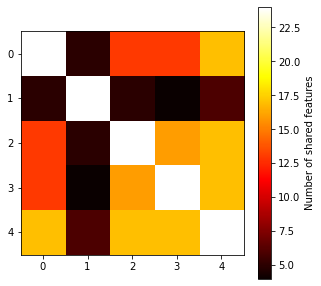

In [49]:
#Consistency of correlation feature selection
k=5
intersect=np.empty(shape=(k, k), dtype='float')

for i in range(0,k): # compare each fold to each other fold
    for j in range(0,k):
        intersect[i,j]=np.shape(np.intersect1d(comps[i], comps[j]))[0]

print(intersect)
plt.figure(figsize=(5,5))

plt.imshow(intersect, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Number of shared features')
plt.title('Similarity of features between folds', fontsize=20)

plt.scatter(row,col,color='k')
plt.savefig(results_dir+string+ '.png')
plt.show()

Final size of X: (101, 86)


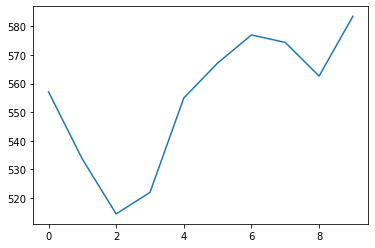

In [116]:
# partial least squares regression
from sklearn.cross_decomposition import PLSRegression
import hoggorm as ho
from scipy.stats import zscore

# cross-validation to find the number of components
components=np.linspace(1,10,10,dtype=int)

train_size=0.8
k=5

#X=np.concatenate([sc, fc], axis=1)
X=fc_n
X=prepare_data(X)

#set y to be the measure you want to predict
#Y = np.log(np.array(tmt))
Y=np.array(scores7)
Y=zscore(Y)

allvar=[]

outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)

explvar=[]
for train, test in outer_cv.split(X):
    press=gridsearch_plsr(k, X[train], Y[train], components)
    
plt.plot(press)


15


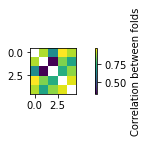

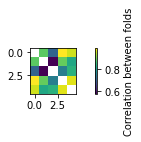

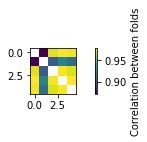

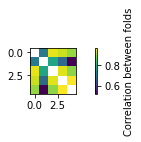

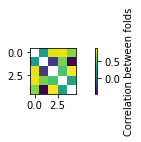

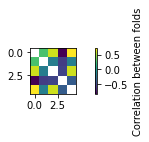

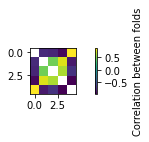

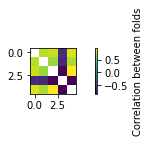

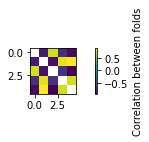

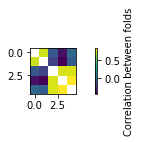

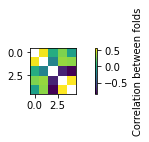

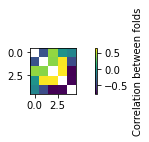

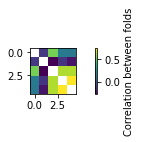

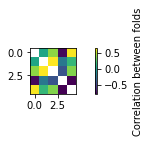

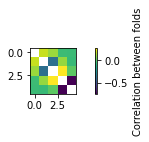

<BarContainer object of 15 artists>

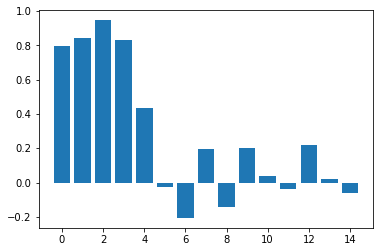

In [96]:
#Consistency of PCA feature selection

print(bestfeats)

correl=np.empty(shape=(k, k), dtype='float')
correlationp=[]
for p in range(0, bestfeats):
    for i in range(0,k): # compare each fold to each other fold
        for j in range(0,k):
            if i==j:
                correl[i,j]=np.nan
            else:
                #correlation between fold i and j for feature # p
                correl[i,j]=np.corrcoef(comps[i][p], comps[j][p])[1,0]
                #intersect[i, j]=np.intersect1d(comps[i], comps[j])
    plt.figure(figsize=(15,15))

    plt.subplot(bestfeats,2, p+1)
    plt.imshow(correl)
    cbar = plt.colorbar()
    cbar.set_label('Correlation between folds')
    plt.show()

    correlationp.append(np.nanmean(np.nanmean(correl)))
            


plt.bar(range(0, bestfeats), correlationp)
